<a href="https://colab.research.google.com/github/Ciss48/Optimize_level_time/blob/main/Optimize_time_play.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [21]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

project_id = 'crazy-coffee-jam'

from google.colab import auth
auth.authenticate_user()
# Construct a BigQuery client object.
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

# Prepare df

In [22]:
version = '1.0.18'
start_date = '2025-06-17'
start_level = 15
level_end = 100
end_date = ''

In [81]:
query = f"""
WITH start_users AS (
  SELECT
    level,
    SUM(COALESCE(revive,0)) as num_revive_start,
    SUM(COALESCE(booster_use,0)) as num_booster_start,
    COUNT(DISTINCT user_pseudo_id) as start_user_general,
    COUNT(user_pseudo_id) as start_event_general,

    COUNT(DISTINCT CASE WHEN revive = 0  THEN user_pseudo_id END) as start_user_not_revive,
    COUNT(CASE WHEN revive = 0  THEN user_pseudo_id END) as start_event_not_revive,
    COUNT(DISTINCT CASE WHEN booster_use = 0  THEN user_pseudo_id END) as start_user_not_booster,
    COUNT(CASE WHEN booster_use = 0  THEN user_pseudo_id END) as start_event_not_booster,
    COUNT(DISTINCT CASE WHEN booster_use = 0  and revive = 0 THEN user_pseudo_id END) as start_user_not_resource,
    COUNT(CASE WHEN booster_use = 0  and revive = 0 THEN user_pseudo_id END) as start_event_not_resource,

    COUNT(DISTINCT CASE WHEN revive > 0 and booster_use = 0 THEN user_pseudo_id END) as start_user_revive,
    COUNT(CASE WHEN revive > 0 and booster_use = 0 THEN user_pseudo_id END) as start_event_revive,
    COUNT(DISTINCT CASE WHEN booster_use > 0 and revive = 0 THEN user_pseudo_id END) as start_user_booster,
    COUNT(CASE WHEN booster_use > 0 and revive = 0 THEN user_pseudo_id END) as start_event_booster,
    COUNT(DISTINCT CASE WHEN revive > 0 and booster_use > 0 THEN user_pseudo_id END) as start_user_revive_booster,
    COUNT(CASE WHEN revive > 0 and booster_use > 0 THEN user_pseudo_id END) as start_event_revive_booster,

    COUNT(DISTINCT CASE WHEN attempt_times = 1 THEN user_pseudo_id END) as start_user_att1,
    COUNT(CASE WHEN attempt_times = 1 THEN user_pseudo_id END) as start_event_att1,
    COUNT(DISTINCT CASE WHEN attempt_times = 2 THEN user_pseudo_id END) as start_user_att2,
    COUNT(CASE WHEN attempt_times = 2 THEN user_pseudo_id END) as start_event_att2,

    COUNT(DISTINCT CASE WHEN attempt_times = 1 and revive > 0 and booster_use = 0 THEN user_pseudo_id END) as start_user_att1_revive,
    COUNT(CASE WHEN attempt_times = 1 and revive > 0 and booster_use = 0 THEN user_pseudo_id END) as start_event_att1_revive,
    COUNT(DISTINCT CASE WHEN attempt_times = 2 and revive > 0 and booster_use = 0 THEN user_pseudo_id END) as start_user_att2_revive,
    COUNT(CASE WHEN attempt_times = 2 and revive > 0 and booster_use = 0 THEN user_pseudo_id END) as start_event_att2_revive,

    COUNT(DISTINCT CASE WHEN attempt_times = 1 and revive = 0 and booster_use > 0 THEN user_pseudo_id END) as start_user_att1_booster,
    COUNT(CASE WHEN attempt_times = 1 and revive = 0 and booster_use > 0 THEN user_pseudo_id END) as start_event_att1_booster,
    COUNT(DISTINCT CASE WHEN attempt_times = 2 and revive = 0 and booster_use > 0 THEN user_pseudo_id END) as start_user_att2_booster,
    COUNT(CASE WHEN attempt_times = 2 and revive = 0 and booster_use > 0 THEN user_pseudo_id END) as start_event_att2_booster,

    COUNT(DISTINCT CASE WHEN attempt_times = 1 and revive > 0 and booster_use > 0 THEN user_pseudo_id END) as start_user_att1_revive_booster,
    COUNT(CASE WHEN attempt_times = 1 and revive > 0 and booster_use > 0 THEN user_pseudo_id END) as start_event_att1_revive_booster,
    COUNT(DISTINCT CASE WHEN attempt_times = 2 and revive > 0 and booster_use > 0 THEN user_pseudo_id END) as start_user_att2_revive_booster,
    COUNT(CASE WHEN attempt_times = 2 and revive > 0 and booster_use > 0 THEN user_pseudo_id END) as start_event_att2_revive_booster,
  FROM `crazy-coffee-jam.dashboard_table.level_data`
  WHERE event_date >= '{start_date}'
    AND version = '{version}'
    AND level <= {level_end}
    AND level >= {start_level}
  GROUP BY level
),
win_stats AS (
  SELECT
    level,
    COUNT(DISTINCT user_pseudo_id) as win_user_general,
    SUM(COALESCE(revive_win,0)) as num_revive_win,
    SUM(COALESCE(booster_use,0)) as num_booster_win,
    AVG(CASE WHEN count_sec > 30 THEN count_sec ELSE NULL END) AS avg_time_play_win,
    STDDEV(CASE WHEN count_sec > 30 THEN count_sec ELSE NULL END) as std_time_play_win,
    MAX(CASE WHEN count_sec > 30 THEN count_sec ELSE NULL END) as max_time_play_win,
    MIN(CASE WHEN count_sec > 30 THEN count_sec ELSE NULL END) as min_time_play_win,

    COUNT(DISTINCT CASE WHEN revive_win = 0 THEN user_pseudo_id END) as win_user_not_revive,
    AVG(CASE WHEN revive_win = 0 and count_sec > 30 THEN count_sec ELSE NULL END) as avg_time_win_not_revive,
    STDDEV(CASE WHEN revive_win = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS std_time_win_not_revive,
    MAX(CASE WHEN revive_win = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS max_time_win_not_revive,
    MIN(CASE WHEN revive_win = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS min_time_win_not_revive,

    COUNT(DISTINCT CASE WHEN booster_use = 0 THEN user_pseudo_id END) as win_user_not_booster,
    AVG(CASE WHEN booster_use = 0 and count_sec > 30 THEN count_sec ELSE NULL END) as avg_time_win_not_booster,
    STDDEV(CASE WHEN booster_use = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS std_time_win_not_booster,
    MAX(CASE WHEN booster_use = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS max_time_win_not_booster,
    MIN(CASE WHEN booster_use = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS min_time_win_not_booster,

    COUNT(DISTINCT CASE WHEN booster_use = 0 and revive_win = 0 THEN user_pseudo_id END) as win_user_not_resource,
    AVG(CASE WHEN booster_use = 0 and revive_win = 0 and count_sec > 30 THEN count_sec ELSE NULL END) as avg_time_win_not_resource,
    STDDEV(CASE WHEN booster_use = 0 and revive_win = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS std_time_win_not_resource,
    MAX(CASE WHEN booster_use = 0 and revive_win = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS max_time_win_not_resource,
    MIN(CASE WHEN booster_use = 0 and revive_win = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS min_time_win_not_resource,


    COUNT(DISTINCT CASE WHEN revive_win > 0 and booster_use = 0 THEN user_pseudo_id END) as win_user_revive,
    AVG(CASE WHEN revive_win > 0 and booster_use = 0 and count_sec > 30 THEN count_sec ELSE NULL END) as avg_time_win_revive,
    STDDEV(CASE WHEN revive_win > 0 and booster_use = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS std_time_win_revive,
    MAX(CASE WHEN revive_win > 0 and booster_use = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS max_time_win_revive,
    MIN(CASE WHEN revive_win > 0 and booster_use = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS min_time_win_revive,

    COUNT(DISTINCT  CASE WHEN booster_use > 0 and revive_win = 0 THEN user_pseudo_id END) as win_user_booster,
    AVG(CASE WHEN booster_use > 0 and revive_win = 0 and count_sec > 30 THEN count_sec ELSE NULL END) as avg_time_win_booster,
    STDDEV(CASE WHEN booster_use > 0 and revive_win = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS std_time_win_booster,
    MAX(CASE WHEN booster_use > 0 and revive_win = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS max_time_win_booster,
    MIN(CASE WHEN booster_use > 0 and revive_win = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS min_time_win_booster,

    COUNT(DISTINCT CASE WHEN booster_use > 0 and revive_win > 0 THEN user_pseudo_id END) as win_user_booster_revive,
    AVG(CASE WHEN booster_use > 0 and revive_win > 0 and count_sec > 30 THEN count_sec ELSE NULL END) as avg_time_win_booster_revive,
    STDDEV(CASE WHEN booster_use > 0 and revive_win > 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS std_time_win_booster_revive,
    MAX(CASE WHEN booster_use > 0 and revive_win > 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS max_time_win_booster_revive,
    MIN(CASE WHEN booster_use > 0 and revive_win > 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS min_time_win_booster_revive,


    COUNT(DISTINCT CASE WHEN win_at_attempt = 1 THEN user_pseudo_id END) as win_user_att1,
    AVG(CASE WHEN win_at_attempt = 1 and count_sec > 30 THEN count_sec ELSE NULL END) AS avg_time_play_att1,
    STDDEV(CASE WHEN win_at_attempt = 1 and count_sec > 30 THEN count_sec ELSE NULL END) AS std_time_play_att1,
    MAX(CASE WHEN win_at_attempt = 1 and count_sec > 30 THEN count_sec ELSE NULL END) AS max_time_play_att1,
    MIN(CASE WHEN win_at_attempt = 1 and count_sec > 30 THEN count_sec ELSE NULL END) AS min_time_play_att1,

    COUNT(DISTINCT CASE WHEN win_at_attempt = 2 THEN user_pseudo_id END) as win_user_att2,
    AVG(CASE WHEN win_at_attempt = 2 and count_sec > 30 THEN count_sec ELSE NULL END) AS avg_time_play_att2,
    STDDEV(CASE WHEN win_at_attempt = 2 and count_sec > 30 THEN count_sec ELSE NULL END) AS std_time_play_att2,
    MAX(CASE WHEN win_at_attempt = 2 and count_sec > 30 THEN count_sec ELSE NULL END) AS max_time_play_att2,
    MIN(CASE WHEN win_at_attempt = 2 and count_sec > 30 THEN count_sec ELSE NULL END) AS min_time_play_att2,

    COUNT(DISTINCT CASE WHEN win_at_attempt = 1 and revive_win > 0 and booster_use = 0 THEN user_pseudo_id END) as win_user_att1_revive,
    AVG(CASE WHEN win_at_attempt = 1 and revive_win > 0 and booster_use = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS avg_time_play_att1_revive,
    STDDEV(CASE WHEN win_at_attempt = 1 and revive_win > 0 and booster_use = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS std_time_play_att1_revive,
    MAX(CASE WHEN win_at_attempt = 1 and revive_win > 0 and booster_use = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS max_time_play_att1_revive,
    MIN(CASE WHEN win_at_attempt = 1 and revive_win > 0 and booster_use = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS min_time_play_att1_revive,

    COUNT(DISTINCT CASE WHEN win_at_attempt = 2 and revive_win > 0 and booster_use = 0 THEN user_pseudo_id END) as win_user_att2_revive,
    AVG(CASE WHEN win_at_attempt = 2 and revive_win > 0 and booster_use = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS avg_time_play_att2_revive,
    STDDEV(CASE WHEN win_at_attempt = 2 and revive_win > 0 and booster_use = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS std_time_play_att2_revive,
    MAX(CASE WHEN win_at_attempt = 2 and revive_win > 0 and booster_use = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS max_time_play_att2_revive,
    MIN(CASE WHEN win_at_attempt = 2 and revive_win > 0 and booster_use = 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS min_time_play_att2_revive,

    COUNT(DISTINCT CASE WHEN win_at_attempt = 1 and revive_win = 0 and booster_use > 0 THEN user_pseudo_id END) as win_user_att1_booster,
    AVG(CASE WHEN win_at_attempt = 1 and revive_win = 0 and booster_use > 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS avg_time_play_att1_booster,
    STDDEV(CASE WHEN win_at_attempt = 1 and revive_win = 0 and booster_use > 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS std_time_play_att1_booster,
    MAX(CASE WHEN win_at_attempt = 1 and revive_win = 0 and booster_use > 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS max_time_play_att1_booster,
    MIN(CASE WHEN win_at_attempt = 1 and revive_win = 0 and booster_use > 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS min_time_play_att1_booster,

    COUNT(DISTINCT CASE WHEN win_at_attempt = 2 and revive_win = 0 and booster_use > 0 THEN user_pseudo_id END) as win_user_att2_booster,
    AVG(CASE WHEN win_at_attempt = 2 and revive_win = 0 and booster_use > 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS avg_time_play_att2_booster,
    STDDEV(CASE WHEN win_at_attempt = 2 and revive_win = 0 and booster_use > 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS std_time_play_att2_booster,
    MAX(CASE WHEN win_at_attempt = 2 and revive_win = 0 and booster_use > 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS max_time_play_att2_booster,
    MIN(CASE WHEN win_at_attempt = 2 and revive_win = 0 and booster_use > 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS min_time_play_att2_booster,

    COUNT(DISTINCT CASE WHEN win_at_attempt = 1 and revive_win > 0 and booster_use > 0 THEN user_pseudo_id END) as win_user_att1_revive_booster,
    AVG(CASE WHEN win_at_attempt = 1 and revive_win > 0 and booster_use > 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS avg_time_play_att1_revive_booster,
    STDDEV(CASE WHEN win_at_attempt = 1 and revive_win > 0 and booster_use > 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS std_time_play_att1_revive_booster,
    MAX(CASE WHEN win_at_attempt = 1 and revive_win > 0 and booster_use > 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS max_time_play_att1_revive_booster,
    MIN(CASE WHEN win_at_attempt = 1 and revive_win > 0 and booster_use > 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS min_time_play_att1_revive_booster,

    COUNT(DISTINCT CASE WHEN win_at_attempt = 2 and revive_win > 0 and booster_use > 0 THEN user_pseudo_id END) as win_user_att2_revive_booster,
    AVG(CASE WHEN win_at_attempt = 2 and revive_win > 0 and booster_use > 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS avg_time_play_att2_revive_booster,
    STDDEV(CASE WHEN win_at_attempt = 2 and revive_win > 0 and booster_use > 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS std_time_play_att2_revive_booster,
    MAX(CASE WHEN win_at_attempt = 2 and revive_win > 0 and booster_use > 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS max_time_play_att2_revive_booster,
    MIN(CASE WHEN win_at_attempt = 2 and revive_win > 0 and booster_use > 0 and count_sec > 30 THEN count_sec ELSE NULL END) AS min_time_play_att2_revive_booster

  FROM `crazy-coffee-jam.dashboard_table.win_level_time_attemp`
  WHERE event_date >= '{start_date}'
    AND version = '{version}'
    AND level <= {level_end}
    AND level >= {start_level}
  GROUP BY level
)

SELECT
  s.level,
  s.num_revive_start,
  s.num_booster_start,
  s.start_user_general,
  s.start_event_general,

  s.start_user_not_revive,
  s.start_event_not_revive,

  s.start_user_not_booster,
  s.start_event_not_booster,

  s.start_user_not_resource,
  s.start_event_not_resource,

  s.start_user_revive,
  s.start_event_revive,

  s.start_user_booster,
  s.start_event_booster,

  s.start_user_revive_booster,
  s.start_event_revive_booster,

  s.start_user_att1,
  s.start_event_att1,

  s.start_user_att2,
  s.start_event_att2,

  s.start_user_att1_revive,
  s.start_event_att1_revive,

  s.start_user_att2_revive,
  s.start_event_att2_revive,

  s.start_user_att1_booster,
  s.start_event_att1_booster,

  s.start_user_att2_booster,
  s.start_event_att2_booster,

  s.start_user_att1_revive_booster,
  s.start_event_att1_revive_booster,

  s.start_user_att2_revive_booster,
  s.start_event_att2_revive_booster,

  w.win_user_general,
  COALESCE(w.num_booster_win,0) as num_booster_win,
  COALESCE(w.num_revive_win,0) as num_revive_win,

  COALESCE(w.avg_time_play_win,0) as avg_time_play_win,
  COALESCE(w.std_time_play_win,0) as std_time_play_win,
  COALESCE(w.max_time_play_win,0) as max_time_play_win,
  COALESCE(w.min_time_play_win,0) as min_time_play_win,

  COALESCE(w.win_user_not_revive,0) as win_user_not_revive,
  COALESCE(w.avg_time_win_not_revive,0) as avg_time_win_not_revive,
  COALESCE(w.std_time_win_not_revive,0) as std_time_win_not_revive,
  COALESCE(w.max_time_win_not_revive,0) as max_time_win_not_revive,
  COALESCE(w.min_time_win_not_revive,0) as min_time_win_not_revive,

  COALESCE(w.win_user_not_booster,0) as win_user_not_booster,
  COALESCE(w.avg_time_win_not_booster,0) as avg_time_win_not_booster,
  COALESCE(w.std_time_win_not_booster,0) as std_time_win_not_booster,
  COALESCE(w.max_time_win_not_booster,0) as max_time_win_not_booster,
  COALESCE(w.min_time_win_not_booster,0) as min_time_win_not_booster,

  COALESCE(w.win_user_not_resource,0) as win_user_not_resource,
  COALESCE(w.avg_time_win_not_resource,0) as avg_time_win_not_resource,
  COALESCE(w.std_time_win_not_resource,0) as std_time_win_not_resource,
  COALESCE(w.max_time_win_not_resource,0) as max_time_win_not_resource,
  COALESCE(w.min_time_win_not_resource,0) as min_time_win_not_resource,

  COALESCE(w.win_user_revive,0) as win_user_revive,
  COALESCE(w.avg_time_win_revive,0) as avg_time_win_revive,
  COALESCE(w.std_time_win_revive,0) as std_time_win_revive,
  COALESCE(w.max_time_win_revive,0) as max_time_win_revive,
  COALESCE(w.min_time_win_revive,0) as min_time_win_revive,

  COALESCE(w.win_user_booster,0) as win_user_booster,
  COALESCE(w.avg_time_win_booster,0) as avg_time_win_booster,
  COALESCE(w.std_time_win_booster,0) as std_time_win_booster,
  COALESCE(w.max_time_win_booster,0) as max_time_win_booster,
  COALESCE(w.min_time_win_booster,0) as min_time_win_booster,

  COALESCE(w.win_user_booster_revive,0) as win_user_booster_revive,
  COALESCE(w.avg_time_win_booster_revive,0) as avg_time_win_booster_revive,
  COALESCE(w.std_time_win_booster_revive,0) as std_time_win_booster_revive,
  COALESCE(w.max_time_win_booster_revive,0) as max_time_win_booster_revive,
  COALESCE(w.min_time_win_booster_revive,0) as min_time_win_booster_revive,

  COALESCE(w.win_user_att1,0) as win_user_att1,
  COALESCE(w.avg_time_play_att1,0) as avg_time_play_att1,
  COALESCE(w.std_time_play_att1,0) as std_time_play_att1,
  COALESCE(w.max_time_play_att1,0) as max_time_play_att1,
  COALESCE(w.min_time_play_att1,0) as min_time_play_att1,

  COALESCE(w.win_user_att2,0) as win_user_att2,
  COALESCE(w.avg_time_play_att2,0) as avg_time_play_att2,
  COALESCE(w.std_time_play_att2,0) as std_time_play_att2,
  COALESCE(w.max_time_play_att2,0) as max_time_play_att2,
  COALESCE(w.min_time_play_att2,0) as min_time_play_att2,

  COALESCE(w.win_user_att1_revive,0) as win_user_att1_revive,
  COALESCE(w.avg_time_play_att1_revive,0) as avg_time_play_att1_revive,
  COALESCE(w.std_time_play_att1_revive,0) as std_time_play_att1_revive,
  COALESCE(w.max_time_play_att1_revive,0) as max_time_play_att1_revive,
  COALESCE(w.min_time_play_att1_revive,0) as min_time_play_att1_revive,

  COALESCE(w.win_user_att2_revive,0) as win_user_att2_revive,
  COALESCE(w.avg_time_play_att2_revive,0) as avg_time_play_att2_revive,
  COALESCE(w.std_time_play_att2_revive,0) as std_time_play_att2_revive,
  COALESCE(w.max_time_play_att2_revive,0) as max_time_play_att2_revive,
  COALESCE(w.min_time_play_att2_revive,0) as min_time_play_att2_revive,

  COALESCE(w.win_user_att1_booster,0) as win_user_att1_booster,
  COALESCE(w.avg_time_play_att1_booster,0) as avg_time_play_att1_booster,
  COALESCE(w.std_time_play_att1_booster,0) as std_time_play_att1_booster,
  COALESCE(w.max_time_play_att1_booster,0) as max_time_play_att1_booster,
  COALESCE(w.min_time_play_att1_booster,0) as min_time_play_att1_booster,

  COALESCE(w.win_user_att2_booster,0) as win_user_att2_booster,
  COALESCE(w.avg_time_play_att2_booster,0) as avg_time_play_att2_booster,
  COALESCE(w.std_time_play_att2_booster,0) as std_time_play_att2_booster,
  COALESCE(w.max_time_play_att2_booster,0) as max_time_play_att2_booster,
  COALESCE(w.min_time_play_att2_booster,0) as min_time_play_att2_booster,

  COALESCE(w.win_user_att1_revive_booster,0) as win_user_att1_revive_booster,
  COALESCE(w.avg_time_play_att1_revive_booster,0) as avg_time_play_att1_revive_booster,
  COALESCE(w.std_time_play_att1_revive_booster,0) as std_time_play_att1_revive_booster,
  COALESCE(w.max_time_play_att1_revive_booster,0) as max_time_play_att1_revive_booster,
  COALESCE(w.min_time_play_att1_revive_booster,0) as min_time_play_att1_revive_booster,

  COALESCE(w.win_user_att2_revive_booster,0) as win_user_att2_revive_booster,
  COALESCE(w.avg_time_play_att2_revive_booster,0) as avg_time_play_att2_revive_booster,
  COALESCE(w.std_time_play_att2_revive_booster,0) as std_time_play_att2_revive_booster,
  COALESCE(w.max_time_play_att2_revive_booster,0) as max_time_play_att2_revive_booster,
  COALESCE(w.min_time_play_att2_revive_booster,0) as min_time_play_att2_revive_booster
FROM start_users s
LEFT JOIN win_stats w ON s.level = w.level
ORDER BY s.level;

"""

df = client.query(query).to_dataframe()

In [82]:
df['level'].unique()

<IntegerArray>
[ 15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100]
Length: 86, dtype: Int64

In [25]:
import pandas as pd

# Giả sử bạn đã có DataFrame df với số dòng tương ứng (ví dụ: df có 100 level)
time_values = [
    180, 150, 300, 180, 150, 180, 100, 90, 120, 180, 150, 90, 90, 140, 150, 180,
    180, 150, 180, 180, 180, 120, 120, 120, 140, 130, 120, 180, 150, 120, 100,
    120, 100, 140, 120, 240, 180, 150, 140, 150, 160, 120, 150, 110, 150, 120,
    120, 180, 90, 140, 130, 180, 150, 90, 100, 180, 100, 60, 150, 120, 130, 120,
    140, 120, 100, 180, 180, 90, 90, 180, 160, 90, 100, 130, 150, 150, 70, 100,
    100, 120, 180, 100, 100, 140, 120, 90
]

# Thêm cột vào DataFrame
df['time_default'] = time_values


In [26]:
df.columns

Index(['level', 'num_revive_start', 'num_booster_start', 'start_user_general',
       'start_event_general', 'start_user_not_revive',
       'start_event_not_revive', 'start_user_not_booster',
       'start_event_not_booster', 'start_user_not_resource',
       ...
       'avg_time_play_att1_revive_booster',
       'std_time_play_att1_revive_booster',
       'max_time_play_att1_revive_booster',
       'min_time_play_att1_revive_booster', 'win_user_att2_revive_booster',
       'avg_time_play_att2_revive_booster',
       'std_time_play_att2_revive_booster',
       'max_time_play_att2_revive_booster',
       'min_time_play_att2_revive_booster', 'time_default'],
      dtype='object', length=111)

In [83]:
df_for_print = df[['level','win_user_general','avg_time_play_win','win_user_att1','avg_time_play_att1','win_user_att2','avg_time_play_att2','win_user_revive','avg_time_win_revive']]
df_for_print

level  win_user_general  avg_time_play_win  win_user_att1  \
0      15              1541         123.879743           1400   
1      16              1429          67.776521           1363   
2      17              1372         137.525436           1310   
3      18              1311          45.483871           1288   
4      19              1272          88.432050           1189   
..    ...               ...                ...            ...   
81     96               232          76.376623            207   
82     97               226         110.164444            193   
83     98               228         129.324561            203   
84     99               228         105.517544            185   
85    100               229          88.541485            175   

    avg_time_play_att1  win_user_att2  avg_time_play_att2  win_user_revive  \
0           121.130714            118          145.773109               30   
1            66.950223             61           84.016129                8   
2           135.755725             52          171.698113                0   
3            46.000000             20           38.000000                1   
4            87.238856             72          102.305556               18   
..                 ...            ...                 ...              ...   
81           75.728155             19           78.105263               14   
82          110.567708             20          111.600000               58   
83          127.527094             15          134.066667               22   
84          103.967568             28          110.428571               29   
85           86.160000             35           99.457143               15   

    avg_time_win_revive  
0            237.366667  
1            168.250000  
2              0.000000  
3            183.000000  
4            172.666667  
..                  ...  
81           135.071429  
82           145.896552  
83           193.909091  
84           153.931034  
85           124.466667  

[86 rows x 9 columns]

In [27]:
df_general = df[['level','time_default','start_user_general','start_event_general', 'win_user_general','num_revive_start','num_booster_start','num_revive_win','num_booster_win', 'avg_time_play_win','std_time_play_win', 'max_time_play_win','min_time_play_win','win_user_revive','win_user_booster','win_user_booster_revive' ,'win_user_not_revive','win_user_not_booster','win_user_not_resource','win_user_att1','win_user_att2']]
df_not_revive = df[['level','time_default','start_user_not_revive','start_event_not_revive', 'win_user_not_revive', 'avg_time_win_not_revive','std_time_win_not_revive', 'max_time_win_not_revive','min_time_win_not_revive']]
df_not_booster = df[['level','time_default','start_user_not_booster','start_event_not_booster', 'win_user_not_booster', 'avg_time_win_not_booster', 'std_time_win_not_booster','max_time_win_not_booster', 'min_time_win_not_booster']]
df_not_resource = df[['level','time_default','start_user_not_resource','start_event_not_resource', 'win_user_not_resource', 'avg_time_win_not_resource','std_time_win_not_resource', 'max_time_win_not_resource','min_time_win_not_resource']]
df_reive = df[['level','time_default','start_user_revive','start_event_revive', 'win_user_revive', 'avg_time_win_revive', 'std_time_win_revive', 'max_time_win_revive', 'min_time_win_revive']]
df_booster = df[['level','time_default','start_user_booster','start_event_booster', 'win_user_booster', 'avg_time_win_booster', 'std_time_win_booster','max_time_win_booster', 'min_time_win_booster']]
df_revive_booster = df[['level','time_default','start_user_revive_booster','start_event_revive_booster', 'win_user_booster_revive', 'avg_time_win_booster_revive','std_time_win_booster_revive', 'max_time_win_booster_revive','min_time_win_booster_revive']]
df_att1 = df[['level','time_default','start_user_att1','start_event_att1', 'win_user_att1','avg_time_play_att1', 'std_time_play_att1', 'max_time_play_att1','min_time_play_att1']]
df_att2 = df[['level','time_default','start_user_att2','start_event_att2', 'win_user_att2', 'avg_time_play_att2','std_time_play_att2', 'max_time_play_att2', 'min_time_play_att2',]]
df_att1_revive = df[['level','time_default','start_user_att1_revive','start_event_att1_revive', 'win_user_att1_revive', 'avg_time_play_att1_revive','std_time_play_att1_revive', 'max_time_play_att1_revive','min_time_play_att1_revive']]
df_att2_revive = df[['level','time_default','start_user_att2_revive','start_event_att2_revive', 'win_user_att2_revive','avg_time_play_att2_revive', 'std_time_play_att2_revive','max_time_play_att2_revive', 'min_time_play_att2_revive']]
df_att1_booster = df[['level','time_default','start_user_att1_booster','start_event_att1_booster', 'win_user_att1_booster', 'avg_time_play_att1_booster','std_time_play_att1_booster', 'max_time_play_att1_booster','min_time_play_att1_booster']]
df_att2_booster = df[['level','time_default','start_user_att2_booster','start_event_att2_booster', 'win_user_att2_booster', 'avg_time_play_att2_booster','std_time_play_att2_booster', 'max_time_play_att2_booster','min_time_play_att2_booster']]
df_att1_revive_booster = df[['level','time_default','start_user_att1_revive_booster','start_event_att1_revive_booster', 'win_user_att1_revive_booster', 'avg_time_play_att1_revive_booster','std_time_play_att1_revive_booster','max_time_play_att1_revive_booster','min_time_play_att1_revive_booster']]
df_att2_revive_booster = df[['level','time_default','start_user_att2_revive_booster','start_event_att2_revive_booster', 'win_user_att2_revive_booster', 'avg_time_play_att2_revive_booster','std_time_play_att2_revive_booster','max_time_play_att2_revive_booster','min_time_play_att2_revive_booster']]

# EDA

## df general

In [74]:
df_general

level  time_default  start_user_general  start_event_general  \
0      15           180                1606                 1817   
1      16           150                1455                 1519   
2      17           300                1401                 1479   
3      18           180                1315                 1331   
4      19           150                1304                 1395   
..    ...           ...                 ...                  ...   
81     96           100                 234                  253   
82     97           100                 231                  292   
83     98           140                 229                  256   
84     99           120                 230                  293   
85    100            90                 232                  315   

    win_user_general  num_revive_start  num_booster_start  num_revive_win  \
0               1541                71                 64              50   
1               1429                19                 78              12   
2               1372                12               1467               8   
3               1311                 1                 14               1   
4               1272                41                 97              31   
..               ...               ...                ...             ...   
81               232                29                 18              23   
82               226               112                 44              94   
83               228                79                 63              62   
84               228                78                 63              56   
85               229               109                138              88   

    num_booster_win  avg_time_play_win  ...  revive_use_rate  \
0                52         123.879743  ...         0.039075   
1                67          67.776521  ...         0.012508   
2              1380         137.525436  ...         0.008114   
3                14          45.483871  ...         0.000751   
4                60          88.432050  ...         0.029391   
..              ...                ...  ...              ...   
81               17          76.376623  ...         0.114625   
82               29         110.164444  ...         0.383562   
83               51         129.324561  ...         0.308594   
84               52         105.517544  ...         0.266212   
85              124          88.541485  ...         0.346032   

    win_user_revive_rate  win_user_booster_rate  win_user_booster_revive_rate  \
0               0.019468                0.02401                      0.002596   
1               0.005598               0.035689                        0.0014   
2                    0.0               0.965743                      0.003644   
3               0.000763               0.005339                           0.0   
4               0.014151               0.027516                      0.003145   
..                   ...                    ...                           ...   
81              0.060345               0.038793                      0.017241   
82              0.256637               0.057522                      0.022124   
83              0.096491               0.070175                      0.052632   
84              0.127193               0.092105                      0.048246   
85              0.065502               0.135371                      0.187773   

    win_user_not_revive_rate  win_user_not_booster_rate  \
0                    0.97599                   0.971447   
1                   0.992302                   0.962211   
2                   0.995627                    0.03207   
3                   0.996949                   0.992372   
4                   0.982704                    0.96934   
..                       ...                        ...   
81                  0.918103                   0.939655   
82                  0.721239                   0

In [29]:
df_general['win_rate'] = df_general['win_user_general'] / df_general['start_event_general']

df_general['booster_use_rate'] = df_general['num_booster_start'] / df_general['start_event_general']
df_general['revive_use_rate'] = df_general['num_revive_start'] / df_general['start_event_general']

df_general['win_user_revive_rate'] = df_general['win_user_revive'] / df_general['win_user_general']
df_general['win_user_booster_rate'] = df_general['win_user_booster'] / df_general['win_user_general']
df_general['win_user_booster_revive_rate'] = df_general['win_user_booster_revive'] / df_general['win_user_general']

df_general['win_user_not_revive_rate'] = df_general['win_user_not_revive'] / df_general['win_user_general']
df_general['win_user_not_booster_rate'] = df_general['win_user_not_booster'] / df_general['win_user_general']
df_general['win_user_not_resource_rate'] = df_general['win_user_not_resource'] / df_general['win_user_general']

df_general['win_user_att1_rate'] = df_general['win_user_att1'] / df_general['win_user_general']
df_general['win_user_att2_rate'] = df_general['win_user_att2'] / df_general['win_user_general']


/tmp/ipython-input-29-3171897676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general['win_rate'] = df_general['win_user_general'] / df_general['start_event_general']
/tmp/ipython-input-29-3171897676.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general['booster_use_rate'] = df_general['num_booster_start'] / df_general['start_event_general']
/tmp/ipython-input-29-3171897676.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [30]:
# Filter data for levels 15-50
df_filtered = df_general[(df_general['level'] >= 15) & (df_general['level'] <= 50)]
df_filtered[['level','start_user_general','win_user_revive','win_user_booster','win_user_not_revive','win_user_not_booster','win_user_not_resource','win_user_att1','win_user_att2']]

level  start_user_general  win_user_revive  win_user_booster  \
0      15                1606               30                37   
1      16                1455                8                51   
2      17                1401                0              1325   
3      18                1315                1                 7   
4      19                1304               18                35   
5      20                1234                5               320   
6      21                1185                3              1006   
7      22                1164               84               124   
8      23                1084               66                14   
9      24                1029               17               114   
10     25                1030               54               289   
11     26                 907               30                27   
12     27                 911              191                11   
13     28                 836               33               128   
14     29                 820               40                65   
15     30                 816               46               228   
16     31                 749              124                33   
17     32                 696                0                 1   
18     33                 692                0                11   
19     34                 689               34                15   
20     35                 705               94               137   
21     36                 632               10                21   
22     37                 656              250                31   
23     38                 551              100                20   
24     39                 548               98               138   
25     40                 522              128                56   
26     41                 424               44                18   
27     42                 421                0                 3   
28     43                 422                3                 7   
29     44                 420               97                 6   
30     45                 432              199                25   
31     46                 389               31                 8   
32     47                 388              167                 8   
33     48                 395              114                52   
34     49                 390               37                40   
35     50                 374               16                41   

    win_user_not_revive  win_user_not_booster  win_user_not_resource  \
0                  1504                  1497                   1467   
1                  1418                  1375                   1367   
2                  1366                    44                     44   
3                  1307                  1301                   1300   
4                  1250                  1233                   1215   
5                  1186                   871                    866   
6                  1087                    84                     81   
7                   927                   887                    803   
8                   979                  1031                    965   
9                   974                   877                    860   
10                  799                   565                    511   
11                  846                   849                    819   
12                  635                   815                    624   
13                  757                   662                    629   
14                  722                   697                    657   
15                  658                   477                    431   
16                  567                   658                    534   
17                  696                   695                    695   
18                  688                   677                    677   
19                  642                   661  

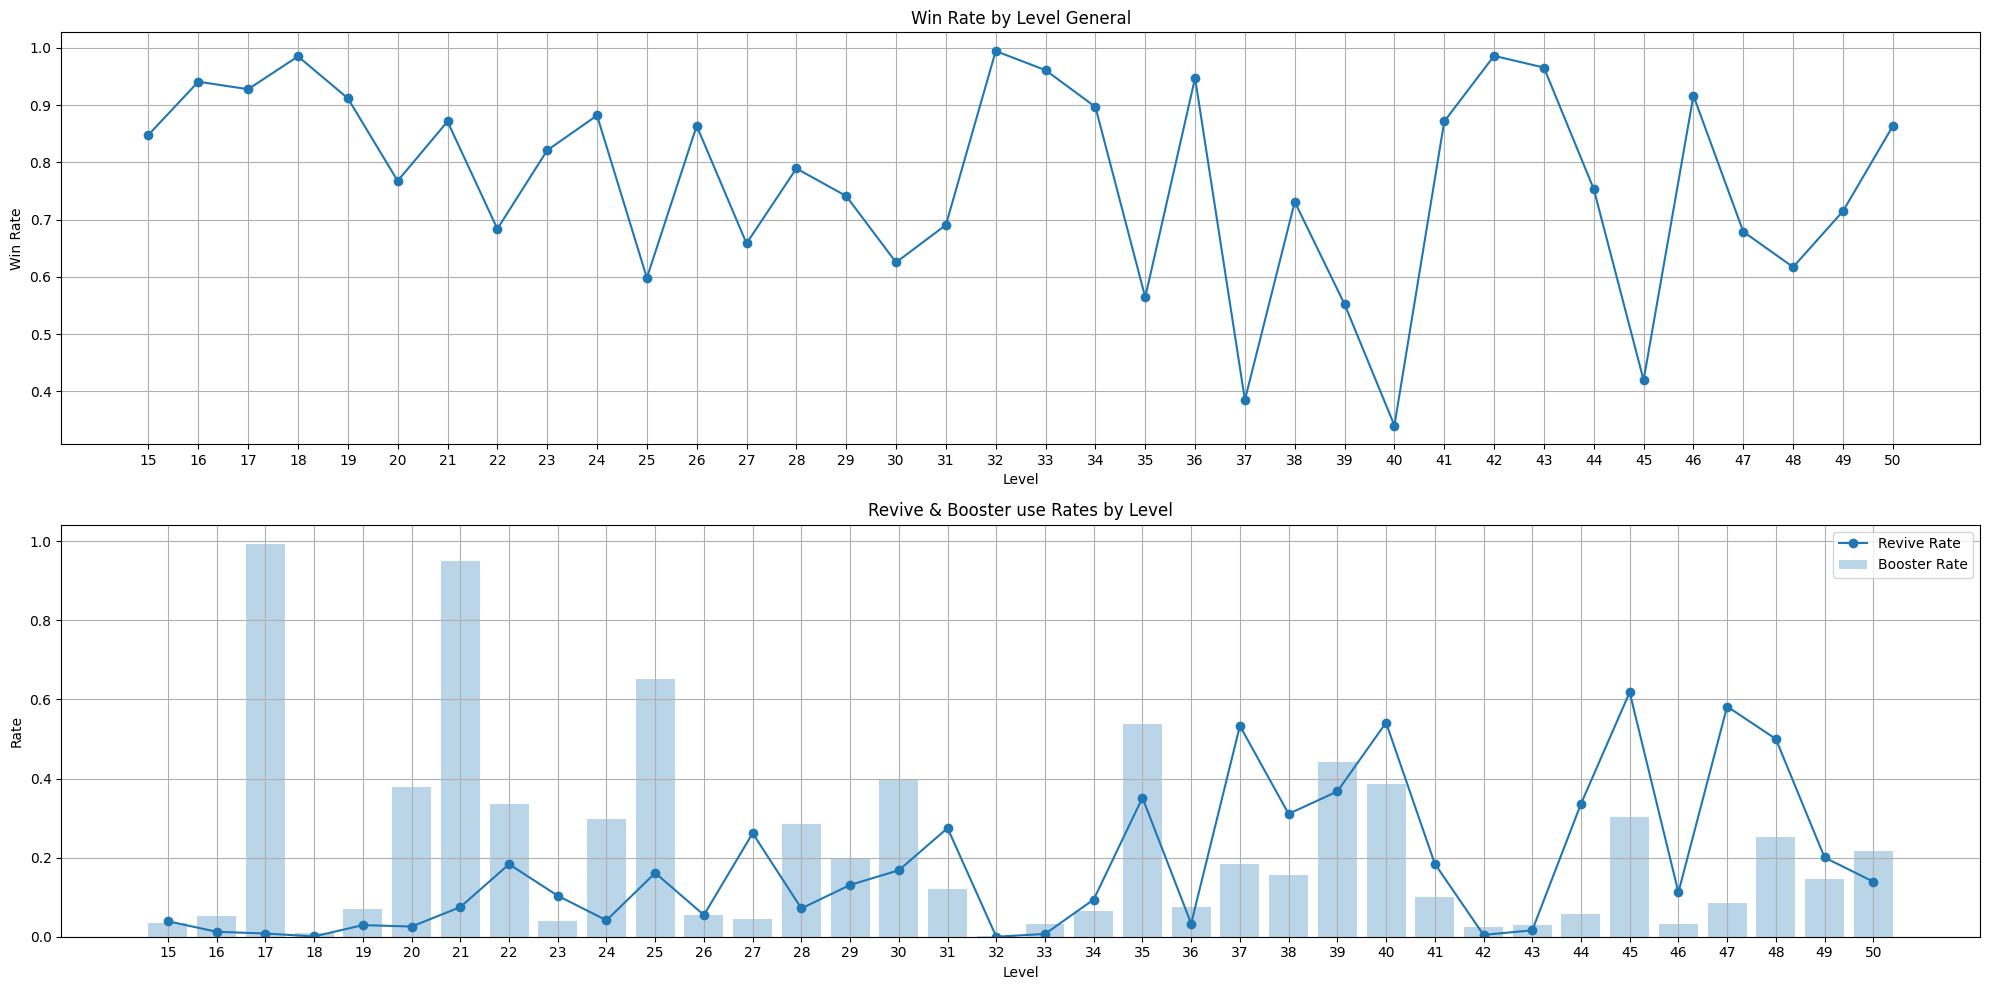

In [31]:
import matplotlib.pyplot as plt

# Filter data for levels 15-50
df_filtered = df_general[(df_general['level'] >= 15) & (df_general['level'] <= 50)]

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

# Plot win rate line chart
ax1.plot(df_filtered['level'], df_filtered['win_rate'], marker='o')
ax1.set_title('Win Rate by Level General')
ax1.set_xlabel('Level')
ax1.set_ylabel('Win Rate')
ax1.grid(True)
ax1.set_xticks(range(15, 51))


# Plot revive and booster rates
ax2.plot(df_filtered['level'], df_filtered['revive_use_rate'], marker='o', label='Revive Rate')
ax2.bar(df_filtered['level'], df_filtered['booster_use_rate'], alpha=0.3, label='Booster Rate')
ax2.set_title('Revive & Booster use Rates by Level')
ax2.set_xlabel('Level')
ax2.set_ylabel('Rate')
ax2.grid(True)
ax2.legend()
ax2.set_xticks(range(15, 51))
plt.tight_layout()
plt.show()

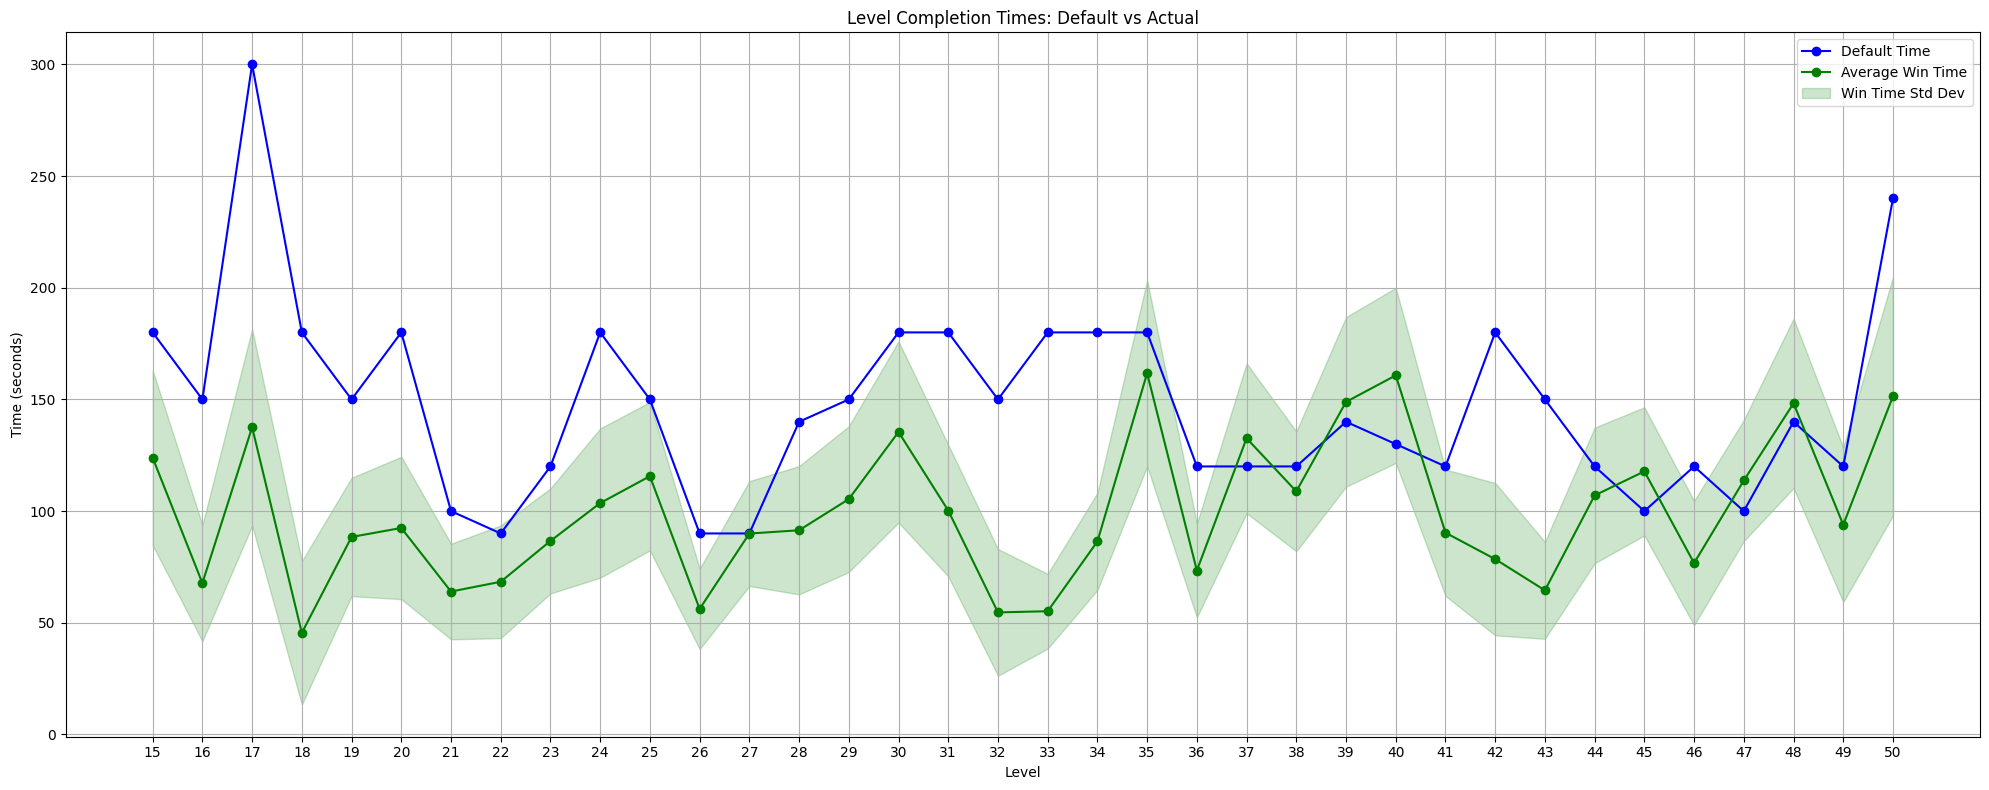

In [32]:
# Plot time comparison
plt.figure(figsize=(20, 8))

# Plot default time line
plt.plot(df_filtered['level'], df_filtered['time_default'], marker='o', label='Default Time', color='blue')

# Plot average win time with standard deviation band
plt.plot(df_filtered['level'], df_filtered['avg_time_play_win'], marker='o', label='Average Win Time', color='green')
plt.fill_between(df_filtered['level'],
                 df_filtered['avg_time_play_win'] - df_filtered['std_time_play_win'],
                 df_filtered['avg_time_play_win'] + df_filtered['std_time_play_win'],
                 alpha=0.2, color='green', label='Win Time Std Dev')

plt.title('Level Completion Times: Default vs Actual')
plt.xlabel('Level')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.legend()
plt.xticks(df_filtered['level'])

plt.tight_layout()
plt.show()

In [33]:
df_general['win_user_revive_rate'] = df_general['win_user_revive'] / df_general['win_user_general']
df_general['win_user_booster_rate'] = df_general['win_user_booster'] / df_general['win_user_general']
df_general['win_user_booster_revive_rate'] = df_general['win_user_booster_revive'] / df_general['win_user_general']

df_general['win_user_not_revive_rate'] = df_general['win_user_not_revive'] / df_general['win_user_general']
df_general['win_user_not_boost_rate'] = df_general['win_user_not_booster'] / df_general['win_user_general']
df_general['win_user_not_resource_rate'] = df_general['win_user_not_resource'] / df_general['win_user_general']

df_general['win_user_att1_rate'] = df_general['win_user_att1'] / df_general['win_user_general']
df_general['win_user_att2_rate'] = df_general['win_user_att2'] / df_general['win_user_general']

/tmp/ipython-input-33-2808967829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general['win_user_revive_rate'] = df_general['win_user_revive'] / df_general['win_user_general']
/tmp/ipython-input-33-2808967829.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general['win_user_booster_rate'] = df_general['win_user_booster'] / df_general['win_user_general']
/tmp/ipython-input-33-2808967829.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

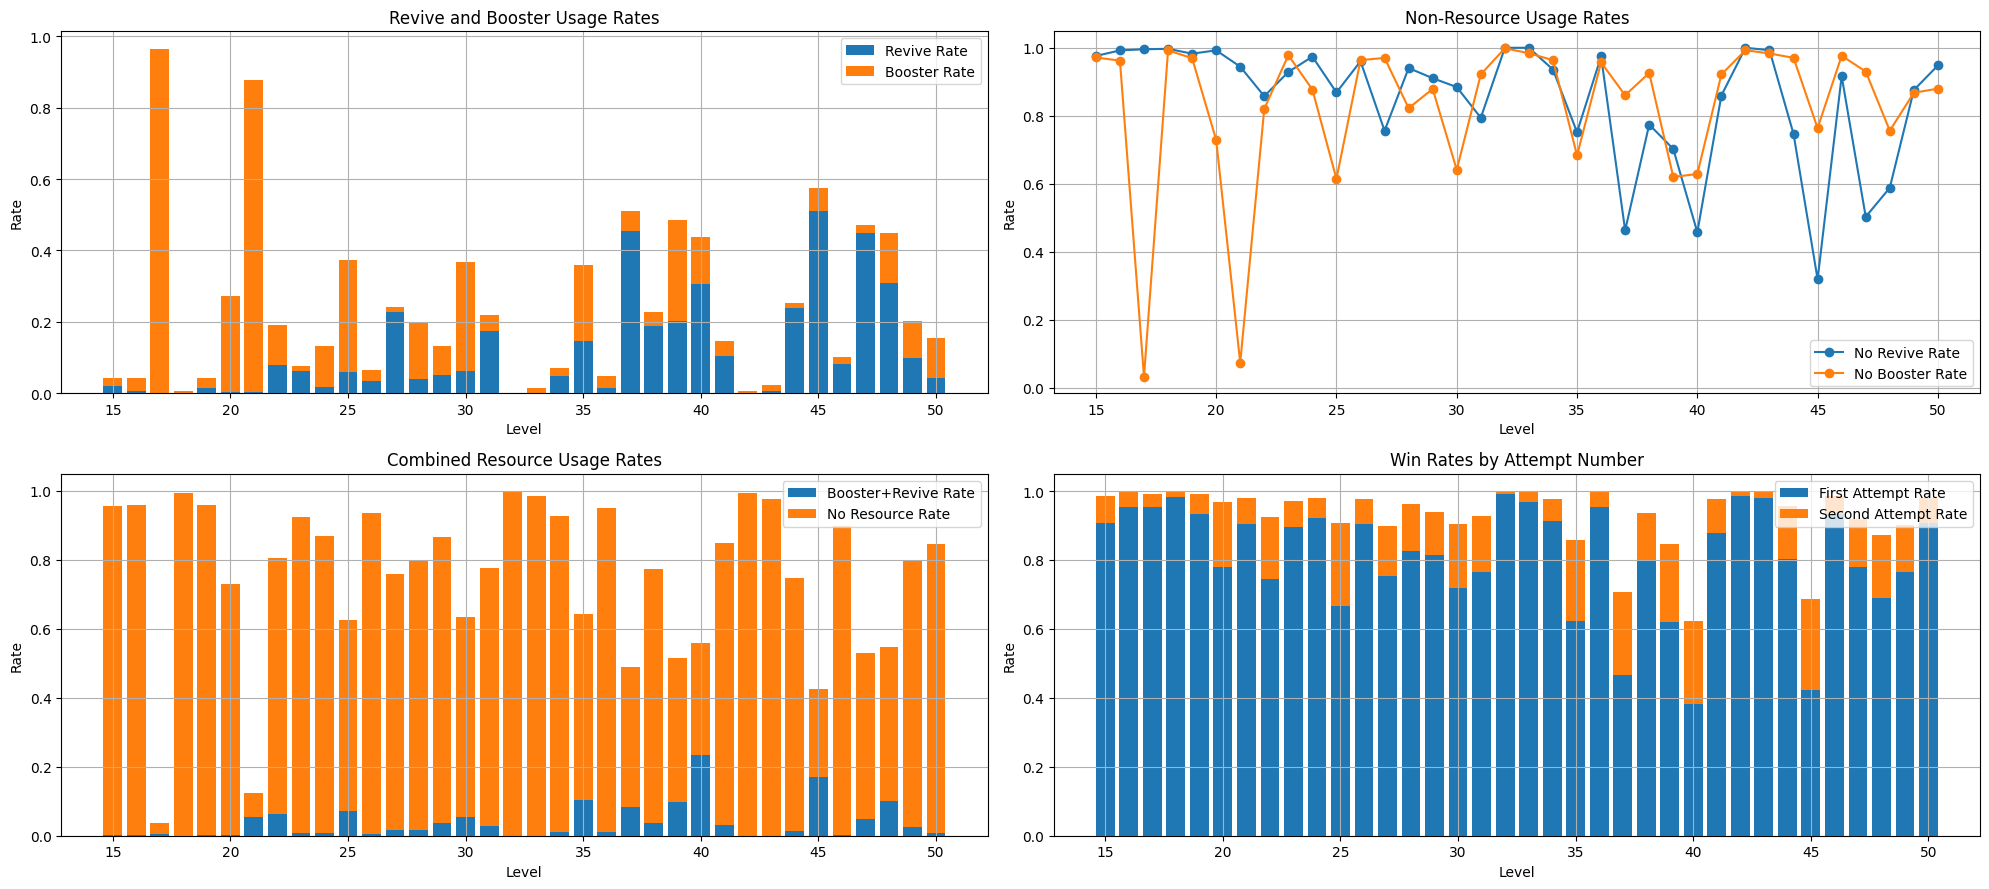

In [34]:
# Create figure with 4 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 9))

# Plot 1: Revive and Booster rates
ax1.bar(df_filtered['level'], df_filtered['win_user_revive_rate'], label='Revive Rate')
ax1.bar(df_filtered['level'], df_filtered['win_user_booster_rate'], bottom=df_filtered['win_user_revive_rate'], label='Booster Rate')
ax1.set_title('Revive and Booster Usage Rates')
ax1.set_xlabel('Level')
ax1.set_ylabel('Rate')
ax1.grid(True)
ax1.legend()

# Plot 2: Not Revive and Not Booster rates
ax2.plot(df_filtered['level'], df_filtered['win_user_not_revive_rate'], marker='o', label='No Revive Rate')
ax2.plot(df_filtered['level'], df_filtered['win_user_not_booster_rate'], marker='o', label='No Booster Rate')
ax2.set_title('Non-Resource Usage Rates')
ax2.set_xlabel('Level')
ax2.set_ylabel('Rate')
ax2.grid(True)
ax2.legend()

# Plot 3: Booster+Revive and No Resource rates
ax3.bar(df_filtered['level'], df_filtered['win_user_booster_revive_rate'], label='Booster+Revive Rate')
ax3.bar(df_filtered['level'], df_filtered['win_user_not_resource_rate'], bottom=df_filtered['win_user_booster_revive_rate'], label='No Resource Rate')
ax3.set_title('Combined Resource Usage Rates')
ax3.set_xlabel('Level')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

# Plot 4: Attempt rates
ax4.bar(df_filtered['level'], df_filtered['win_user_att1_rate'], label='First Attempt Rate')
ax4.bar(df_filtered['level'], df_filtered['win_user_att2_rate'], bottom=df_filtered['win_user_att1_rate'], label='Second Attempt Rate')
ax4.set_title('Win Rates by Attempt Number')
ax4.set_xlabel('Level')
ax4.set_ylabel('Rate')
ax4.grid(True)
ax4.legend()

plt.tight_layout()
plt.show()

## df_not_revive

In [35]:
df_not_revive_filtered = df_not_revive[(df_not_revive['level'] >= 15) & (df_not_revive['level'] <= 50)]
df_not_revive_filtered['not_revive_win_rate'] = df_not_revive_filtered['win_user_not_revive'] / df_not_revive_filtered['start_event_not_revive']

/tmp/ipython-input-35-4088908643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_revive_filtered['not_revive_win_rate'] = df_not_revive_filtered['win_user_not_revive'] / df_not_revive_filtered['start_event_not_revive']


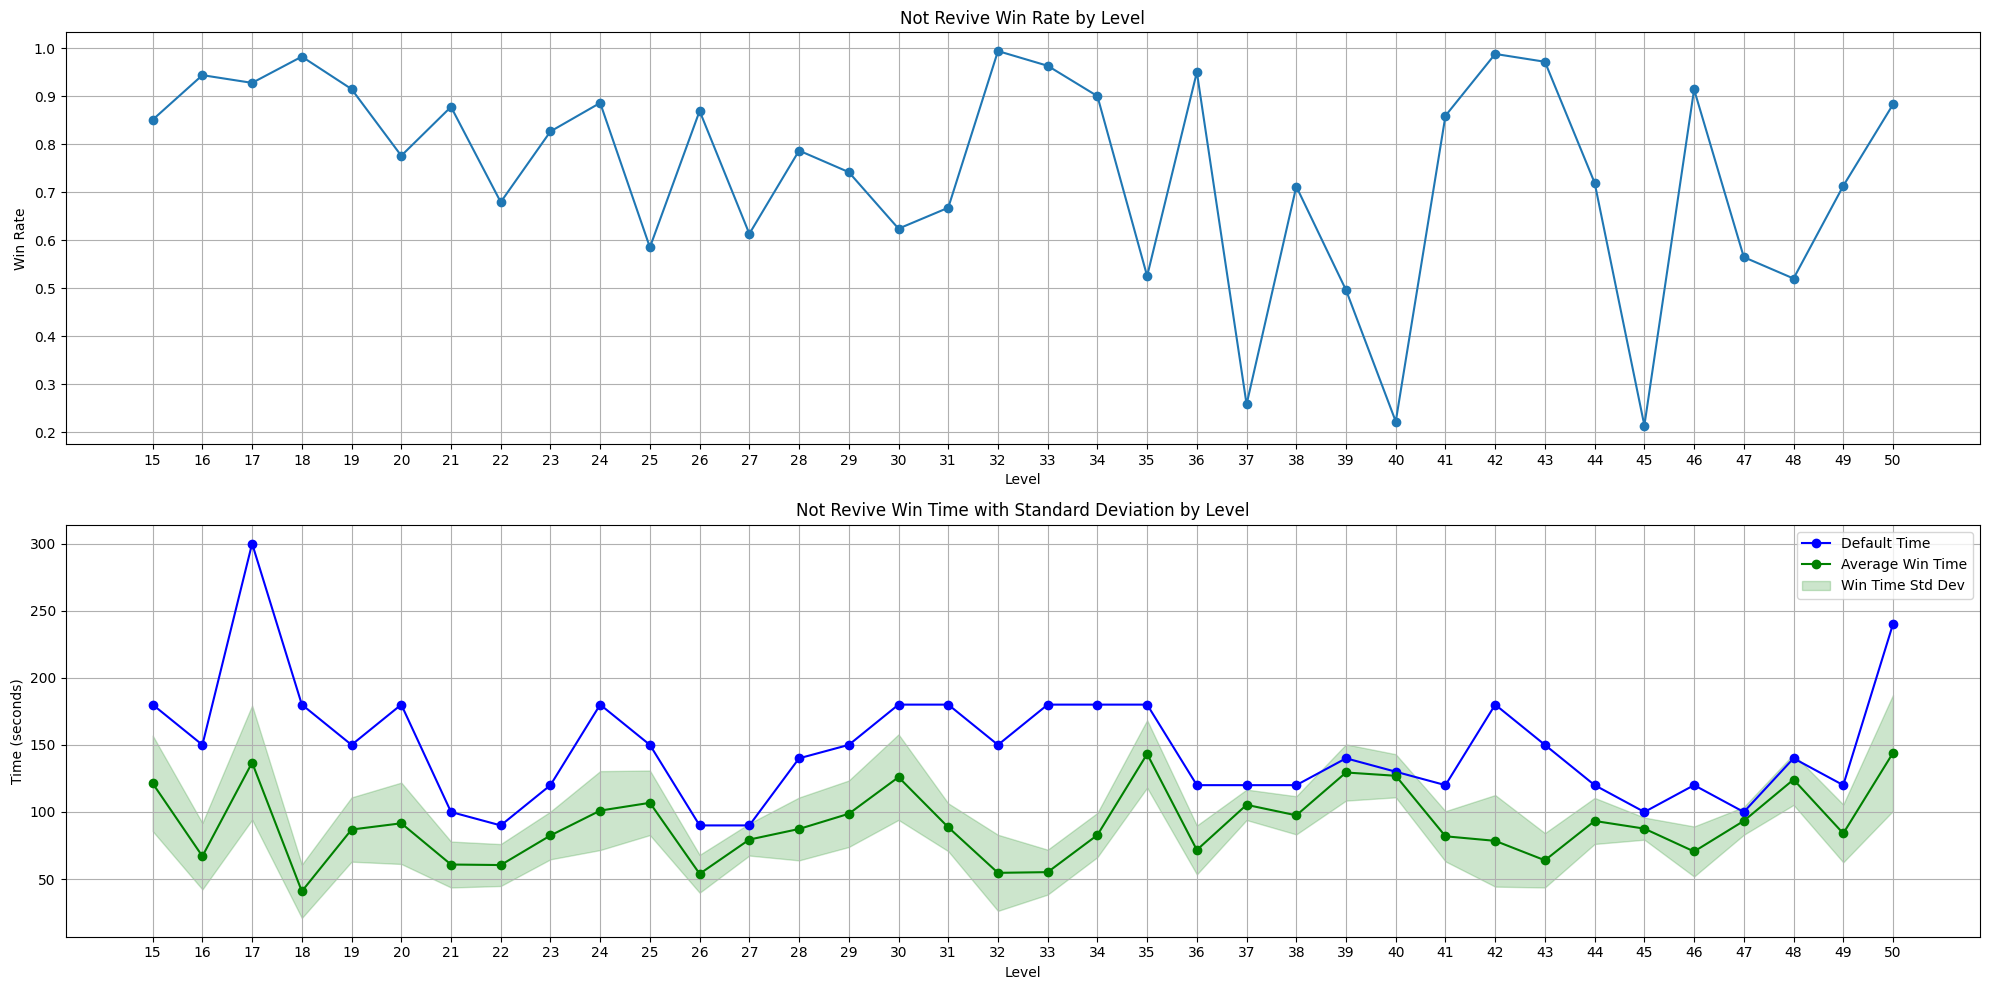

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

# Plot not revive win rate by level
ax1.plot(df_not_revive_filtered['level'], df_not_revive_filtered['not_revive_win_rate'].astype(float), marker='o')
ax1.set_title('Not Revive Win Rate by Level')
ax1.set_xlabel('Level')
ax1.set_ylabel('Win Rate')
ax1.grid(True)
ax1.set_xticks(range(15, 51))

# Plot not revive win time with standard deviation band
ax2.plot(df_not_revive_filtered['level'], df_not_revive_filtered['time_default'].astype(float), marker='o', label='Default Time', color='blue')
ax2.plot(df_not_revive_filtered['level'], df_not_revive_filtered['avg_time_win_not_revive'].astype(float), marker='o', label='Average Win Time', color='green')

# Convert to float arrays for fill_between
level = df_not_revive_filtered['level'].astype(float)
avg_time = df_not_revive_filtered['avg_time_win_not_revive'].astype(float)
std_time = df_not_revive_filtered['std_time_win_not_revive'].astype(float)

ax2.fill_between(level,
                 avg_time - std_time,
                 avg_time + std_time,
                 alpha=0.2, color='green', label='Win Time Std Dev')

ax2.set_title('Not Revive Win Time with Standard Deviation by Level')
ax2.set_xlabel('Level')
ax2.set_ylabel('Time (seconds)')
ax2.grid(True)
ax2.legend()
ax2.set_xticks(range(15, 51))

plt.tight_layout()
plt.show()


In [37]:
df_not_revive_filtered

level  time_default  start_user_not_revive  start_event_not_revive  \
0      15           180                   1576                    1767   
1      16           150                   1444                    1502   
2      17           300                   1396                    1472   
3      18           180                   1314                    1330   
4      19           150                   1282                    1366   
5      20           180                   1224                    1528   
6      21           100                   1121                    1238   
7      22            90                   1033                    1364   
8      23           120                   1017                    1184   
9      24           180                   1006                    1099   
10     25           150                    932                    1365   
11     26            90                    870                     973   
12     27            90                    737                    1035   
13     28           140                    795                     962   
14     29           150                    762                     973   
15     30           180                    747                    1054   
16     31           180                    630                     849   
17     32           150                    696                     700   
18     33           180                    691                     714   
19     34           180                    651                     713   
20     35           180                    584                     921   
21     36           120                    616                     644   
22     37           120                    447                     987   
23     38           120                    443                     573   
24     39           140                    434                     689   
25     40           130                    393                     863   
26     41           120                    372                     420   
27     42           180                    421                     426   
28     43           150                    419                     428   
29     44           120                    331                     421   
30     45           100                    274                     579   
31     46           120                    359                     385   
32     47           100                    232                     331   
33     48           140                    278                     417   
34     49           120                    351                     464   
35     50           240                    356                     393   

    win_user_not_revive  avg_time_win_not_revive  std_time_win_not_revive  \
0                  1504               121.335968                35.628223   
1                  1418                67.043478                24.740426   
2                  1366               136.799270                42.569222   
3                  1307                40.900000                19.881286   
4                  1250                86.920064                23.943166   
5                  1186                91.579966                30.312795   
6                  1087                60.859129                17.119751   
7                   927                60.474836                15.618884   
8                   979                82.511224                17.782734   
9                   974               101.036885                29.407005   
10                  799               106.841843                24.049070   
11                  846                53.940594                14.103228   
12                  635                79.457413                11.932363   
13                  757                87.358940                23.419135   
14                  722                98.679558                24.768741   
15                  658          

## df_not_booster

In [38]:
df_not_booster_filtered = df_not_booster[(df_not_booster['level'] >= 15) & (df_not_booster['level'] <= 50)]
df_not_booster_filtered['not_booster_win_rate'] = df_not_booster_filtered['win_user_not_booster'] / df_not_booster_filtered['start_event_not_booster']

/tmp/ipython-input-38-2243451967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_booster_filtered['not_booster_win_rate'] = df_not_booster_filtered['win_user_not_booster'] / df_not_booster_filtered['start_event_not_booster']


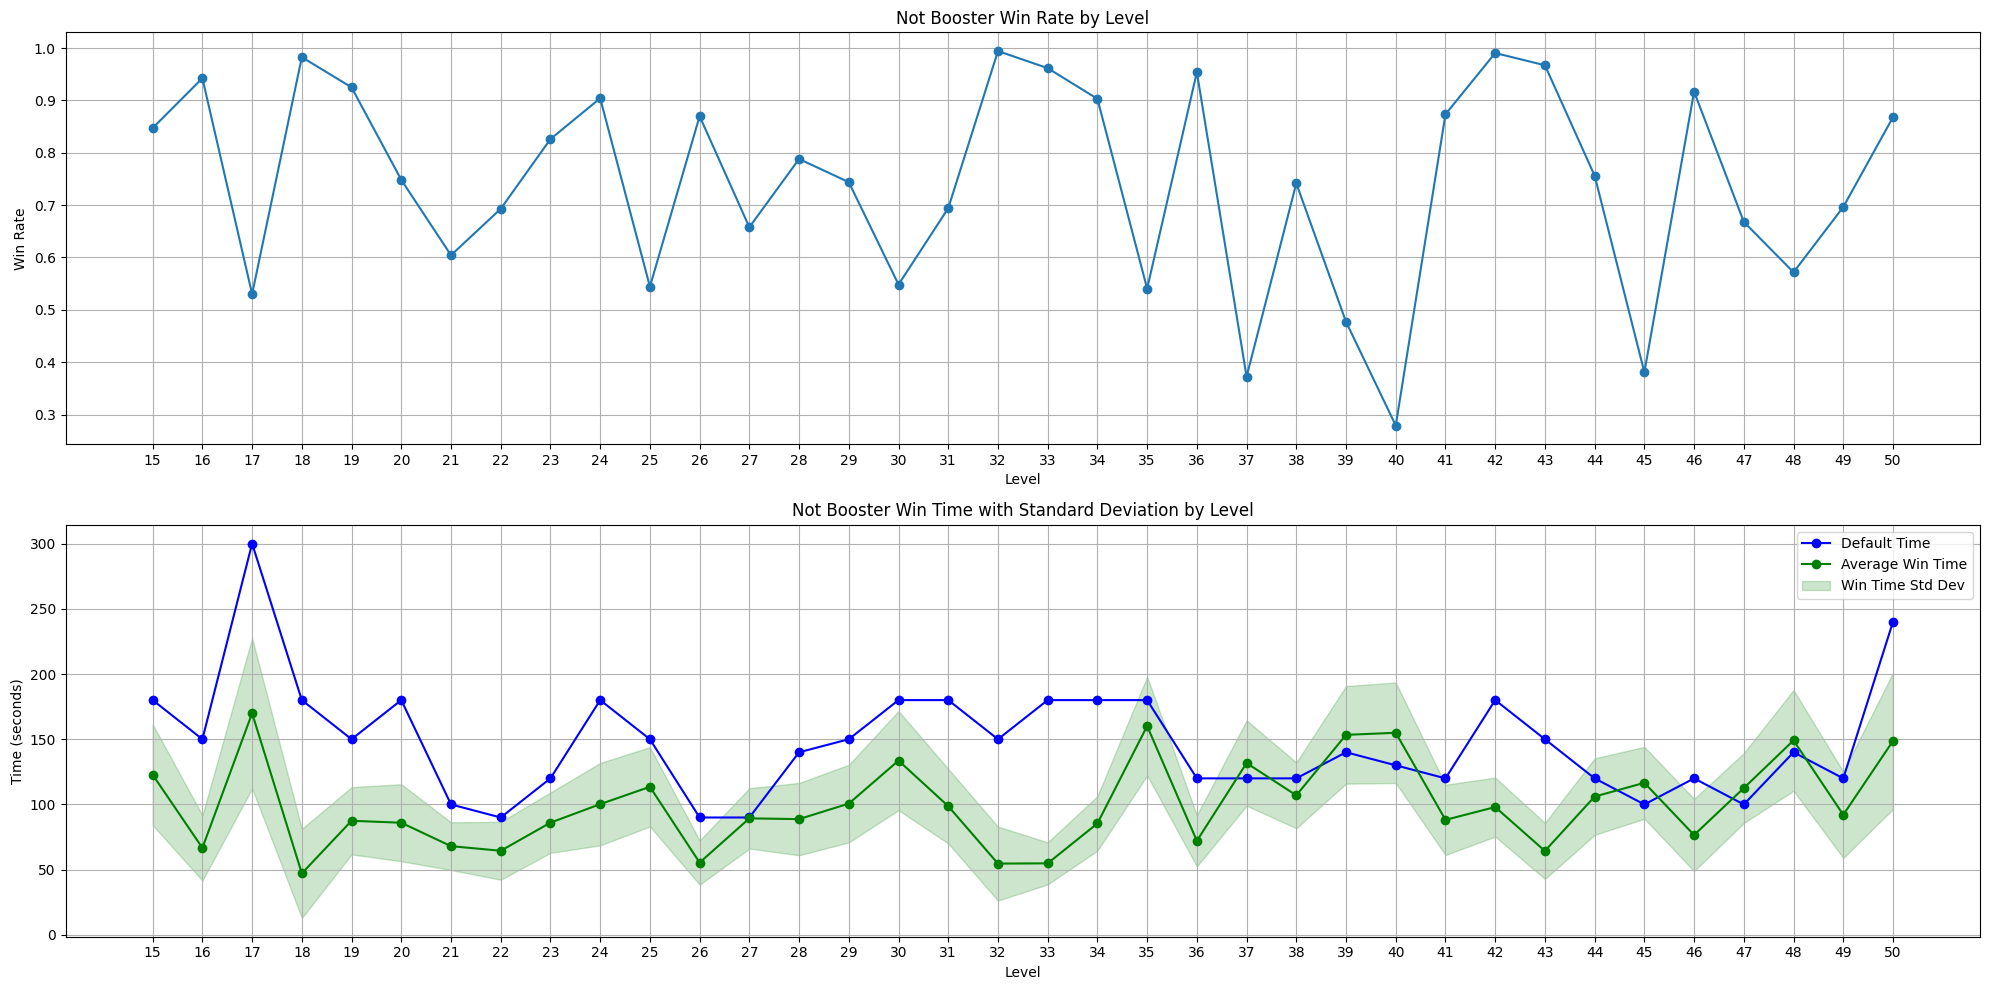

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

# Plot not revive win rate by level
ax1.plot(df_not_booster_filtered['level'], df_not_booster_filtered['not_booster_win_rate'].astype(float), marker='o')
ax1.set_title('Not Booster Win Rate by Level')
ax1.set_xlabel('Level')
ax1.set_ylabel('Win Rate')
ax1.grid(True)
ax1.set_xticks(range(15, 51))

# Plot not revive win time with standard deviation band
ax2.plot(df_not_booster_filtered['level'], df_not_booster_filtered['time_default'].astype(float), marker='o', label='Default Time', color='blue')
ax2.plot(df_not_booster_filtered['level'], df_not_booster_filtered['avg_time_win_not_booster'].astype(float), marker='o', label='Average Win Time', color='green')

# Convert to float arrays for fill_between
level = df_not_booster_filtered['level'].astype(float)
avg_time = df_not_booster_filtered['avg_time_win_not_booster'].astype(float)
std_time = df_not_booster_filtered['std_time_win_not_booster'].astype(float)

ax2.fill_between(level,
                 avg_time - std_time,
                 avg_time + std_time,
                 alpha=0.2, color='green', label='Win Time Std Dev')

ax2.set_title('Not Booster Win Time with Standard Deviation by Level')
ax2.set_xlabel('Level')
ax2.set_ylabel('Time (seconds)')
ax2.grid(True)
ax2.legend()
ax2.set_xticks(range(15, 51))

plt.tight_layout()
plt.show()


## df_not_resource

In [40]:
df_not_resource_filtered = df_not_resource[(df_not_resource['level'] >= 15) & (df_not_resource['level'] <= 50)]
df_not_resource_filtered['not_resource_win_rate'] = df_not_resource_filtered['win_user_not_resource'] / df_not_resource_filtered['start_event_not_resource']

/tmp/ipython-input-40-1311743298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_resource_filtered['not_resource_win_rate'] = df_not_resource_filtered['win_user_not_resource'] / df_not_resource_filtered['start_event_not_resource']


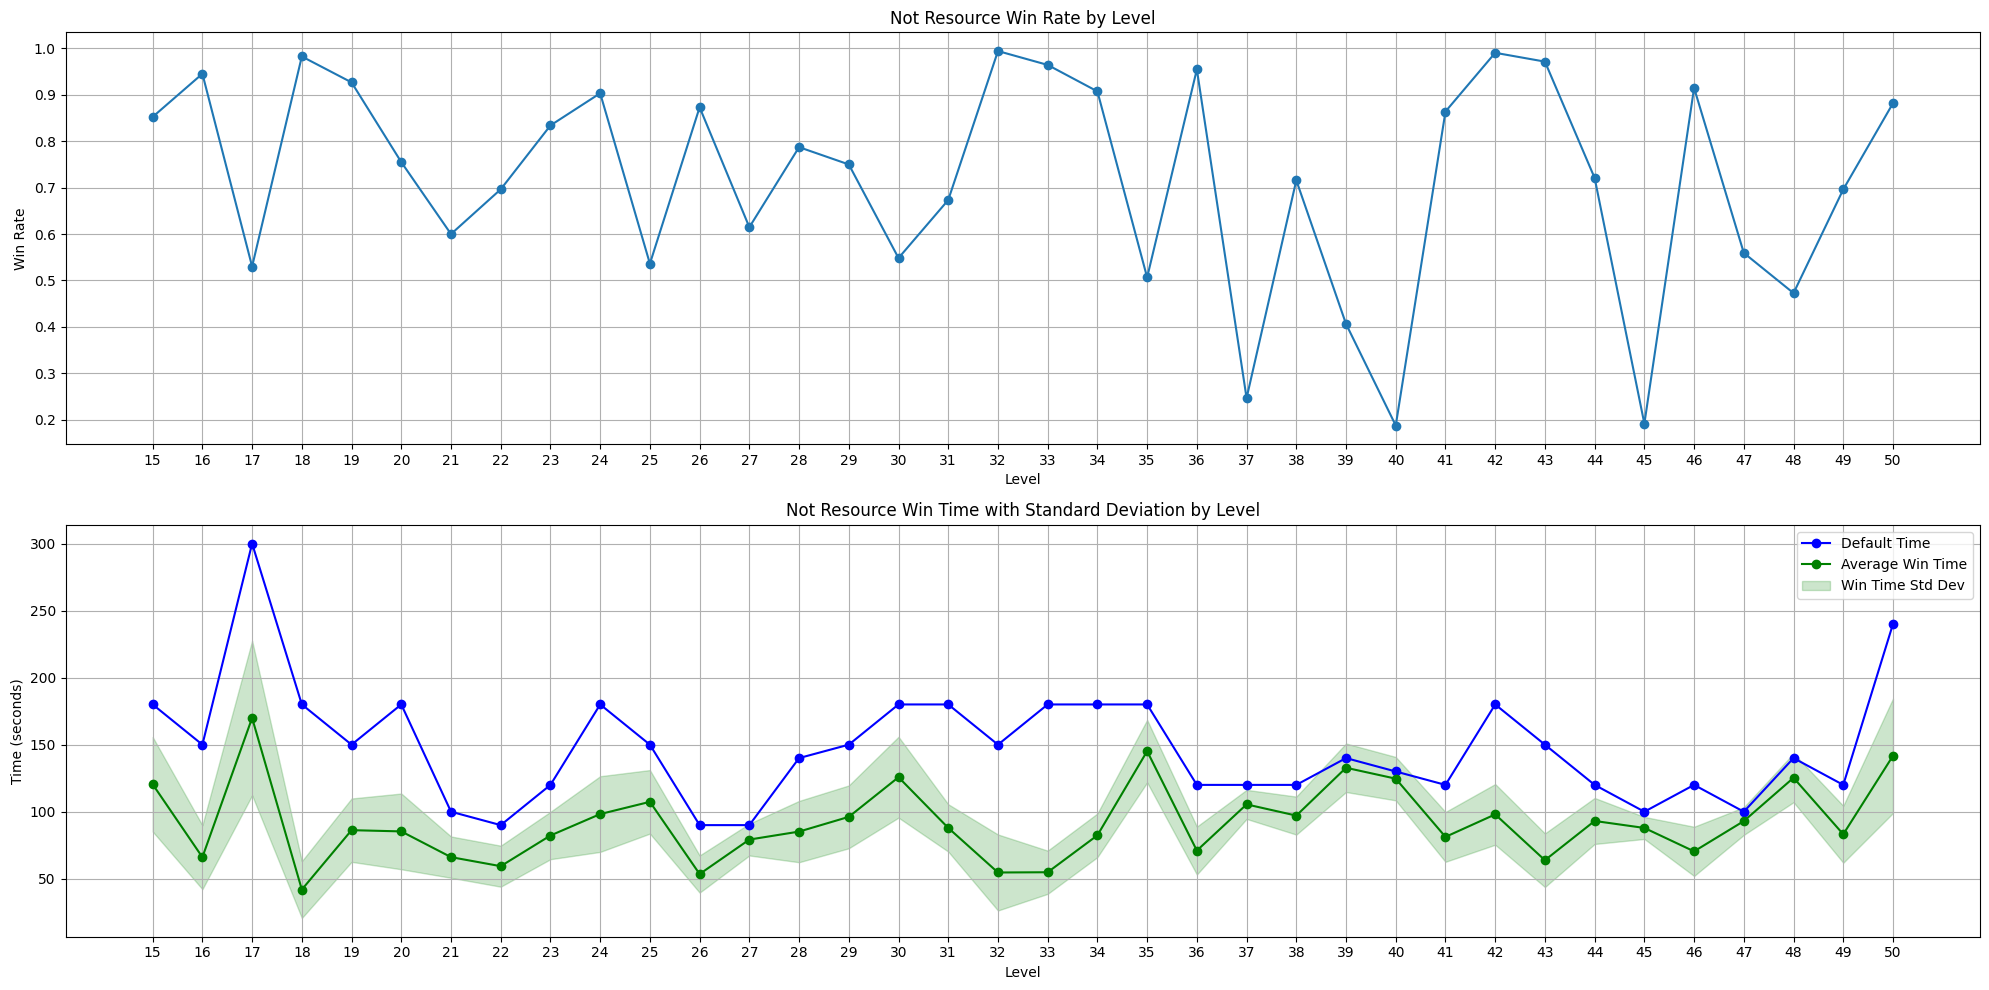

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

# Plot not revive win rate by level
ax1.plot(df_not_resource_filtered['level'], df_not_resource_filtered['not_resource_win_rate'].astype(float), marker='o')
ax1.set_title('Not Resource Win Rate by Level')
ax1.set_xlabel('Level')
ax1.set_ylabel('Win Rate')
ax1.grid(True)
ax1.set_xticks(range(15, 51))

# Plot not revive win time with standard deviation band
ax2.plot(df_not_resource_filtered['level'], df_not_resource_filtered['time_default'].astype(float), marker='o', label='Default Time', color='blue')
ax2.plot(df_not_resource_filtered['level'], df_not_resource_filtered['avg_time_win_not_resource'].astype(float), marker='o', label='Average Win Time', color='green')

# Convert to float arrays for fill_between
level = df_not_resource_filtered['level'].astype(float)
avg_time = df_not_resource_filtered['avg_time_win_not_resource'].astype(float)
std_time = df_not_resource_filtered['std_time_win_not_resource'].astype(float)

ax2.fill_between(level,
                 avg_time - std_time,
                 avg_time + std_time,
                 alpha=0.2, color='green', label='Win Time Std Dev')

ax2.set_title('Not Resource Win Time with Standard Deviation by Level')
ax2.set_xlabel('Level')
ax2.set_ylabel('Time (seconds)')
ax2.grid(True)
ax2.legend()
ax2.set_xticks(range(15, 51))

plt.tight_layout()
plt.show()


## df_reive

/tmp/ipython-input-42-3423260159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_revive_filtered['revive_win_rate'] = df_revive_filtered['win_user_revive'] / df_revive_filtered['start_event_revive']


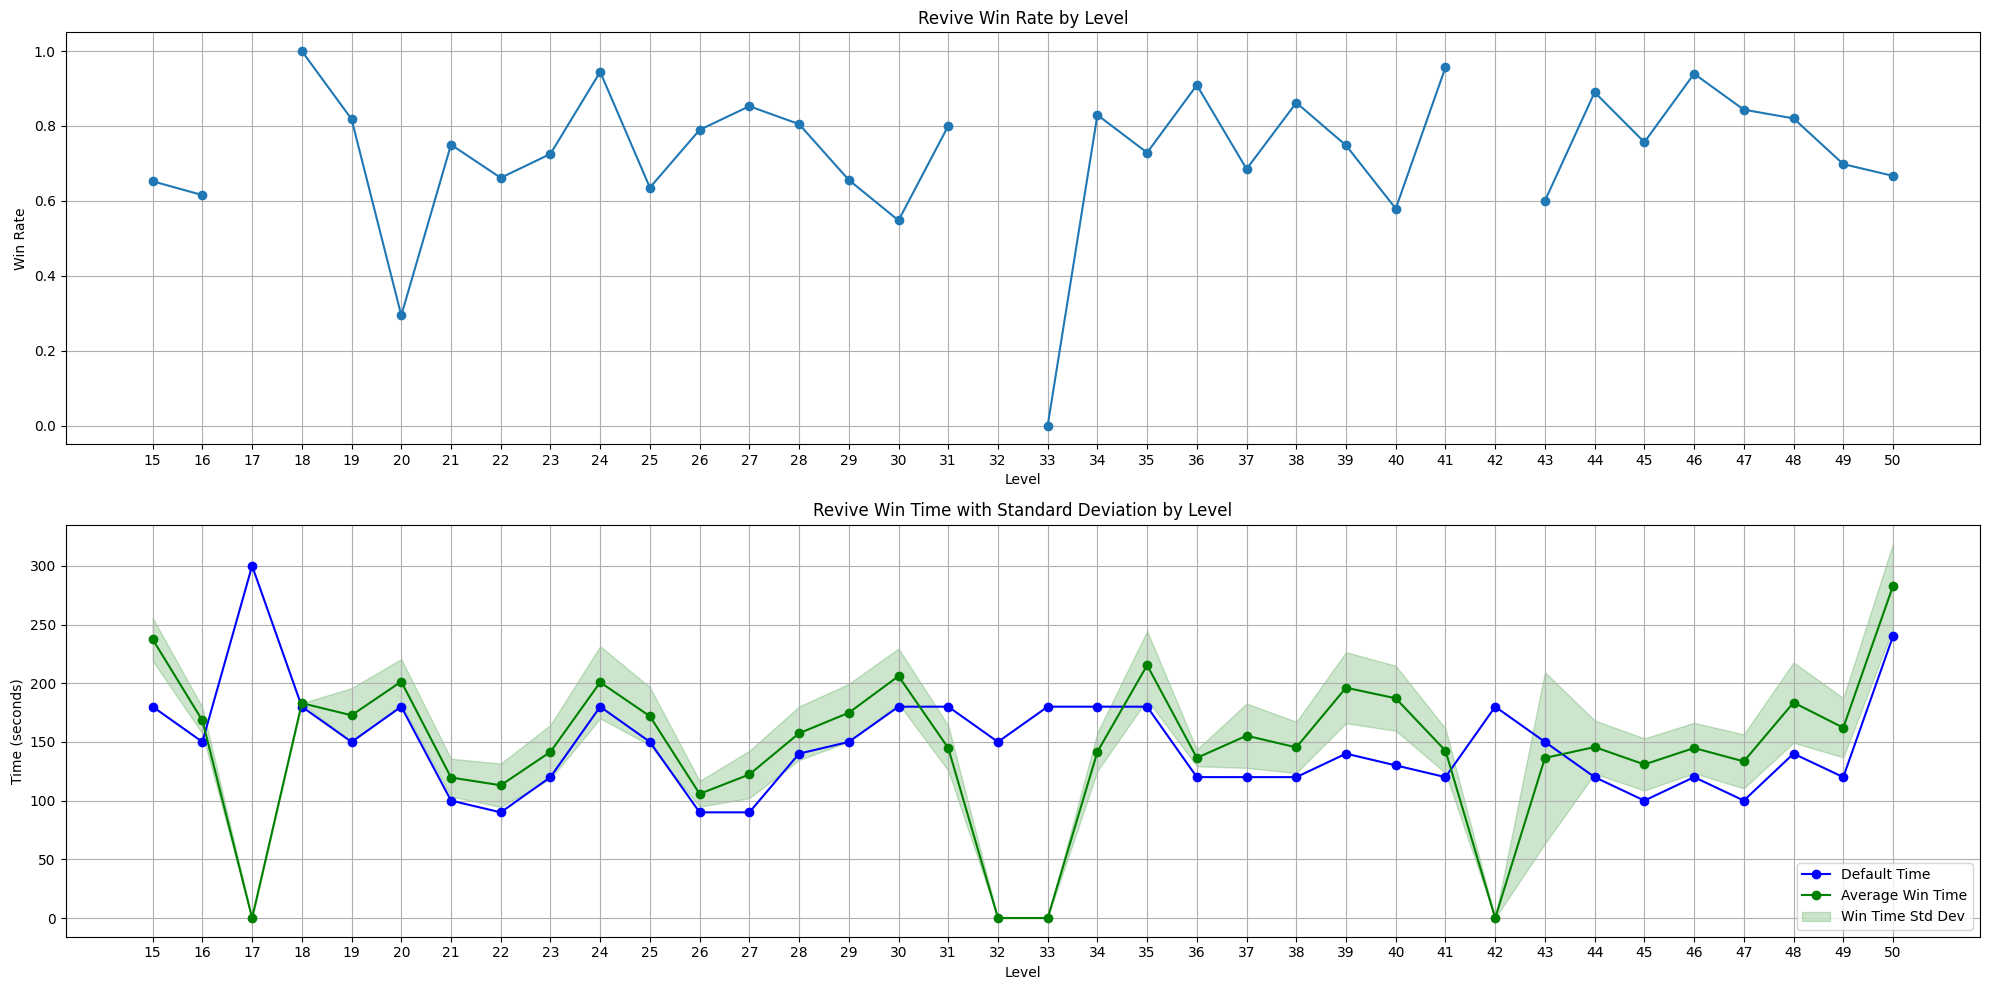

In [42]:
df_revive_filtered = df_reive[(df_reive['level'] >= 15) & (df_reive['level'] <= 50)]
df_revive_filtered['revive_win_rate'] = df_revive_filtered['win_user_revive'] / df_revive_filtered['start_event_revive']

import matplotlib.pyplot as plt
import numpy as np

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

# Plot revive win rate by level
ax1.plot(df_revive_filtered['level'], df_revive_filtered['revive_win_rate'].astype(float), marker='o')
ax1.set_title('Revive Win Rate by Level')
ax1.set_xlabel('Level')
ax1.set_ylabel('Win Rate')
ax1.grid(True)
ax1.set_xticks(range(15, 51))

# Plot revive win time with standard deviation band
ax2.plot(df_revive_filtered['level'], df_revive_filtered['time_default'].astype(float), marker='o', label='Default Time', color='blue')
ax2.plot(df_revive_filtered['level'], df_revive_filtered['avg_time_win_revive'].astype(float), marker='o', label='Average Win Time', color='green')

# Convert to float arrays for fill_between
level = df_revive_filtered['level'].astype(float)
avg_time = df_revive_filtered['avg_time_win_revive'].astype(float)
std_time = df_revive_filtered['std_time_win_revive'].astype(float)

ax2.fill_between(level,
                 avg_time - std_time,
                 avg_time + std_time,
                 alpha=0.2, color='green', label='Win Time Std Dev')

ax2.set_title('Revive Win Time with Standard Deviation by Level')
ax2.set_xlabel('Level')
ax2.set_ylabel('Time (seconds)')
ax2.grid(True)
ax2.legend()
ax2.set_xticks(range(15, 51))

plt.tight_layout()
plt.show()


In [75]:
df_revive_filtered

level  time_default  start_user_revive  start_event_revive  \
0      15           180                 41                  46   
1      16           150                 13                  13   
2      17           300                  0                   0   
3      18           180                  1                   1   
4      19           150                 22                  22   
5      20           180                 15                  17   
6      21           100                  4                   4   
7      22            90                121                 127   
8      23           120                 84                  91   
9      24           180                 18                  18   
10     25           150                 83                  85   
11     26            90                 38                  38   
12     27            90                207                 224   
13     28           140                 40                  41   
14     29           150                 53                  61   
15     30           180                 79                  84   
16     31           180                138                 155   
17     32           150                  0                   0   
18     33           180                  2                   2   
19     34           180                 40                  41   
20     35           180                111                 129   
21     36           120                 11                  11   
22     37           120                309                 365   
23     38           120                108                 116   
24     39           140                115                 131   
25     40           130                179                 221   
26     41           120                 46                  46   
27     42           180                  0                   0   
28     43           150                  4                   5   
29     44           120                103                 109   
30     45           100                225                 263   
31     46           120                 32                  33   
32     47           100                176                 198   
33     48           140                124                 139   
34     49           120                 48                  53   
35     50           240                 18                  24   

    win_user_revive  avg_time_win_revive  std_time_win_revive  \
0                30           237.366667            18.229350   
1                 8           168.250000            11.259916   
2                 0             0.000000             0.000000   
3                 1           183.000000             0.000000   
4                18           172.666667            23.156755   
5                 5           201.400000            19.217180   
6                 3           119.666667            16.072751   
7                84           113.059524            18.503240   
8                66           141.500000            22.950281   
9                17           200.764706            30.764284   
10               54           171.870370            24.709670   
11               30           105.733333            11.023277   
12              191           122.267016            20.169464   
13               33           157.363636            22.833389   
14               40           174.825000            24.651299   
15               46           206.042553            23.489089   
16              124           144.792000            19.204878   
17                0             0.000000             0.000000   
18                0             0.000000             0.000000   
19               34           141.588235            16.407902   
20               94           215.305263            29.228765   
21               10           136.400000             7.136759   
22              250           155.276000            27.413094   
2

## df_booster

/tmp/ipython-input-43-1458151513.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_booster_filtered['booster_win_rate'] = df_booster_filtered['win_user_booster'] / df_booster_filtered['start_event_booster']


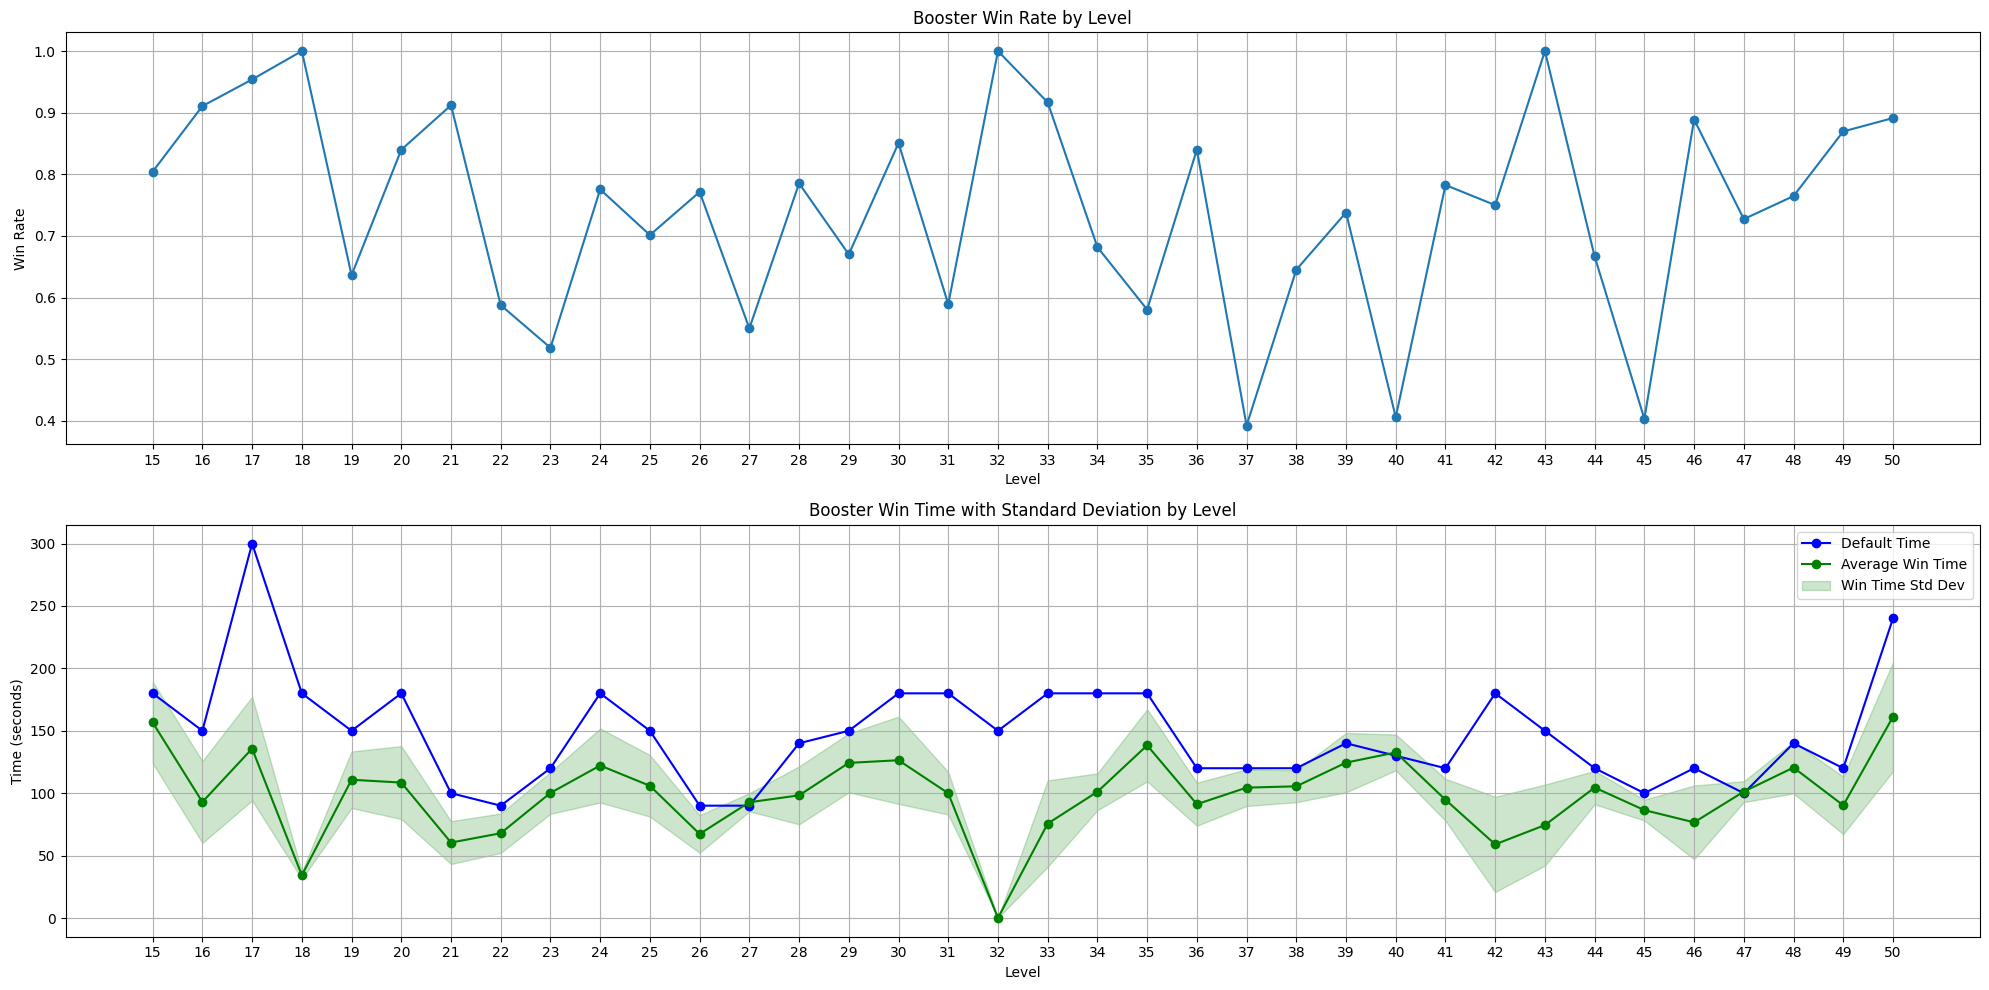

In [43]:
df_booster_filtered = df_booster[(df_booster['level'] >= 15) & (df_booster['level'] <= 50)]
df_booster_filtered['booster_win_rate'] = df_booster_filtered['win_user_booster'] / df_booster_filtered['start_event_booster']

import matplotlib.pyplot as plt
import numpy as np

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

# Plot booster win rate by level
ax1.plot(df_booster_filtered['level'], df_booster_filtered['booster_win_rate'].astype(float), marker='o')
ax1.set_title('Booster Win Rate by Level')
ax1.set_xlabel('Level')
ax1.set_ylabel('Win Rate')
ax1.grid(True)
ax1.set_xticks(range(15, 51))

# Plot booster win time with standard deviation band
ax2.plot(df_booster_filtered['level'], df_booster_filtered['time_default'].astype(float), marker='o', label='Default Time', color='blue')
ax2.plot(df_booster_filtered['level'], df_booster_filtered['avg_time_win_booster'].astype(float), marker='o', label='Average Win Time', color='green')

# Convert to float arrays for fill_between
level = df_booster_filtered['level'].astype(float)
avg_time = df_booster_filtered['avg_time_win_booster'].astype(float)
std_time = df_booster_filtered['std_time_win_booster'].astype(float)

ax2.fill_between(level,
                 avg_time - std_time,
                 avg_time + std_time,
                 alpha=0.2, color='green', label='Win Time Std Dev')

ax2.set_title('Booster Win Time with Standard Deviation by Level')
ax2.set_xlabel('Level')
ax2.set_ylabel('Time (seconds)')
ax2.grid(True)
ax2.legend()
ax2.set_xticks(range(15, 51))

plt.tight_layout()
plt.show()


## df_revive_booster

/tmp/ipython-input-44-2820971224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_revive_booster_filtered['revive_booster_win_rate'] = df_revive_booster_filtered['win_user_booster_revive'] / df_revive_booster_filtered['start_event_revive_booster']


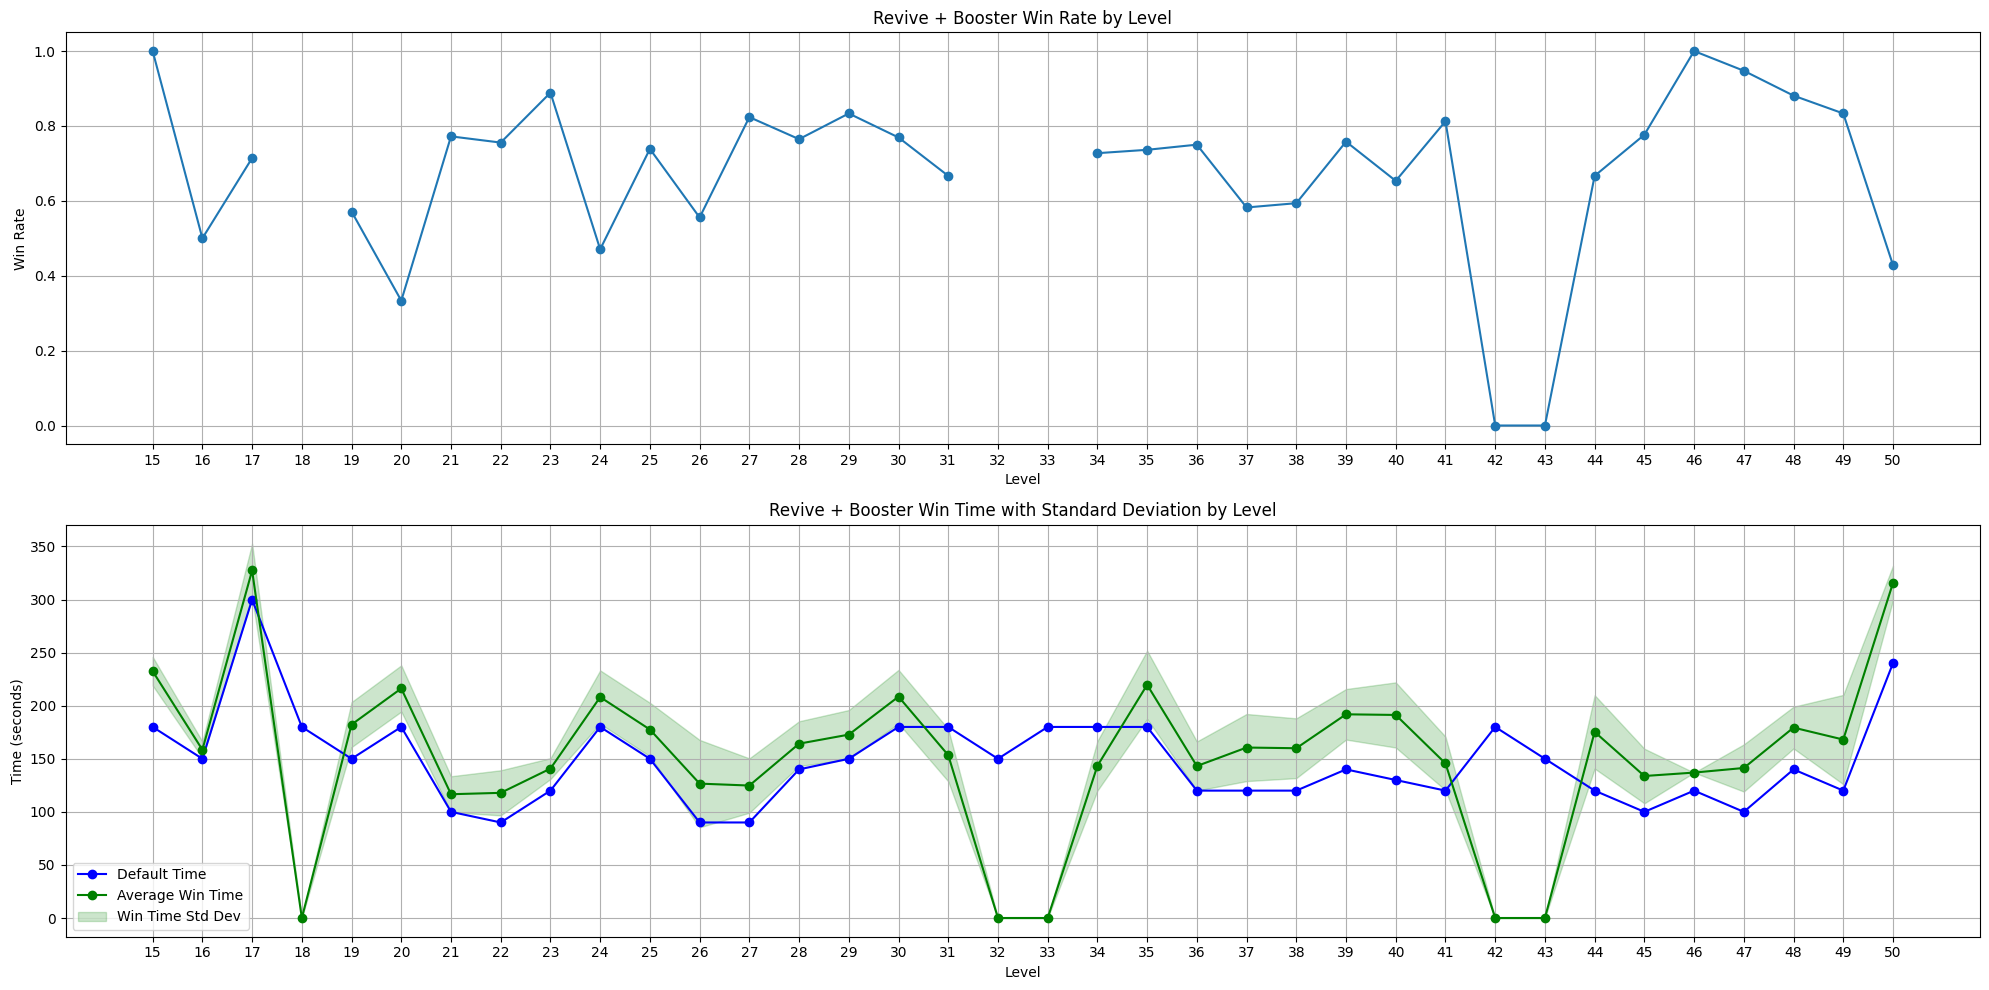

In [44]:
df_revive_booster_filtered = df_revive_booster[(df_revive_booster['level'] >= 15) & (df_revive_booster['level'] <= 50)]
df_revive_booster_filtered['revive_booster_win_rate'] = df_revive_booster_filtered['win_user_booster_revive'] / df_revive_booster_filtered['start_event_revive_booster']

import matplotlib.pyplot as plt
import numpy as np

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

# Plot revive_booster win rate by level
ax1.plot(df_revive_booster_filtered['level'], df_revive_booster_filtered['revive_booster_win_rate'].astype(float), marker='o')
ax1.set_title('Revive + Booster Win Rate by Level')
ax1.set_xlabel('Level')
ax1.set_ylabel('Win Rate')
ax1.grid(True)
ax1.set_xticks(range(15, 51))

# Plot revive_booster win time with standard deviation band
ax2.plot(df_revive_booster_filtered['level'], df_revive_booster_filtered['time_default'].astype(float), marker='o', label='Default Time', color='blue')
ax2.plot(df_revive_booster_filtered['level'], df_revive_booster_filtered['avg_time_win_booster_revive'].astype(float), marker='o', label='Average Win Time', color='green')

# Convert to float arrays for fill_between
level = df_revive_booster_filtered['level'].astype(float)
avg_time = df_revive_booster_filtered['avg_time_win_booster_revive'].astype(float)
std_time = df_revive_booster_filtered['std_time_win_booster_revive'].astype(float)

ax2.fill_between(level,
                 avg_time - std_time,
                 avg_time + std_time,
                 alpha=0.2, color='green', label='Win Time Std Dev')

ax2.set_title('Revive + Booster Win Time with Standard Deviation by Level')
ax2.set_xlabel('Level')
ax2.set_ylabel('Time (seconds)')
ax2.grid(True)
ax2.legend()
ax2.set_xticks(range(15, 51))

plt.tight_layout()
plt.show()


## df_att1

/tmp/ipython-input-45-472032207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_att1_filtered['att1_win_rate'] = df_att1_filtered['win_user_att1'] / df_att1_filtered['start_event_att1']


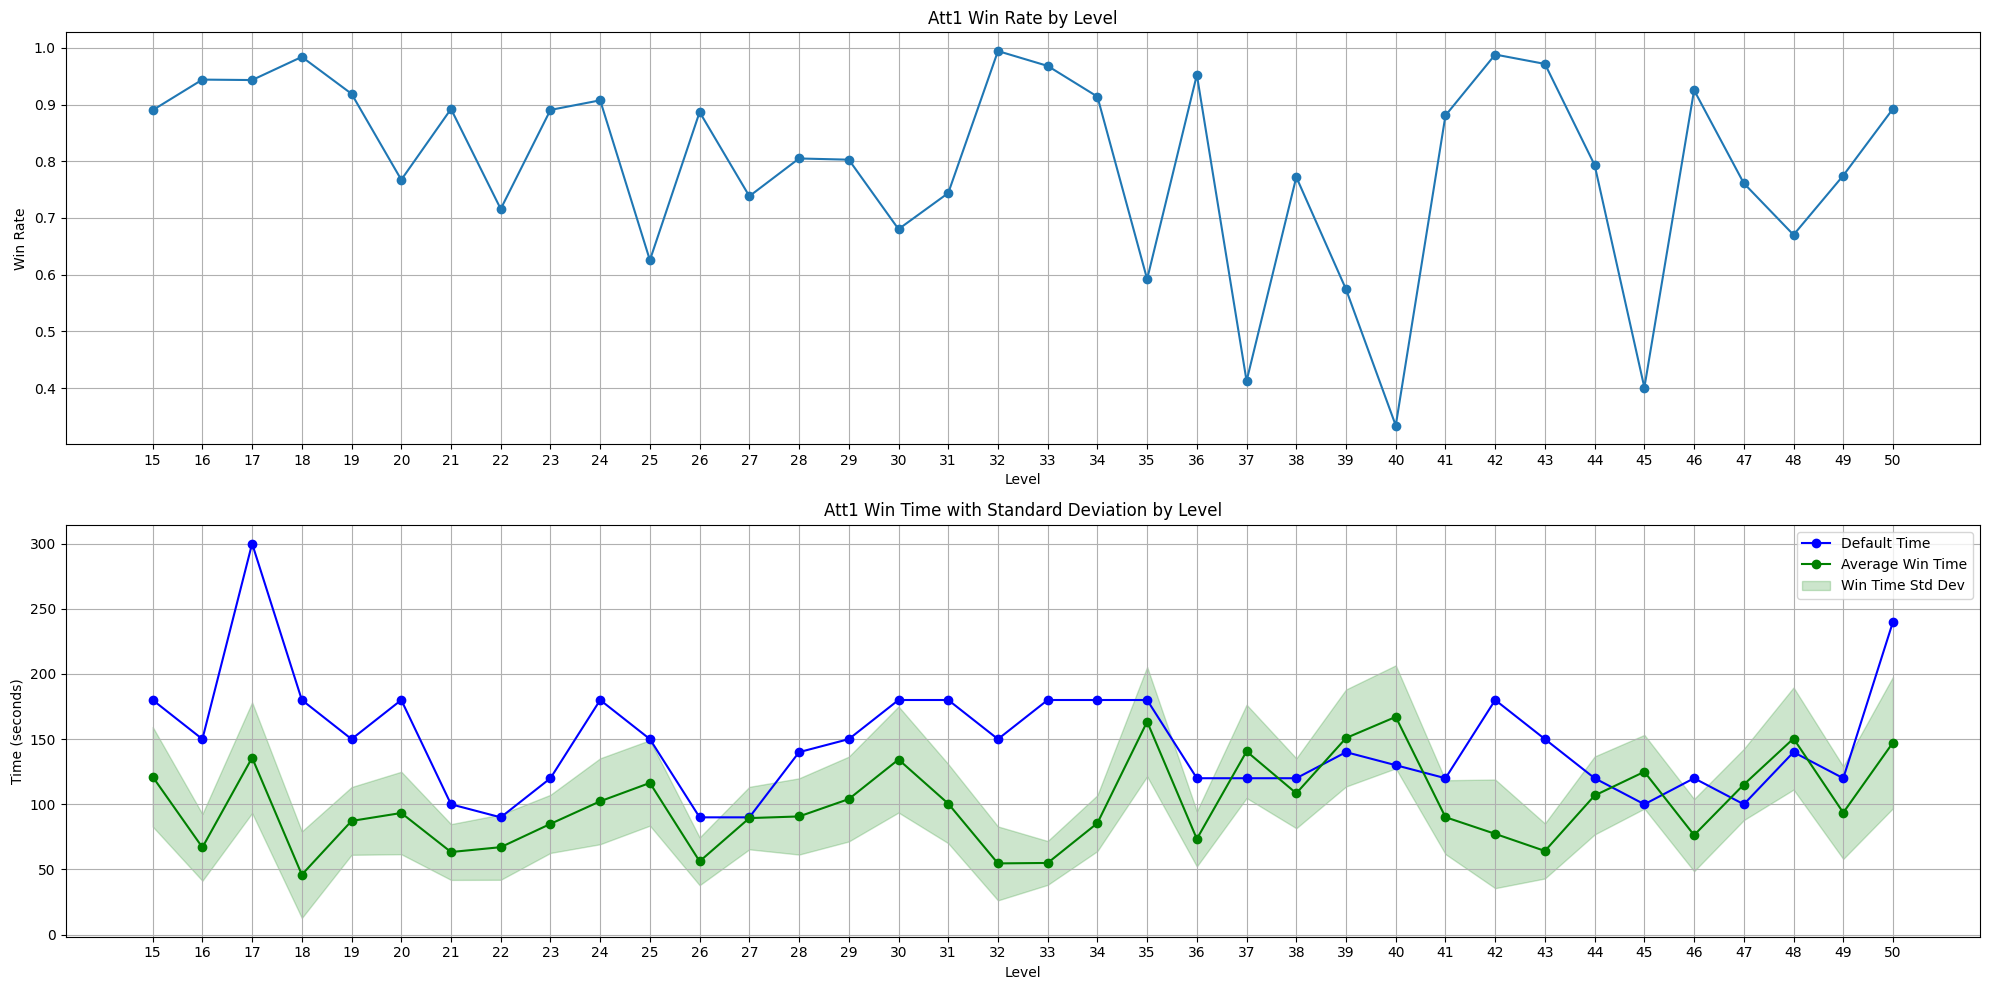

In [45]:
df_att1_filtered = df_att1[(df_att1['level'] >= 15) & (df_att1['level'] <= 50)]
df_att1_filtered['att1_win_rate'] = df_att1_filtered['win_user_att1'] / df_att1_filtered['start_event_att1']

import matplotlib.pyplot as plt
import numpy as np

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

# Plot att1 win rate by level
ax1.plot(df_att1_filtered['level'], df_att1_filtered['att1_win_rate'].astype(float), marker='o')
ax1.set_title('Att1 Win Rate by Level')
ax1.set_xlabel('Level')
ax1.set_ylabel('Win Rate')
ax1.grid(True)
ax1.set_xticks(range(15, 51))

# Plot att1 win time with standard deviation band
ax2.plot(df_att1_filtered['level'], df_att1_filtered['time_default'].astype(float), marker='o', label='Default Time', color='blue')
ax2.plot(df_att1_filtered['level'], df_att1_filtered['avg_time_play_att1'].astype(float), marker='o', label='Average Win Time', color='green')

# Convert to float arrays for fill_between
level = df_att1_filtered['level'].astype(float)
avg_time = df_att1_filtered['avg_time_play_att1'].astype(float)
std_time = df_att1_filtered['std_time_play_att1'].astype(float)

ax2.fill_between(level,
                 avg_time - std_time,
                 avg_time + std_time,
                 alpha=0.2, color='green', label='Win Time Std Dev')

ax2.set_title('Att1 Win Time with Standard Deviation by Level')
ax2.set_xlabel('Level')
ax2.set_ylabel('Time (seconds)')
ax2.grid(True)
ax2.legend()
ax2.set_xticks(range(15, 51))

plt.tight_layout()
plt.show()


In [77]:
df_att1_filtered

level  time_default  start_user_att1  start_event_att1  win_user_att1  \
0      15           180             1573              1573           1400   
1      16           150             1444              1444           1363   
2      17           300             1389              1389           1310   
3      18           180             1309              1309           1288   
4      19           150             1294              1294           1189   
5      20           180             1216              1216            933   
6      21           100             1168              1168           1042   
7      22            90             1126              1126            806   
8      23           120             1059              1059            943   
9      24           180             1015              1015            921   
10     25           150              980               980            613   
11     26            90              900               900            798   
12     27            90              856               856            632   
13     28           140              825               825            664   
14     29           150              806               806            647   
15     30           180              785               785            534   
16     31           180              734               734            546   
17     32           150              695               695            691   
18     33           180              688               688            666   
19     34           180              685               685            626   
20     35           180              679               679            402   
21     36           120              629               629            599   
22     37           120              623               623            257   
23     38           120              544               544            420   
24     39           140              526               526            302   
25     40           130              482               482            161   
26     41           120              419               419            369   
27     42           180              420               420            415   
28     43           150              422               422            410   
29     44           120              411               411            326   
30     45           100              409               409            164   
31     46           120              388               388            359   
32     47           100              381               381            290   
33     48           140              379               379            254   
34     49           120              373               373            289   
35     50           240              372               372            332   

    avg_time_play_att1  std_time_play_att1  max_time_play_att1  \
0           121.130714           38.219739                 277   
1            66.950223           25.602185                 183   
2           135.755725           42.485982                 360   
3            46.000000           33.211444                 183   
4            87.238856           25.984588                 251   
5            93.335477           31.632547                 244   
6            63.390716           21.396097                 185   
7            67.115144           25.030343                 178   
8            84.988335           22.303563                 221   
9           102.323561           32.955167                 313   
10          116.393791           32.789416                 276   
11           56.253281           18.327296                 196   
12           89.424723           23.960489                 200   
13           90.683258           29.244037                 229   
14          104.010819           32.527791                 277   
15          134.346442           40.682611                 305   
16          100.507326          

## df_att2

/tmp/ipython-input-46-439402356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_att2_filtered['att2_win_rate'] = df_att2_filtered['win_user_att2'] / df_att2_filtered['start_event_att2']


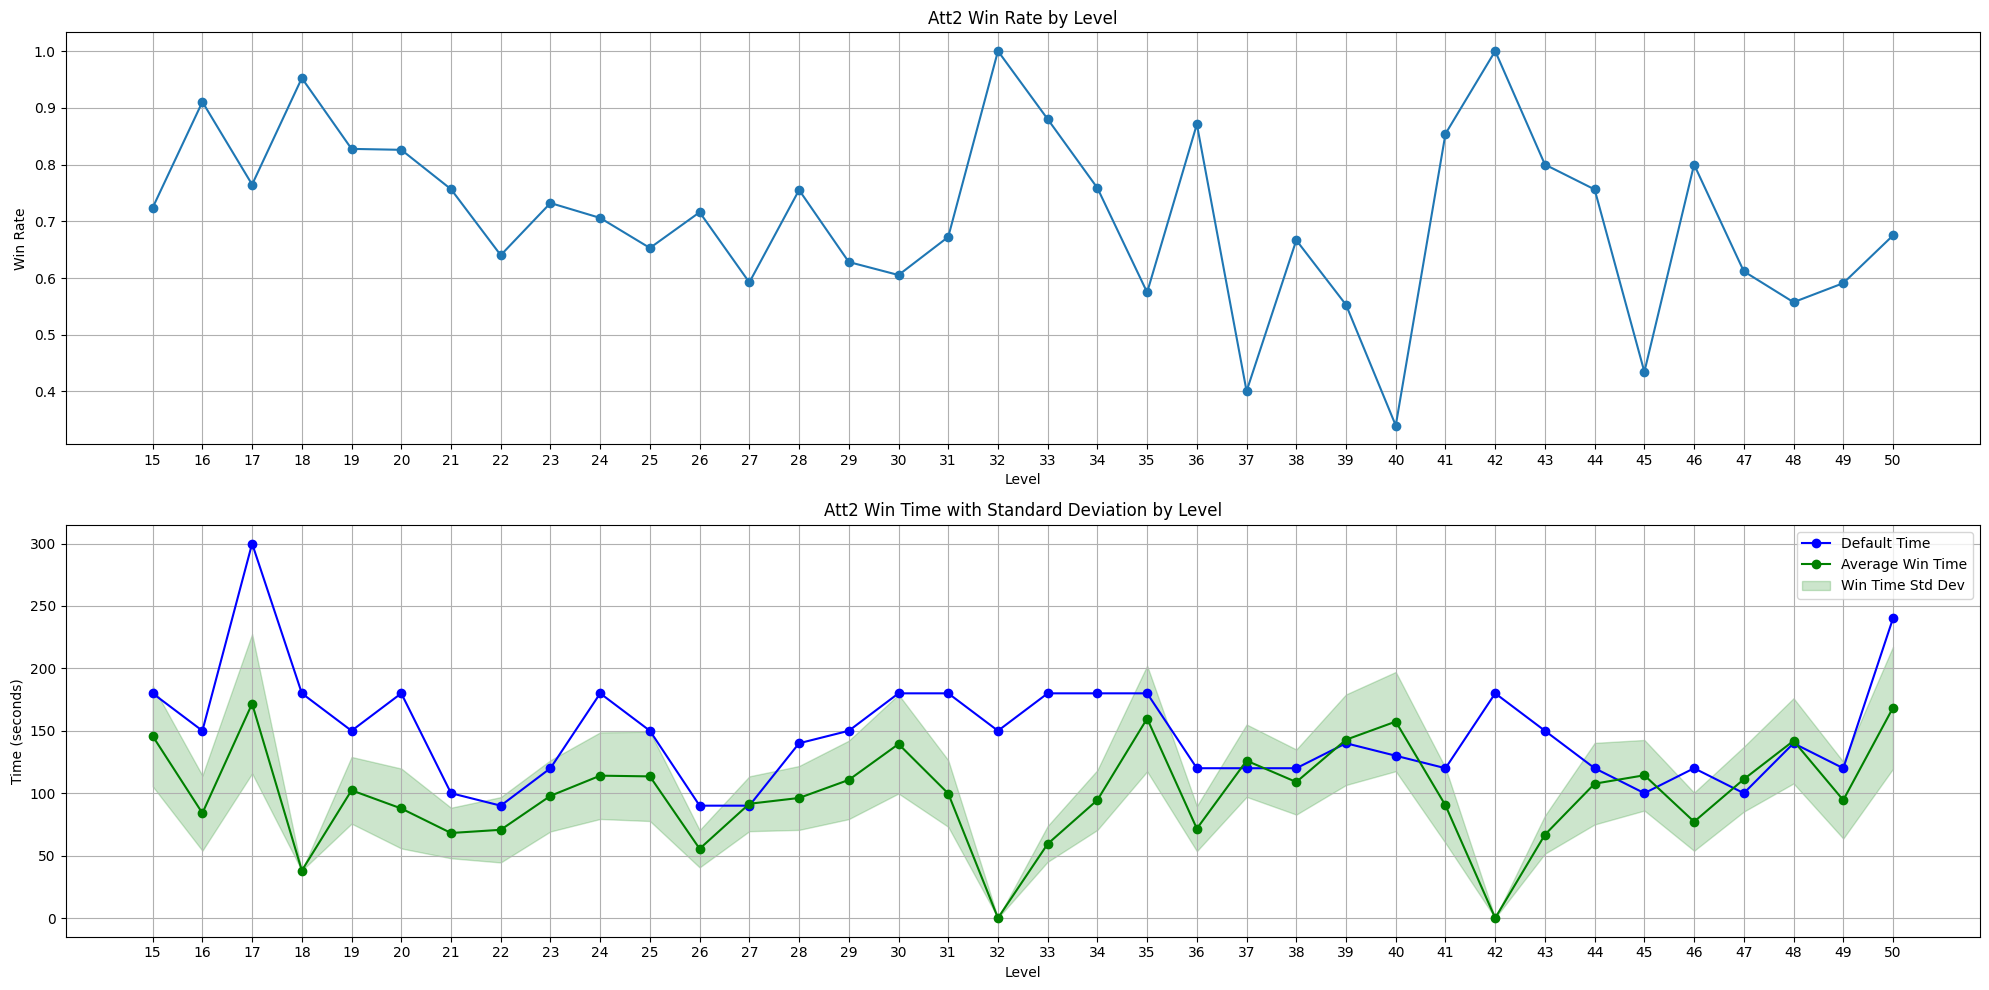

In [46]:
df_att2_filtered = df_att2[(df_att2['level'] >= 15) & (df_att2['level'] <= 50)]
df_att2_filtered['att2_win_rate'] = df_att2_filtered['win_user_att2'] / df_att2_filtered['start_event_att2']

import matplotlib.pyplot as plt
import numpy as np

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

# Plot att2 win rate by level
ax1.plot(df_att2_filtered['level'], df_att2_filtered['att2_win_rate'].astype(float), marker='o')
ax1.set_title('Att2 Win Rate by Level')
ax1.set_xlabel('Level')
ax1.set_ylabel('Win Rate')
ax1.grid(True)
ax1.set_xticks(range(15, 51))

# Plot att2 win time with standard deviation band
ax2.plot(df_att2_filtered['level'], df_att2_filtered['time_default'].astype(float), marker='o', label='Default Time', color='blue')
ax2.plot(df_att2_filtered['level'], df_att2_filtered['avg_time_play_att2'].astype(float), marker='o', label='Average Win Time', color='green')

# Convert to float arrays for fill_between
level = df_att2_filtered['level'].astype(float)
avg_time = df_att2_filtered['avg_time_play_att2'].astype(float)
std_time = df_att2_filtered['std_time_play_att2'].astype(float)

ax2.fill_between(level,
                 avg_time - std_time,
                 avg_time + std_time,
                 alpha=0.2, color='green', label='Win Time Std Dev')

ax2.set_title('Att2 Win Time with Standard Deviation by Level')
ax2.set_xlabel('Level')
ax2.set_ylabel('Time (seconds)')
ax2.grid(True)
ax2.legend()
ax2.set_xticks(range(15, 51))

plt.tight_layout()
plt.show()


In [76]:
df_att2_filtered

level  time_default  start_user_att2  start_event_att2  win_user_att2  \
0      15           180              163               163            118   
1      16           150               67                67             61   
2      17           300               68                68             52   
3      18           180               21                21             20   
4      19           150               87                87             72   
5      20           180              270               270            223   
6      21           100              115               115             87   
7      22            90              303               303            194   
8      23           120              112               112             82   
9      24           180               85                85             60   
10     25           150              340               340            222   
11     26            90               88                88             63   
12     27            90              206               206            122   
13     28           140              147               147            111   
14     29           150              156               156             98   
15     30           180              228               228            138   
16     31           180              174               174            117   
17     32           150                5                 5              5   
18     33           180               25                25             22   
19     34           180               58                58             44   
20     35           180              261               261            150   
21     36           120               31                31             27   
22     37           120              332               332            133   
23     38           120              111               111             74   
24     39           140              199               199            110   
25     40           130              297               297            101   
26     41           120               48                48             41   
27     42           180                5                 5              5   
28     43           150               10                10              8   
29     44           120               82                82             62   
30     45           100              237               237            103   
31     46           120               25                25             20   
32     47           100               85                85             52   
33     48           140              122               122             68   
34     49           120               88                88             52   
35     50           240               40                40             27   

    avg_time_play_att2  std_time_play_att2  max_time_play_att2  \
0           145.773109           40.326724                 257   
1            84.016129           30.098468                 163   
2           171.698113           55.885042                 290   
3            38.000000            0.000000                  38   
4           102.305556           26.713735                 191   
5            87.735426           31.995452                 200   
6            68.103448           20.242159                 139   
7            70.661376           26.169489                 180   
8            97.865854           28.537938                 203   
9           114.033333           34.694779                 205   
10          113.463964           35.772990                 246   
11           55.475410           14.953937                 105   
12           91.516393           21.971895                 171   
13           96.172727           25.586285                 182   
14          110.642857           31.419755                 202   
15          139.364964           39.640271                 265   
16           99.728814          

# Conclusion

In [47]:
df_check = df_filtered[[
    'level',
    'win_user_general',
    'win_user_not_revive',
    'win_user_not_booster',
    'win_user_not_resource',
    'win_user_revive',
    'win_user_booster',
    'win_user_booster_revive',
    'win_user_att1',
    'win_user_att2'
]]
df_check = df_check[df_check['level'] <= 50]

In [48]:
df_check

level  win_user_general  win_user_not_revive  win_user_not_booster  \
0      15              1541                 1504                  1497   
1      16              1429                 1418                  1375   
2      17              1372                 1366                    44   
3      18              1311                 1307                  1301   
4      19              1272                 1250                  1233   
5      20              1195                 1186                   871   
6      21              1151                 1087                    84   
7      22              1081                  927                   887   
8      23              1054                  979                  1031   
9      24              1000                  974                   877   
10     25               920                  799                   565   
11     26               881                  846                   849   
12     27               840                  635                   815   
13     28               805                  757                   662   
14     29               793                  722                   697   
15     30               744                  658                   477   
16     31               714                  567                   658   
17     32               696                  696                   695   
18     33               688                  688                   677   
19     34               686                  642                   661   
20     35               644                  484                   440   
21     36               628                  612                   601   
22     37               551                  255                   474   
23     38               527                  408                   488   
24     39               487                  342                   302   
25     40               420                  192                   264   
26     41               420                  361                   387   
27     42               421                  421                   418   
28     43               419                  416                   412   
29     44               406                  303                   394   
30     45               389                  124                   297   
31     46               384                  352                   375   
32     47               372                  187                   346   
33     48               369                  217                   279   
34     49               378                  331                   328   
35     50               366                  347                   322   

    win_user_not_resource  win_user_revive  win_user_booster  \
0                    1467               30                37   
1                    1367                8                51   
2                      44                0              1325   
3                    1300                1                 7   
4                    1215               18                35   
5                     866                5               320   
6                      81                3              1006   
7                     803               84               124   
8                     965               66                14   
9                     860               17               114   
10                    511               54               289   
11                    819               30                27   
12                    624              191                11   
13                    629               33               128   
14                    657               40                65   
15                    431               46               228   
16                    534              124                33   
17                    695                0                 1   
18                    677                0       

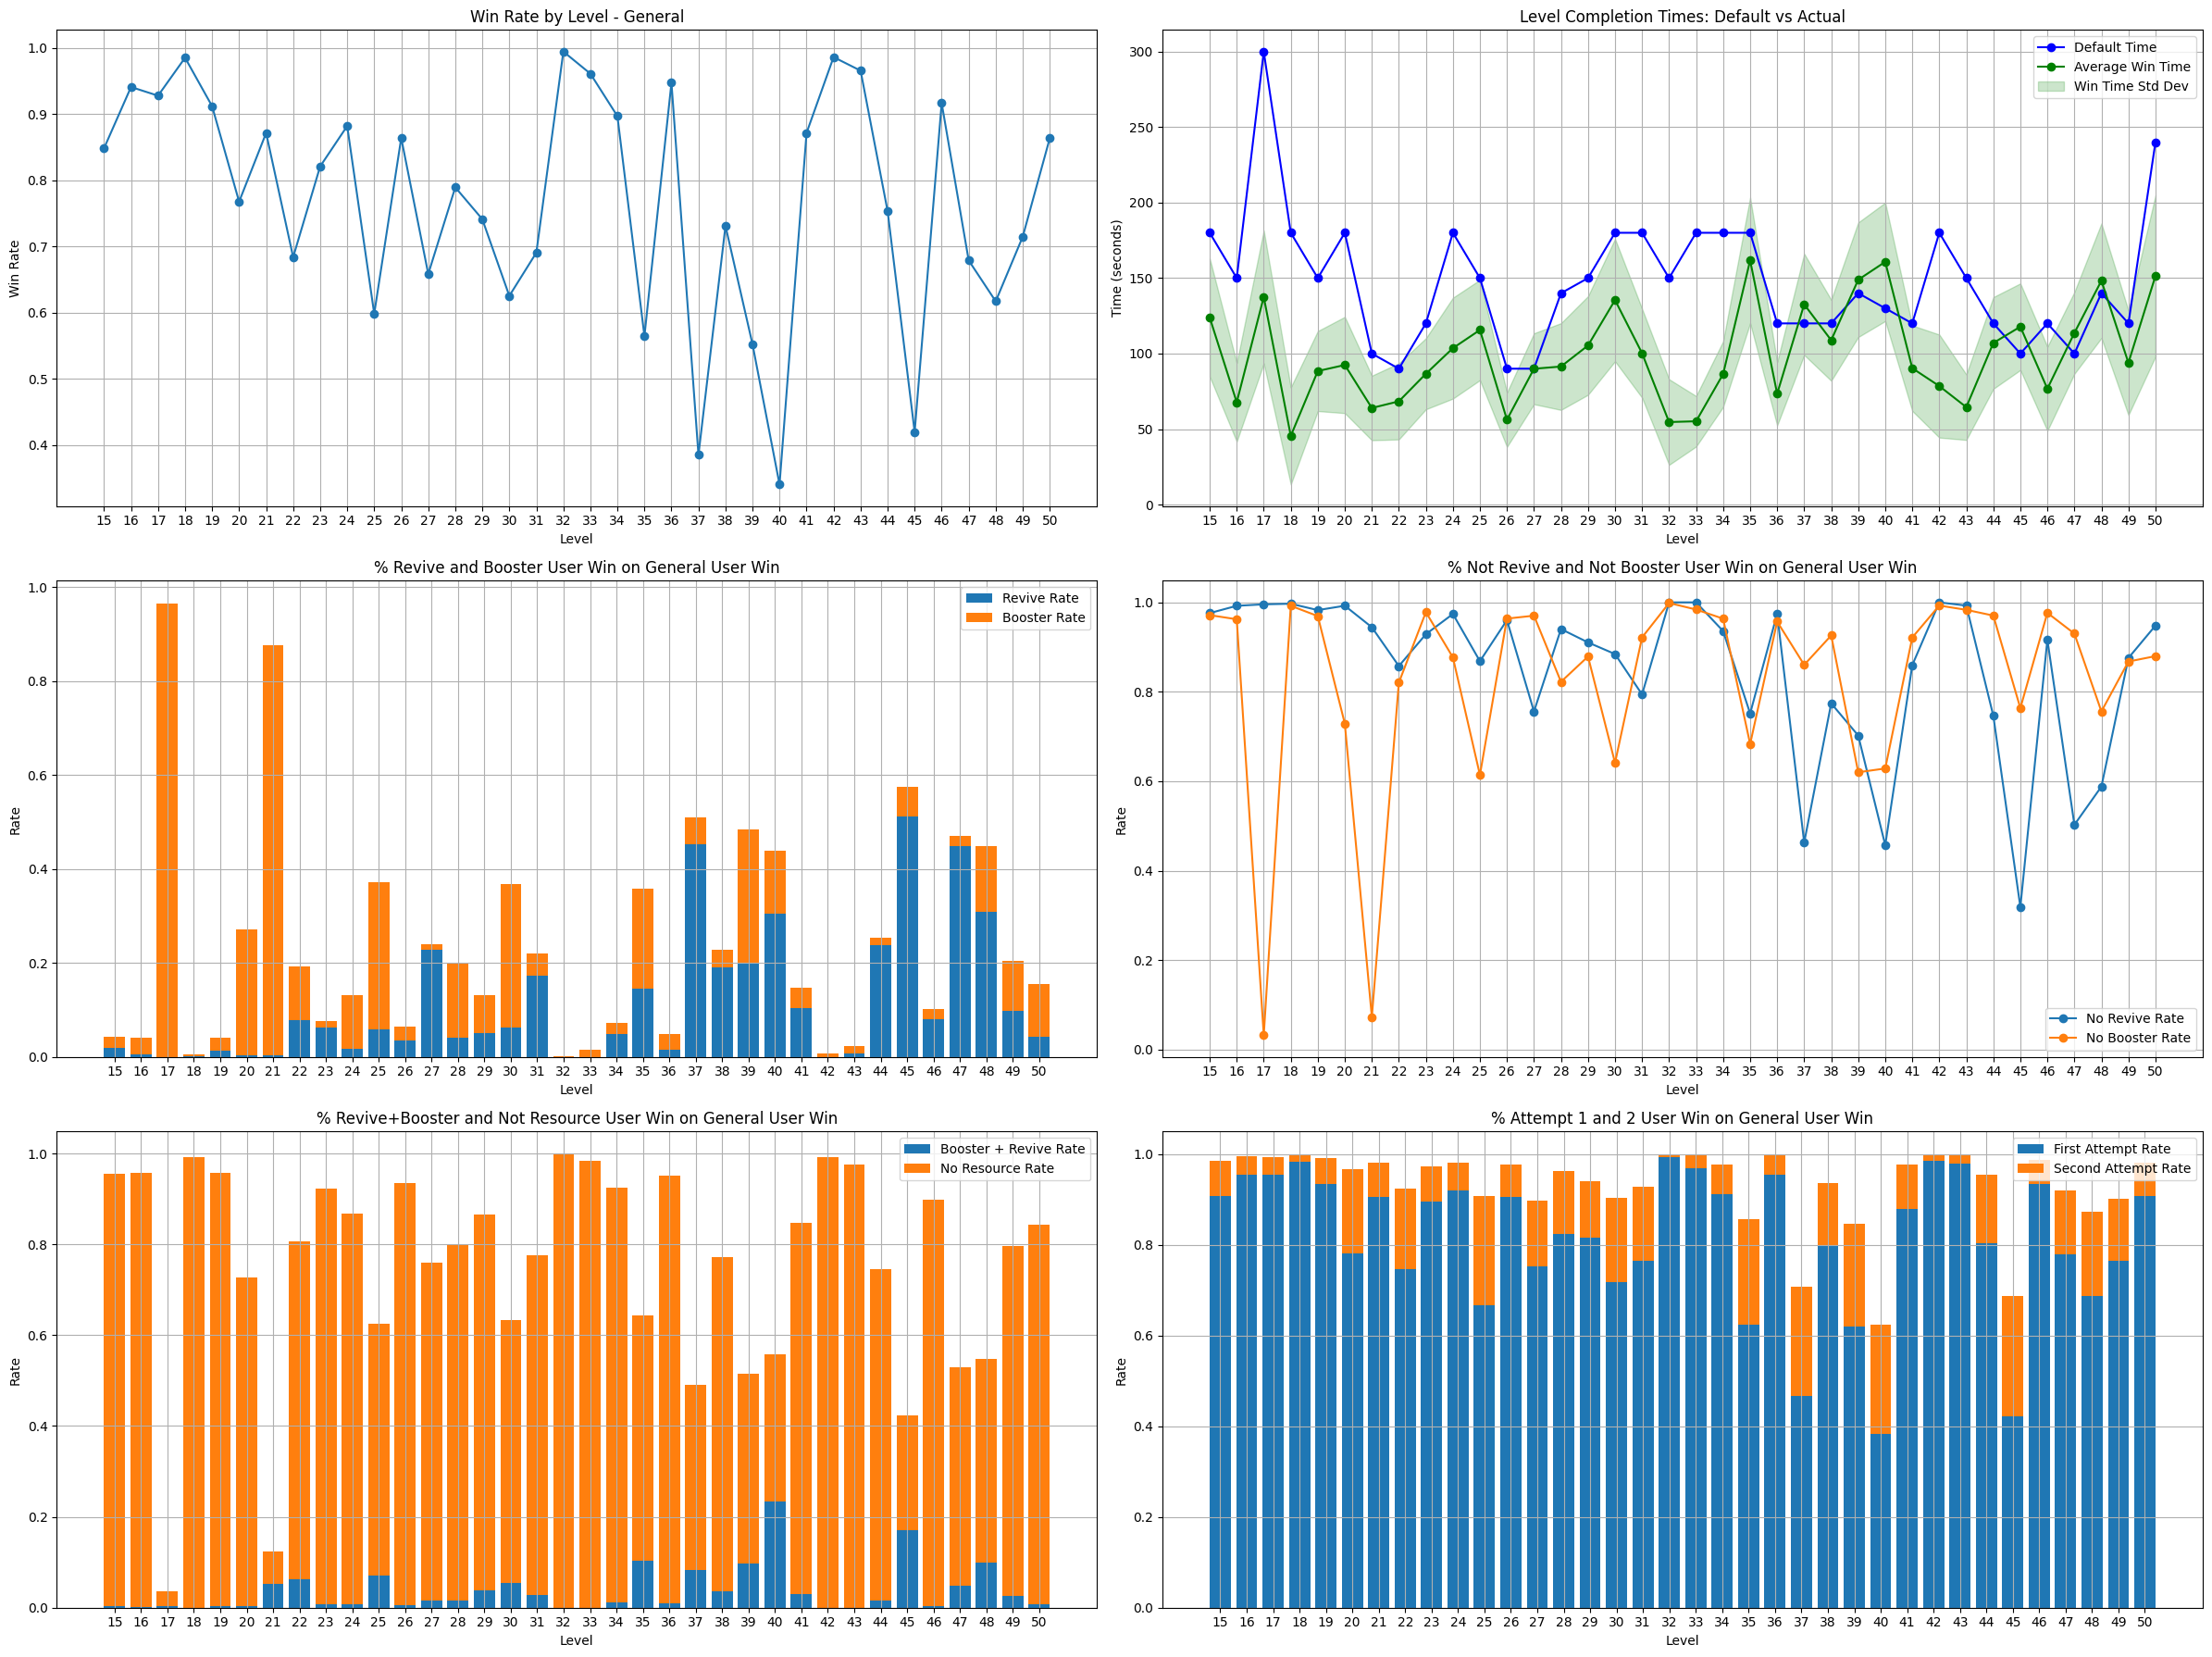

In [49]:
import matplotlib.pyplot as plt

# Tạo figure với 3 hàng 2 cột
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(24, 18))

# --- Plot 1: Win Rate General ---
ax1.plot(df_filtered['level'], df_filtered['win_rate'], marker='o')
ax1.set_title('Win Rate by Level - General')
ax1.set_xlabel('Level')
ax1.set_ylabel('Win Rate')
ax1.grid(True)
ax1.set_xticks(range(15, 51))

# --- Plot 2: General Time - Default vs Avg ± Std ---
ax2.plot(df_filtered['level'], df_filtered['time_default'], marker='o', label='Default Time', color='blue')
ax2.plot(df_filtered['level'], df_filtered['avg_time_play_win'], marker='o', label='Average Win Time', color='green')
ax2.fill_between(df_filtered['level'],
                 df_filtered['avg_time_play_win'] - df_filtered['std_time_play_win'],
                 df_filtered['avg_time_play_win'] + df_filtered['std_time_play_win'],
                 alpha=0.2, color='green', label='Win Time Std Dev')
ax2.set_title('Level Completion Times: Default vs Actual')
ax2.set_xlabel('Level')
ax2.set_ylabel('Time (seconds)')
ax2.grid(True)
ax2.legend()
ax2.set_xticks(range(15, 51))

# --- Plot 3: Revive and Booster Rates ---
ax3.bar(df_filtered['level'], df_filtered['win_user_revive_rate'], label='Revive Rate')
ax3.bar(df_filtered['level'], df_filtered['win_user_booster_rate'],
        bottom=df_filtered['win_user_revive_rate'], label='Booster Rate')
ax3.set_title('% Revive and Booster User Win on General User Win')
ax3.set_xlabel('Level')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()
ax3.set_xticks(range(15, 51))

# --- Plot 4: Not Revive and Not Booster Rates ---
ax4.plot(df_filtered['level'], df_filtered['win_user_not_revive_rate'], marker='o', label='No Revive Rate')
ax4.plot(df_filtered['level'], df_filtered['win_user_not_booster_rate'], marker='o', label='No Booster Rate')
ax4.set_title('% Not Revive and Not Booster User Win on General User Win')
ax4.set_xlabel('Level')
ax4.set_ylabel('Rate')
ax4.grid(True)
ax4.legend()
ax4.set_xticks(range(15, 51))

# --- Plot 5: Booster+Revive and No Resource Rates ---
ax5.bar(df_filtered['level'], df_filtered['win_user_booster_revive_rate'], label='Booster + Revive Rate')
ax5.bar(df_filtered['level'], df_filtered['win_user_not_resource_rate'],
        bottom=df_filtered['win_user_booster_revive_rate'], label='No Resource Rate')
ax5.set_title('% Revive+Booster and Not Resource User Win on General User Win')
ax5.set_xlabel('Level')
ax5.set_ylabel('Rate')
ax5.grid(True)
ax5.legend()
ax5.set_xticks(range(15, 51))

# --- Plot 6: Attempt 1 and Attempt 2 Rates ---
ax6.bar(df_filtered['level'], df_filtered['win_user_att1_rate'], label='First Attempt Rate')
ax6.bar(df_filtered['level'], df_filtered['win_user_att2_rate'],
        bottom=df_filtered['win_user_att1_rate'], label='Second Attempt Rate')
ax6.set_title('% Attempt 1 and 2 User Win on General User Win')
ax6.set_xlabel('Level')
ax6.set_ylabel('Rate')
ax6.grid(True)
ax6.legend()
ax6.set_xticks(range(15, 51))

# Layout gọn gàng
plt.tight_layout()
plt.show()


Nhận xét:
- Lv 20: có tỷ lệ dùng booster cao và second attempt rate cao
- Các lv khó có thể cần thiết để tối ưu: 22, 25, 27, 30, 35, 37, 40, 45, 48
- Các lv có đường win_time chạm vào default_time => cân nhắc tối ưu: 22, 25, 35, 37, 38, 39, 40, 41, 44, 45, 47, 48

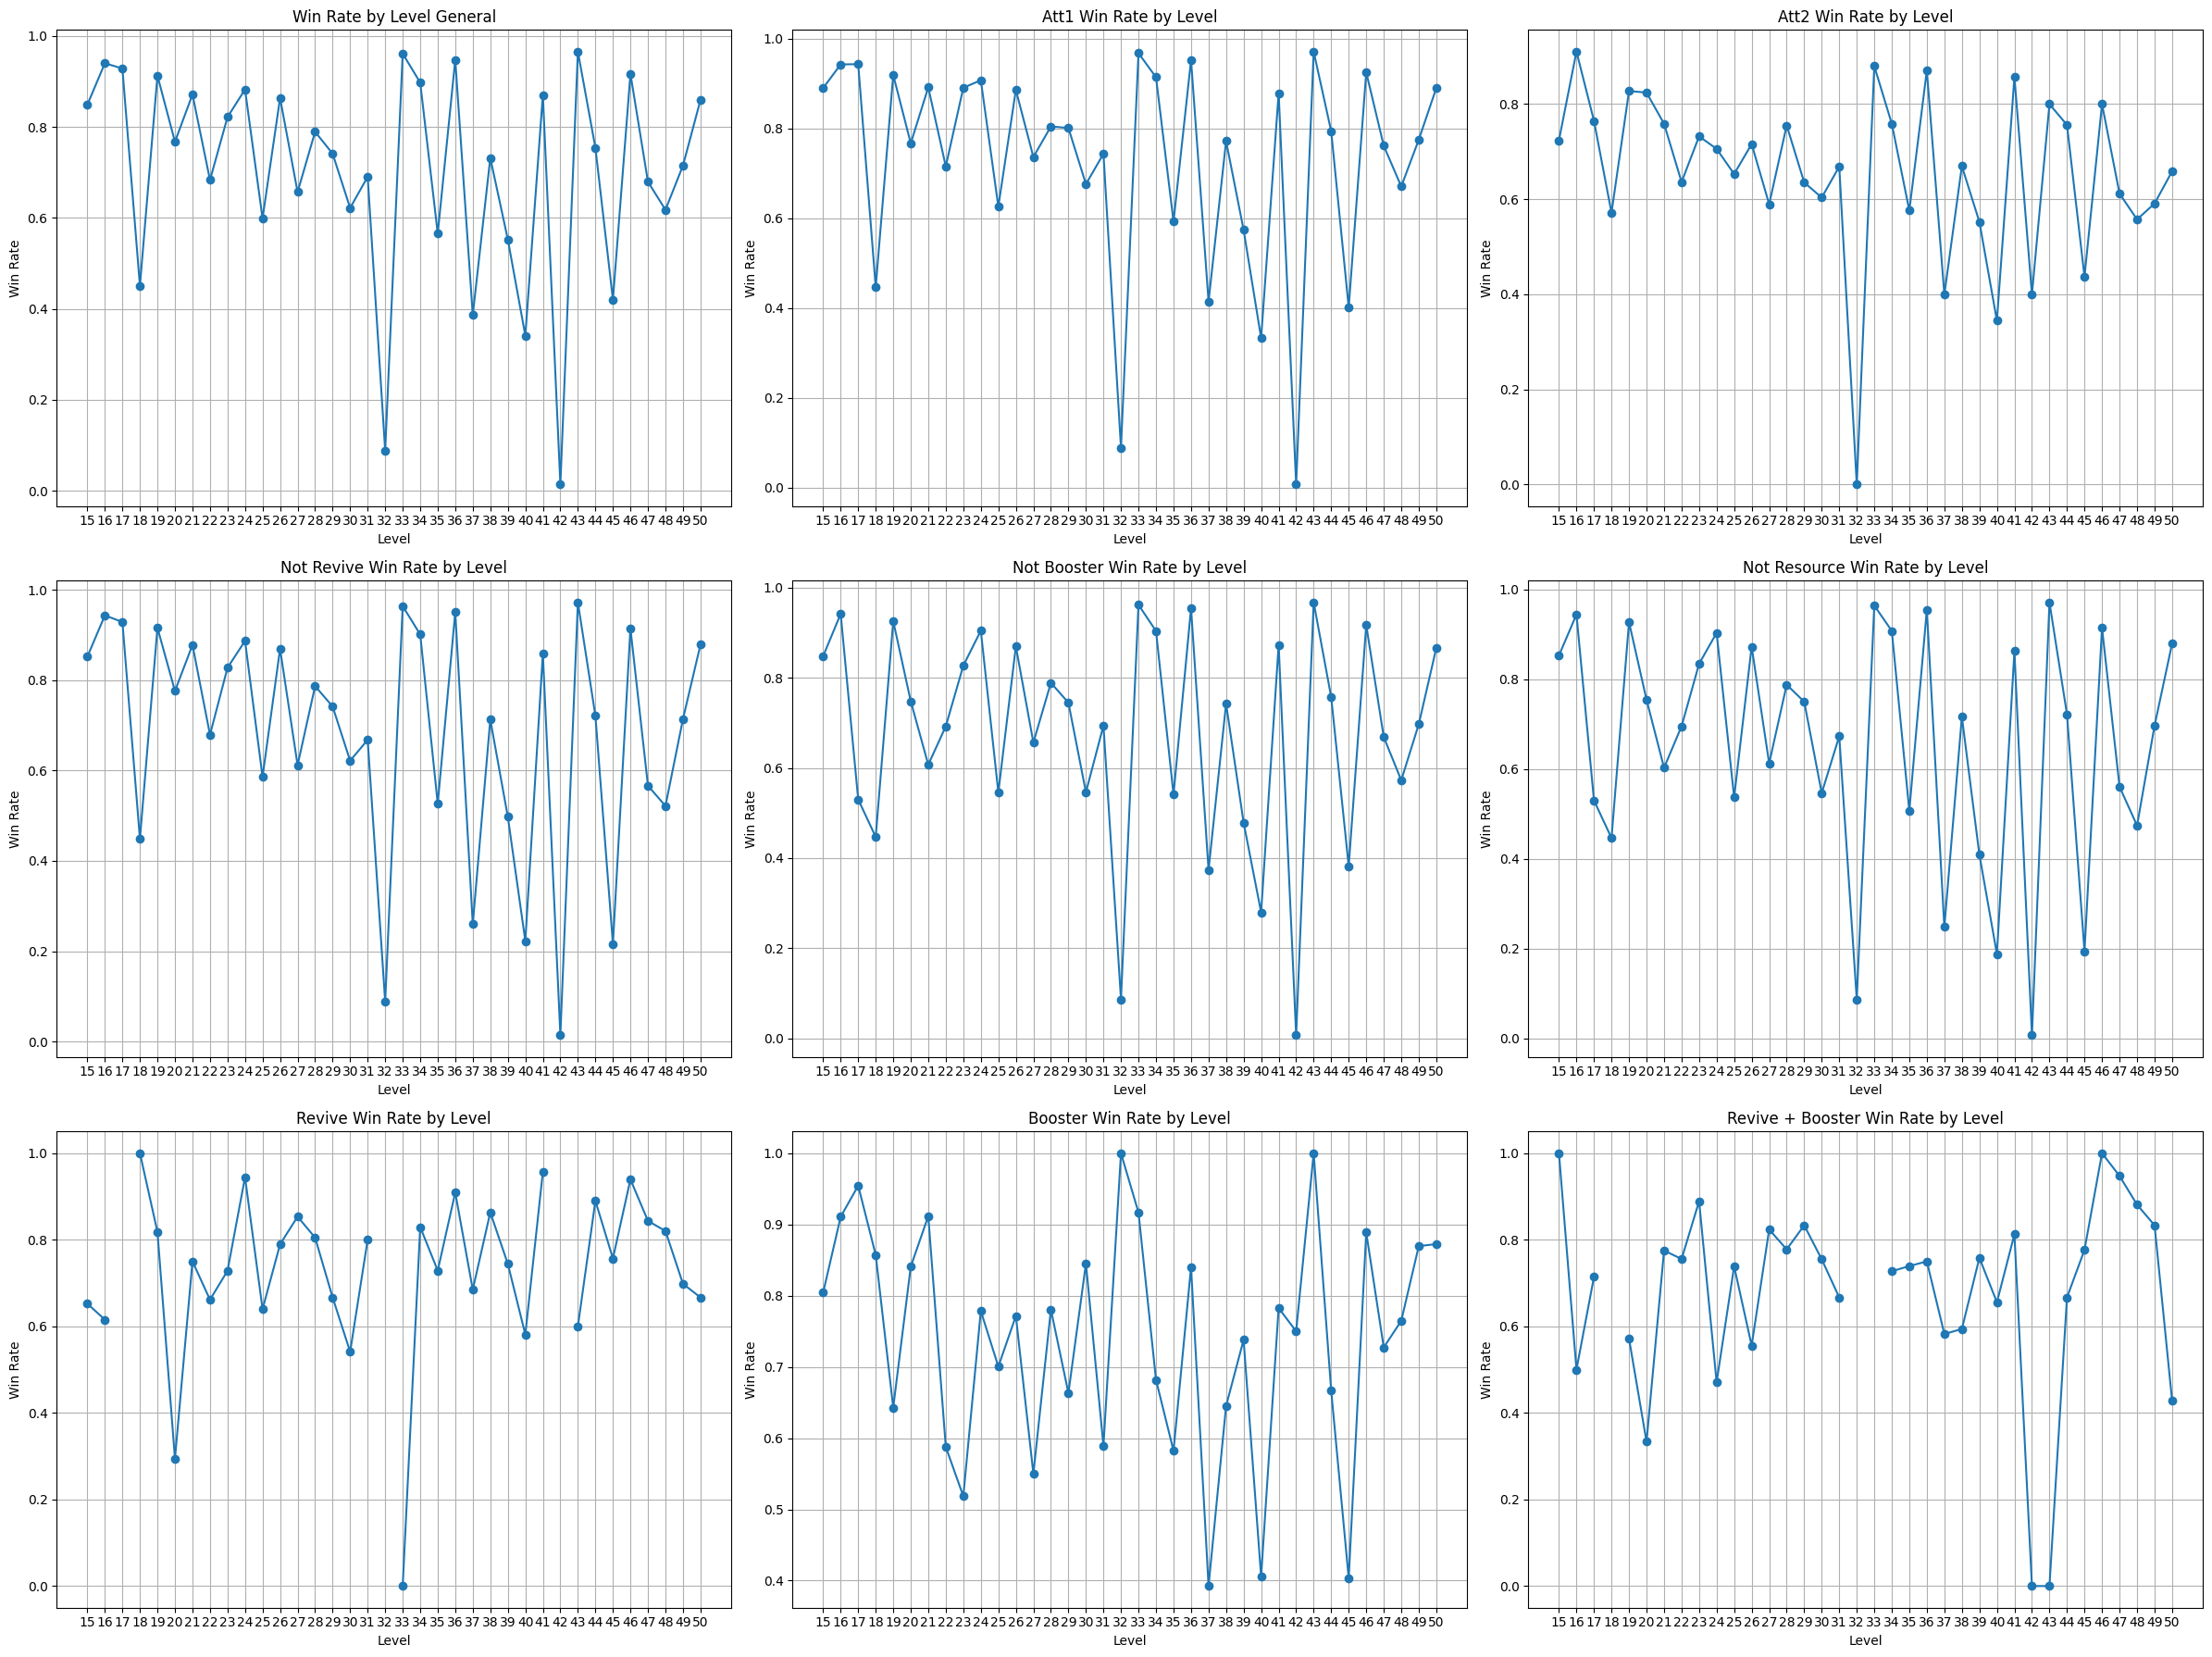

In [98]:
import matplotlib.pyplot as plt

# Tạo figure và 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(24, 18))
axes = axes.flatten()  # Flatten 2D array thành 1D để dễ indexing

# Danh sách dữ liệu, cột win_rate, và tiêu đề tương ứng
plot_info = [
    (df_filtered, 'win_rate', 'Win Rate by Level General'),
    (df_att1_filtered, 'att1_win_rate', 'Att1 Win Rate by Level'),
    (df_att2_filtered, 'att2_win_rate', 'Att2 Win Rate by Level'),
    (df_not_revive_filtered, 'not_revive_win_rate', 'Not Revive Win Rate by Level'),
    (df_not_booster_filtered, 'not_booster_win_rate', 'Not Booster Win Rate by Level'),
    (df_not_resource_filtered, 'not_resource_win_rate', 'Not Resource Win Rate by Level'),
    (df_revive_filtered, 'revive_win_rate', 'Revive Win Rate by Level'),
    (df_booster_filtered, 'booster_win_rate', 'Booster Win Rate by Level'),
    (df_revive_booster_filtered, 'revive_booster_win_rate', 'Revive + Booster Win Rate by Level')
]

# Lặp qua từng subplot và vẽ dữ liệu tương ứng
for i, (df, win_rate_col, title) in enumerate(plot_info):
    ax = axes[i]
    ax.plot(df['level'], df[win_rate_col].astype(float), marker='o')
    ax.set_title(title)
    ax.set_xlabel('Level')
    ax.set_ylabel('Win Rate')
    ax.grid(True)
    ax.set_xticks(range(15, 51))

# Tối ưu layout
plt.tight_layout()
plt.show()


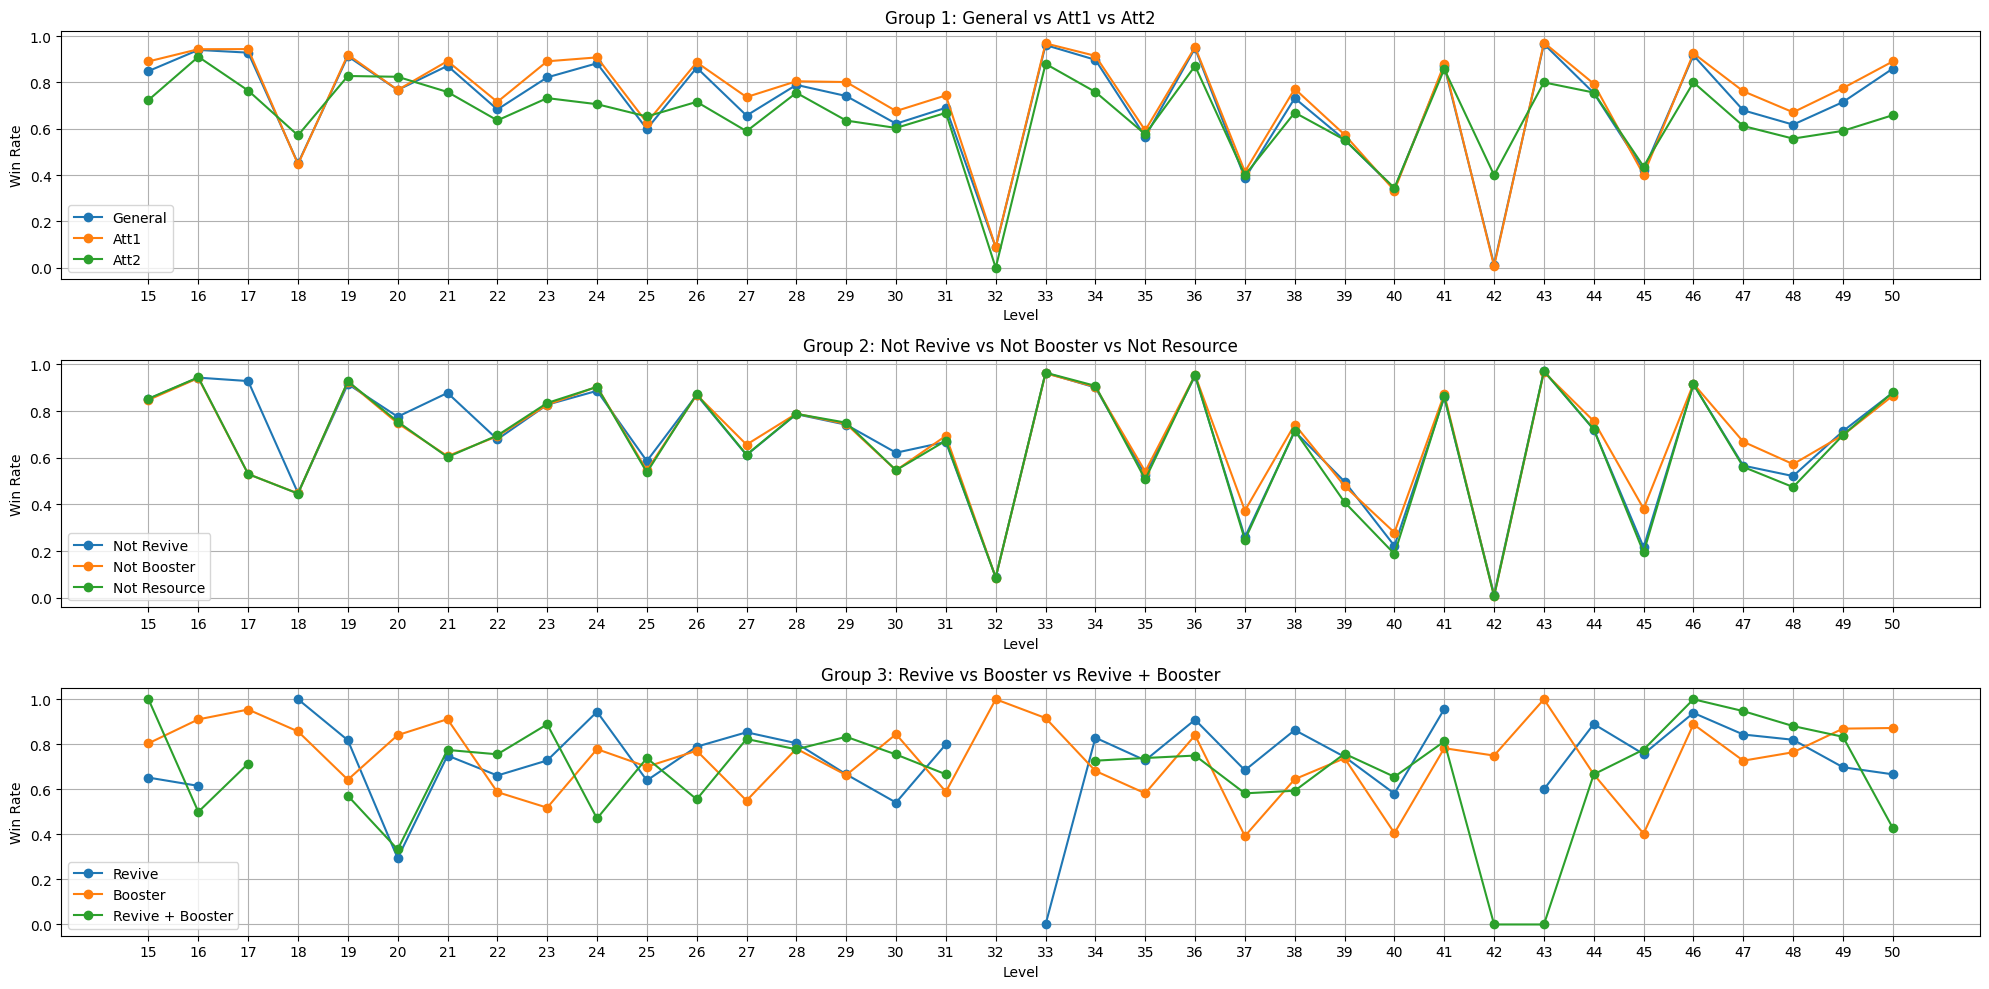

In [113]:
import matplotlib.pyplot as plt

# Tạo figure với 3 hàng 1 cột
fig, axes = plt.subplots(3, 1, figsize=(20, 10))

# Cấu hình từng nhóm: [(list các (df, column, label)), title]
plot_groups = [
    ([
        (df_filtered, 'win_rate', 'General'),
        (df_att1_filtered, 'att1_win_rate', 'Att1'),
        (df_att2_filtered, 'att2_win_rate', 'Att2'),
     ], 'Group 1: General vs Att1 vs Att2'),

    ([
        (df_not_revive_filtered, 'not_revive_win_rate', 'Not Revive'),
        (df_not_booster_filtered, 'not_booster_win_rate', 'Not Booster'),
        (df_not_resource_filtered, 'not_resource_win_rate', 'Not Resource'),
     ], 'Group 2: Not Revive vs Not Booster vs Not Resource'),

    ([
        (df_revive_filtered, 'revive_win_rate', 'Revive'),
        (df_booster_filtered, 'booster_win_rate', 'Booster'),
        (df_revive_booster_filtered, 'revive_booster_win_rate', 'Revive + Booster'),
     ], 'Group 3: Revive vs Booster vs Revive + Booster')
]

# Vẽ từng hàng
for i, (group, title) in enumerate(plot_groups):
    ax = axes[i]
    for df, col, label in group:
        ax.plot(df['level'], df[col].astype(float), marker='o', label=label)
    ax.set_title(title)
    ax.set_xlabel('Level')
    ax.set_ylabel('Win Rate')
    ax.set_xticks(range(15, 51))
    ax.grid(True)
    ax.legend()

# Tối ưu layout
plt.tight_layout()
plt.show()


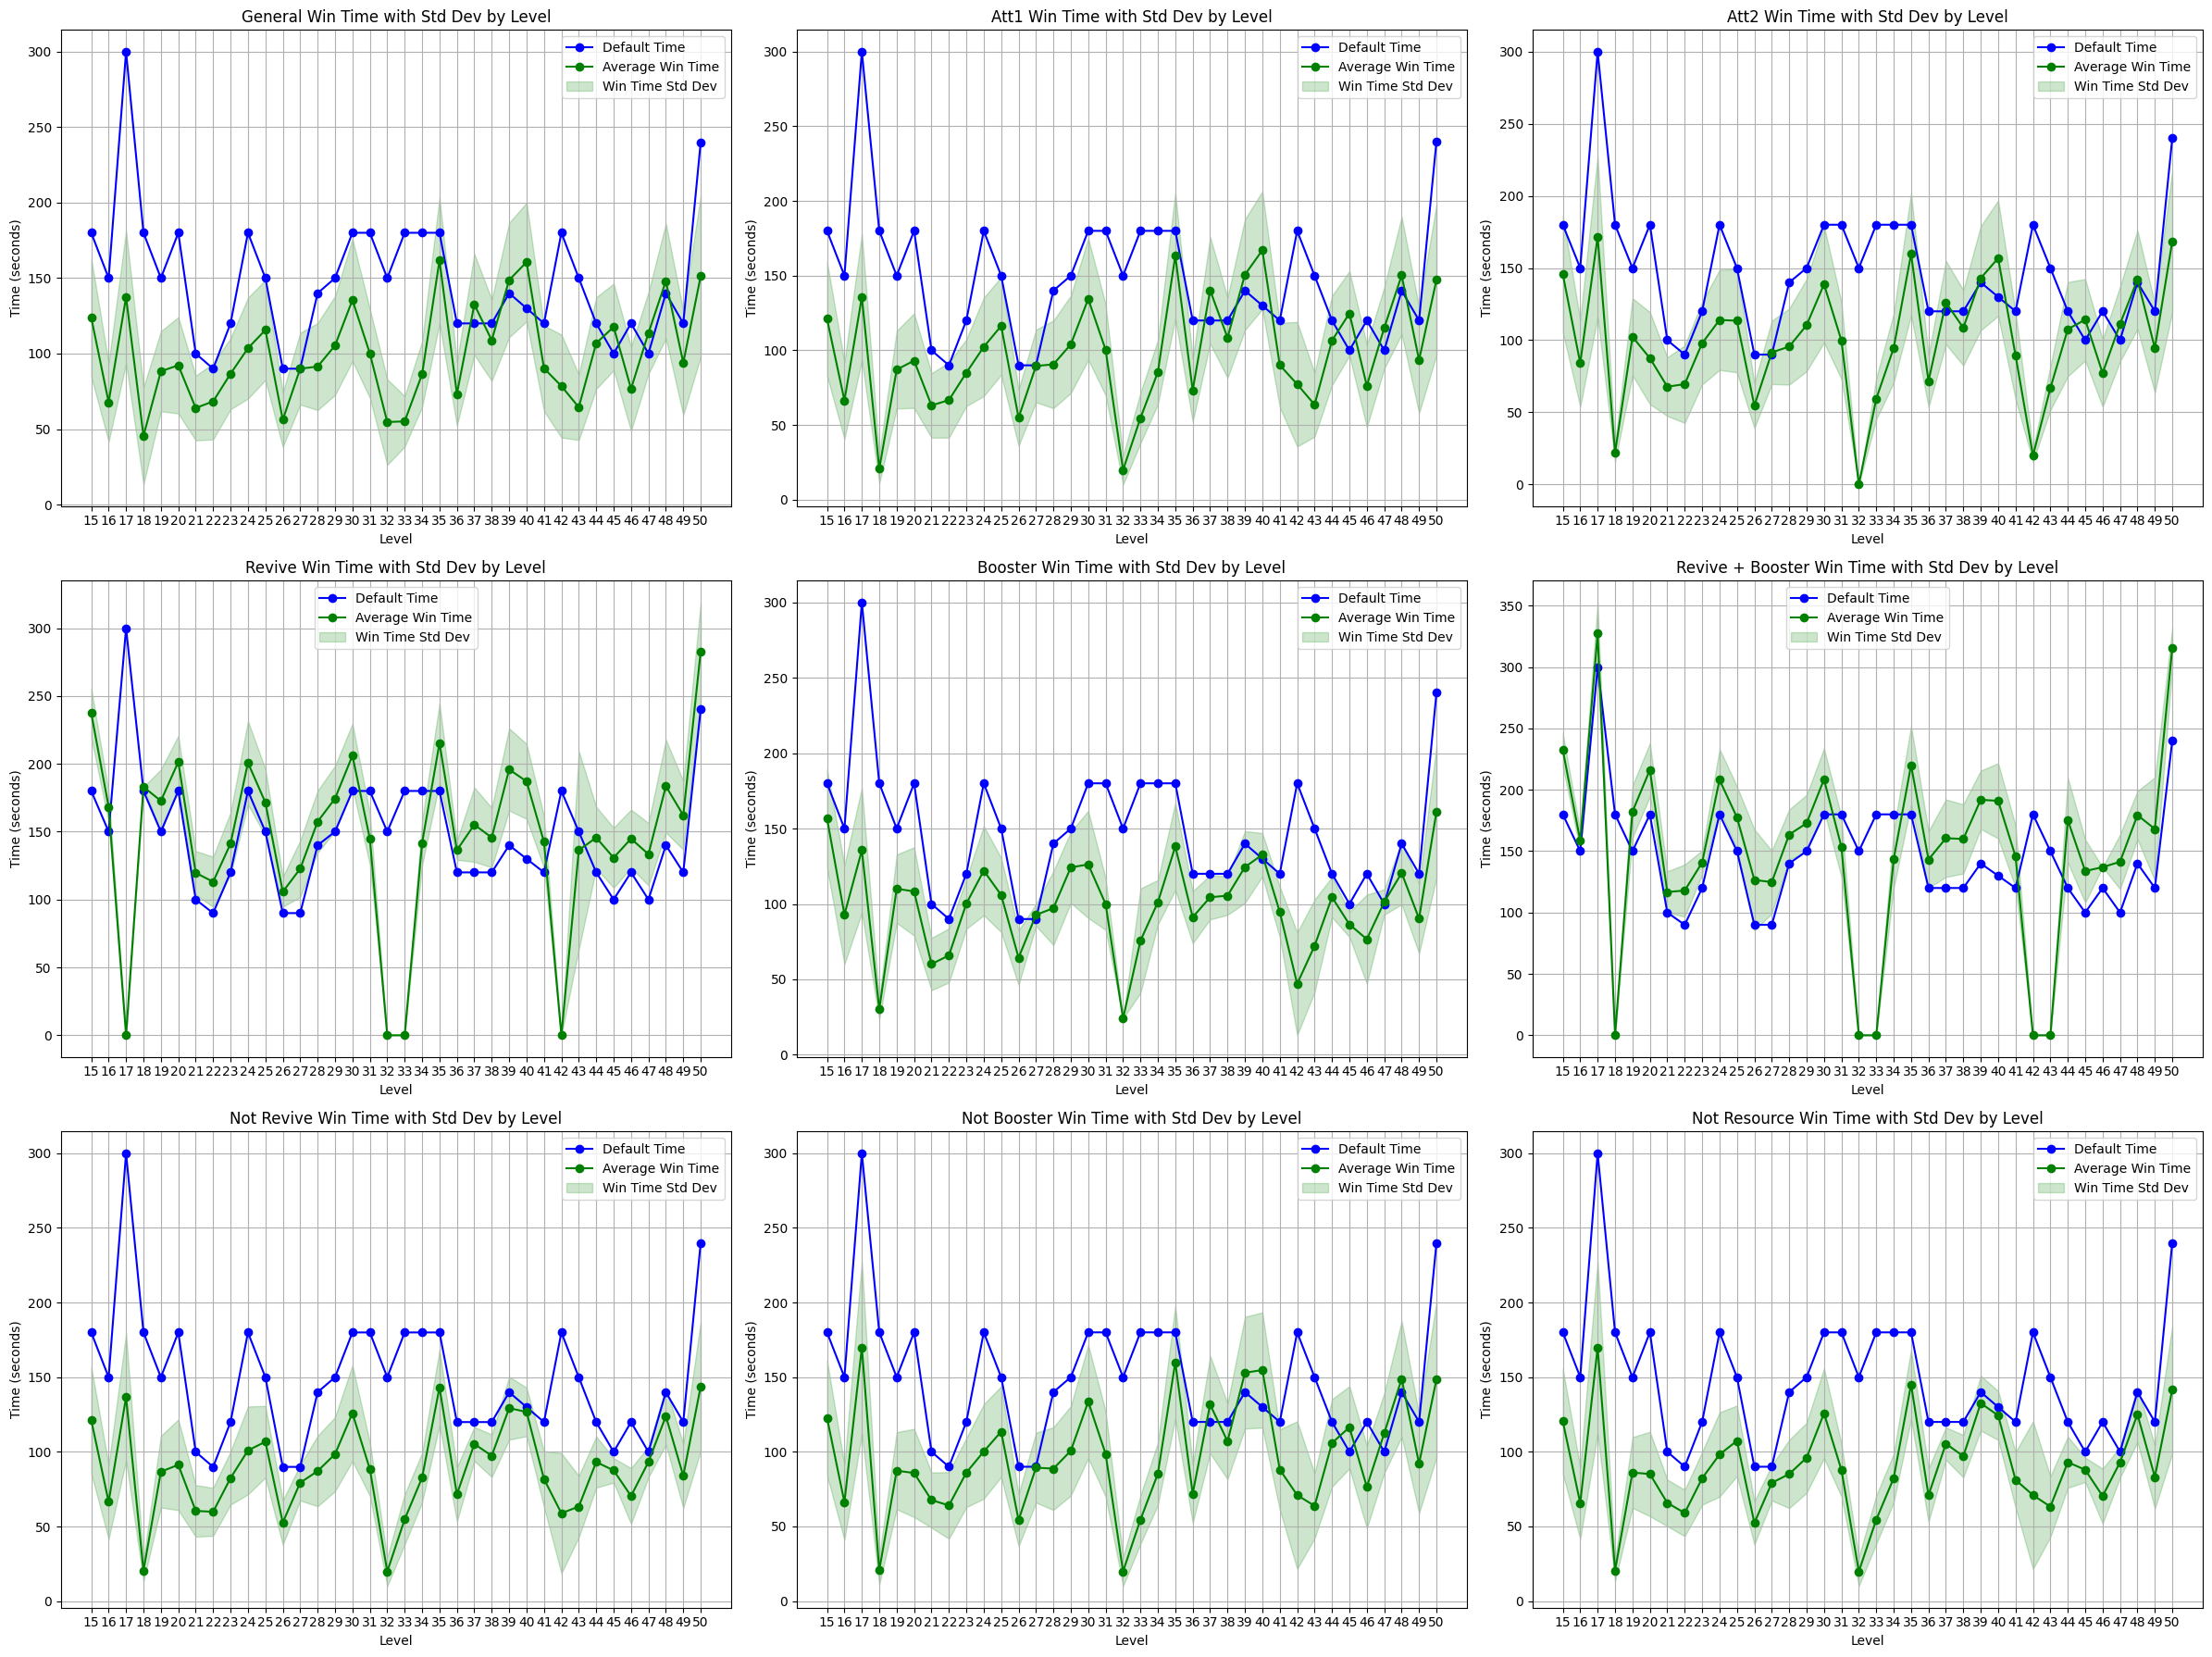

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Danh sách thông tin cho từng tệp dữ liệu
plot_data = [
    (df_filtered, 'avg_time_play_win', 'std_time_play_win', 'General'),
    (df_att1_filtered, 'avg_time_play_att1', 'std_time_play_att1', 'Att1'),
    (df_att2_filtered, 'avg_time_play_att2', 'std_time_play_att2', 'Att2'),
    (df_revive_filtered, 'avg_time_win_revive', 'std_time_win_revive', 'Revive'),
    (df_booster_filtered, 'avg_time_win_booster', 'std_time_win_booster', 'Booster'),
    (df_revive_booster_filtered, 'avg_time_win_booster_revive', 'std_time_win_booster_revive', 'Revive + Booster'),
    (df_not_revive_filtered, 'avg_time_win_not_revive', 'std_time_win_not_revive', 'Not Revive'),
    (df_not_booster_filtered, 'avg_time_win_not_booster', 'std_time_win_not_booster', 'Not Booster'),
    (df_not_resource_filtered, 'avg_time_win_not_resource', 'std_time_win_not_resource', 'Not Resource')
]

# Tạo figure 3x3
fig, axes = plt.subplots(3, 3, figsize=(24, 18))
axes = axes.flatten()

# Vẽ từng subplot
for i, (df, avg_col, std_col, title) in enumerate(plot_data):
    ax = axes[i]
    level = df['level'].astype(float)
    avg_time = df[avg_col].astype(float)
    std_time = df[std_col].astype(float)
    default_time = df['time_default'].astype(float)

    ax.plot(level, default_time, marker='o', label='Default Time', color='blue')
    ax.plot(level, avg_time, marker='o', label='Average Win Time', color='green')
    ax.fill_between(level, avg_time - std_time, avg_time + std_time,
                    alpha=0.2, color='green', label='Win Time Std Dev')

    ax.set_title(f'{title} Win Time with Std Dev by Level')
    ax.set_xlabel('Level')
    ax.set_ylabel('Time (seconds)')
    ax.set_xticks(range(15, 51))
    ax.grid(True)
    ax.legend()

# Tối ưu layout
plt.tight_layout()
plt.show()


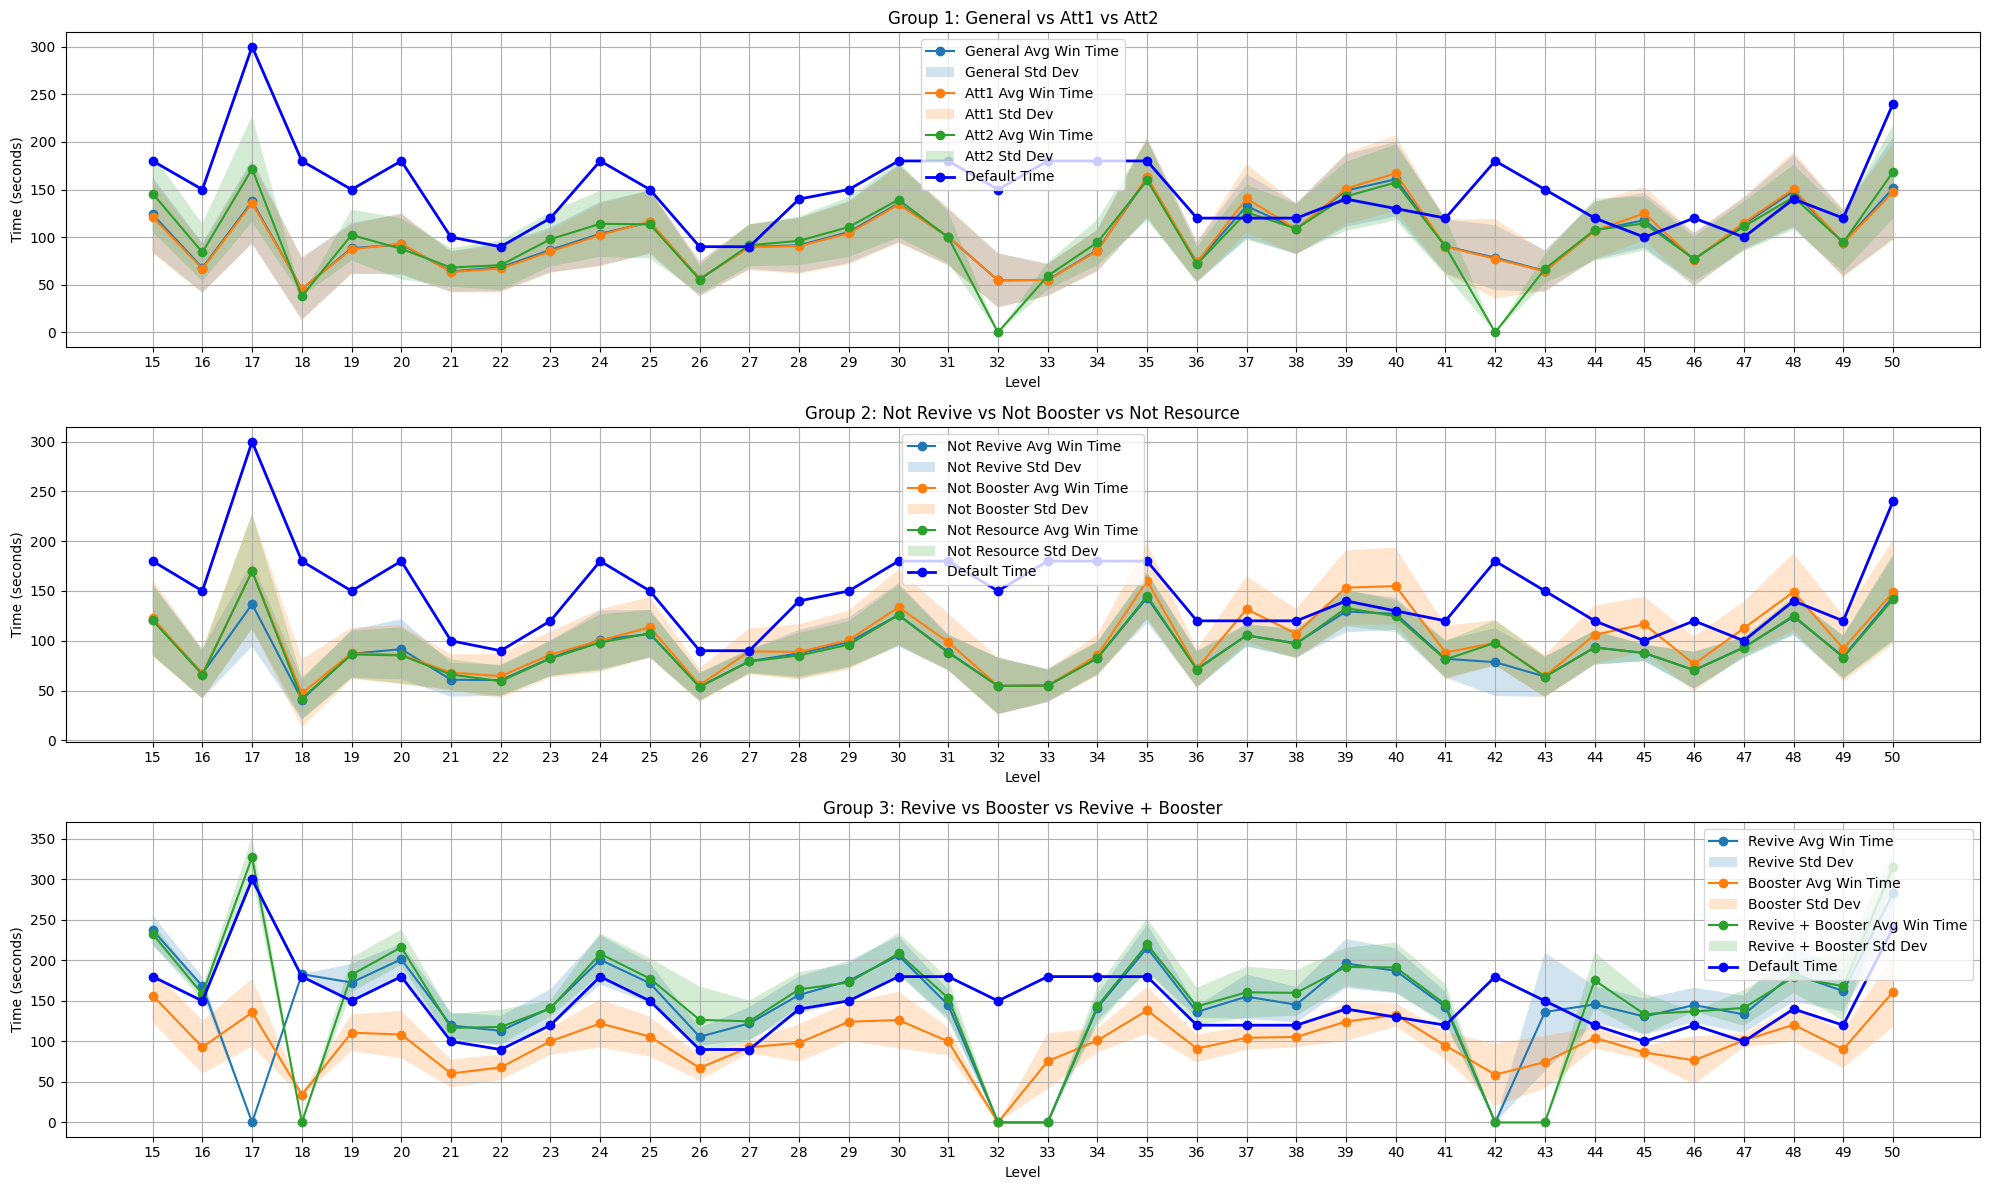

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Nhóm dữ liệu (3 dòng mỗi nhóm), kèm tên cột avg/std tương ứng
plot_groups = [
    ([
        (df_filtered, 'avg_time_play_win', 'std_time_play_win', 'General'),
        (df_att1_filtered, 'avg_time_play_att1', 'std_time_play_att1', 'Att1'),
        (df_att2_filtered, 'avg_time_play_att2', 'std_time_play_att2', 'Att2')
     ], 'Group 1: General vs Att1 vs Att2'),

    ([
        (df_not_revive_filtered, 'avg_time_win_not_revive', 'std_time_win_not_revive', 'Not Revive'),
        (df_not_booster_filtered, 'avg_time_win_not_booster', 'std_time_win_not_booster', 'Not Booster'),
        (df_not_resource_filtered, 'avg_time_win_not_resource', 'std_time_win_not_resource', 'Not Resource')
     ], 'Group 2: Not Revive vs Not Booster vs Not Resource'),

    ([
        (df_revive_filtered, 'avg_time_win_revive', 'std_time_win_revive', 'Revive'),
        (df_booster_filtered, 'avg_time_win_booster', 'std_time_win_booster', 'Booster'),
        (df_revive_booster_filtered, 'avg_time_win_booster_revive', 'std_time_win_booster_revive', 'Revive + Booster')
     ], 'Group 3: Revive vs Booster vs Revive + Booster'),
]

# Tạo 3 subplot (3 hàng, 1 cột)
fig, axes = plt.subplots(3, 1, figsize=(20, 12))

# Vẽ từng nhóm
for i, (group, title) in enumerate(plot_groups):
    ax = axes[i]

    for df, avg_col, std_col, label in group:
        level = df['level'].astype(float)
        avg_time = df[avg_col].astype(float)
        std_time = df[std_col].astype(float)

        # Đường average + std
        ax.plot(level, avg_time, marker='o', label=f'{label} Avg Win Time')
        ax.fill_between(level, avg_time - std_time, avg_time + std_time, alpha=0.2, label=f'{label} Std Dev')

    # Đường default_time (chung cho mỗi nhóm)
    ax.plot(level, df['time_default'].astype(float), marker='o', color='blue', label='Default Time', linewidth=2)

    ax.set_title(title)
    ax.set_xlabel('Level')
    ax.set_ylabel('Time (seconds)')
    ax.set_xticks(range(15, 51))
    ax.grid(True)
    ax.legend()

# Layout gọn gàng
plt.tight_layout()
plt.show()


# Check riêng từng level

In [ ]:
22, 25, 27, 30, 35, 37,38, 39, 40, 41, 44, 45, 47, 48

##  Level 22

In [85]:
query = f"""
select user_pseudo_id, level, count_sec, win_at_attempt, booster_use, revive_win
from `crazy-coffee-jam.dashboard_table.win_level_time_attemp`
WHERE event_date >= '{start_date}'
  AND version = '{version}'
  AND level in (22, 25, 27, 30, 35, 37,38, 39, 40, 41, 44, 45, 47, 48)
  AND count_sec > 50
"""
df = client.query(query).to_dataframe()

In [52]:
df_22 = df[df['level'] == 22]
df_22

user_pseudo_id  level  count_sec  win_at_attempt  \
8     15fc1d602d41193e9d7953eaf26c27de     22        110            <NA>   
12    001c77ac48802f5cf164a6d999939f21     22         51               1   
17    02e3fbe51eb7c6d4da30a79a9ed8d064     22         88               2   
18    048ec42798debd11694b8ca15a564e6a     22         79               2   
19    062f765a1393578317fa1a51e7ac22f9     22         70               1   
...                                ...    ...        ...             ...   
7705  52504c31f56f402eb52b49fbe7db5a80     22        119               2   
7723  75ace5e636c84d20526a8052e0ba74a5     22        134               1   
7798  d2b2b1b699751727c4194df059d46d0c     22        136               1   
7801  e0287d6fe8844daa61011da66dc5ae6b     22        139               2   
7835  60a5dab0678fbf9694bd412fdf70abca     22        161               2   

      booster_use  revive_win  
8            <NA>        <NA>  
12              0           0  
17              0           0  
18              2           0  
19              0           0  
...           ...         ...  
7705            0           1  
7723            0           2  
7798            0           2  
7801            1           2  
7835            0           3  

[778 rows x 6 columns]

In [55]:
df_22 = df_22.dropna()

In [58]:
import pandas as pd
import numpy as np

# Giả sử count_sec đã có trong df_22
min_bin = 50
max_bin = df_22['count_sec'].max()

# Tạo các mốc bin: 50, 60, 70, ..., đến max_bin + 10 để bao trùm
bins = np.arange(min_bin, max_bin + 10, 10)

# Tạo nhãn cho các bin
labels = [f"{i}-{i+10}" for i in bins[:-1]]

# Áp dụng pd.cut
df_22['bin_time'] = pd.cut(df_22['count_sec'], bins=bins, labels=labels, right=False)

df_22.head()


/tmp/ipython-input-58-1925789632.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_22['bin_time'] = pd.cut(df_22['count_sec'], bins=bins, labels=labels, right=False)


user_pseudo_id  level  count_sec  win_at_attempt  \
12  001c77ac48802f5cf164a6d999939f21     22         51               1   
17  02e3fbe51eb7c6d4da30a79a9ed8d064     22         88               2   
18  048ec42798debd11694b8ca15a564e6a     22         79               2   
19  062f765a1393578317fa1a51e7ac22f9     22         70               1   
28  0eae28f81243c645a60cdf64eb8d31c3     22         53               1   

    booster_use  revive_win bin_time  
12            0           0    50-60  
17            0           0    80-90  
18            2           0    70-80  
19            0           0    70-80  
28            0           0    50-60

In [59]:
# prompt: Sử dụng dataframe df_22: đếm số user_pseudo_id theo bin_timem hiển thị thêm cột % (so với total) bên cạnh

# Group by bin_time and count the number of unique user_pseudo_id
df_result = df_22.groupby('bin_time')['user_pseudo_id'].nunique().reset_index()
# Rename the column to reflect the count
df_result = df_result.rename(columns={'user_pseudo_id': 'count_user_pseudo_id'})
# Calculate the total number of unique user_pseudo_id
total_users = df_22['user_pseudo_id'].nunique()
# Calculate the percentage of users for each bin_time
df_result['percentage'] = (df_result['count_user_pseudo_id'] / total_users) * 100
# Display the result
df_result

/tmp/ipython-input-59-1930318611.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_result = df_22.groupby('bin_time')['user_pseudo_id'].nunique().reset_index()


bin_time  count_user_pseudo_id  percentage
0     50-60                   163   21.032258
1     60-70                   175   22.580645
2     70-80                   150   19.354839
3     80-90                   136   17.548387
4    90-100                    35    4.516129
5   100-110                    34    4.387097
6   110-120                    40    5.161290
7   120-130                    15    1.935484
8   130-140                    10    1.290323
9   140-150                     5    0.645161
10  150-160                     5    0.645161
11  160-170                     3    0.387097
12  170-180                     4    0.516129

In [60]:
df_22

user_pseudo_id  level  count_sec  win_at_attempt  \
12    001c77ac48802f5cf164a6d999939f21     22         51               1   
17    02e3fbe51eb7c6d4da30a79a9ed8d064     22         88               2   
18    048ec42798debd11694b8ca15a564e6a     22         79               2   
19    062f765a1393578317fa1a51e7ac22f9     22         70               1   
28    0eae28f81243c645a60cdf64eb8d31c3     22         53               1   
...                                ...    ...        ...             ...   
7705  52504c31f56f402eb52b49fbe7db5a80     22        119               2   
7723  75ace5e636c84d20526a8052e0ba74a5     22        134               1   
7798  d2b2b1b699751727c4194df059d46d0c     22        136               1   
7801  e0287d6fe8844daa61011da66dc5ae6b     22        139               2   
7835  60a5dab0678fbf9694bd412fdf70abca     22        161               2   

      booster_use  revive_win bin_time  
12              0           0    50-60  
17              0           0    80-90  
18              2           0    70-80  
19              0           0    70-80  
28              0           0    50-60  
...           ...         ...      ...  
7705            0           1  110-120  
7723            0           2  130-140  
7798            0           2  130-140  
7801            1           2  130-140  
7835            0           3  160-170  

[776 rows x 7 columns]

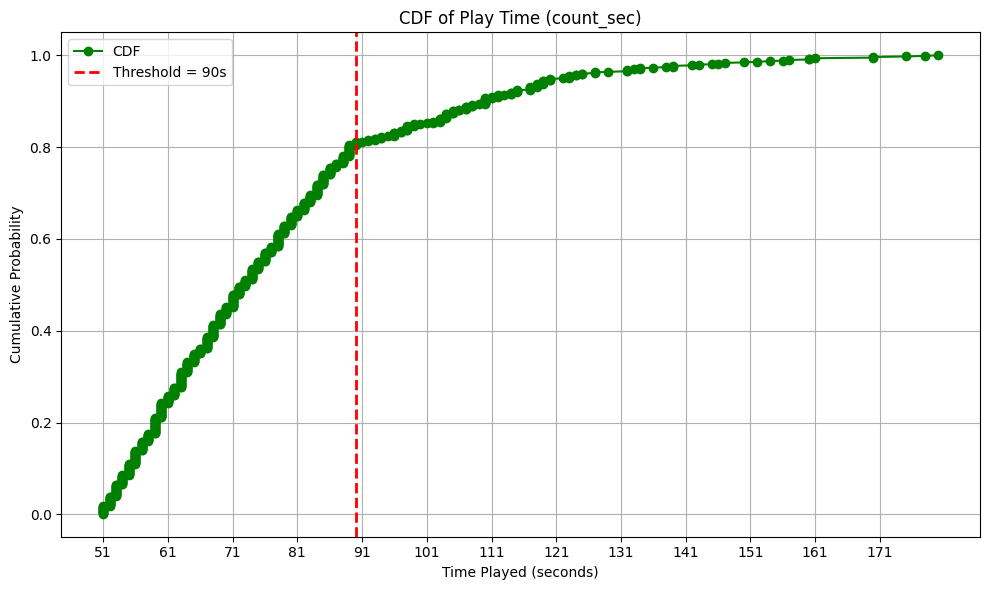

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Sắp xếp count_sec tăng dần
sorted_time = np.sort(df_22['count_sec'])

# Tính xác suất tích lũy (từ 0 đến 1)
cdf = np.arange(1, len(sorted_time) + 1) / len(sorted_time)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(sorted_time, cdf, marker='o', linestyle='-', color='green', label='CDF')

# Đường ngưỡng tại x = 90
plt.axvline(x=90, color='red', linestyle='--', linewidth=2, label='Threshold = 90s')

# Cấu hình biểu đồ
plt.title('CDF of Play Time (count_sec)')
plt.xlabel('Time Played (seconds)')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.xticks(np.arange(sorted_time.min(), sorted_time.max() + 1, 10))
plt.legend()
plt.tight_layout()
plt.show()


In [65]:
df_22_att1 = df_22[df_22['win_at_attempt'] == 1]

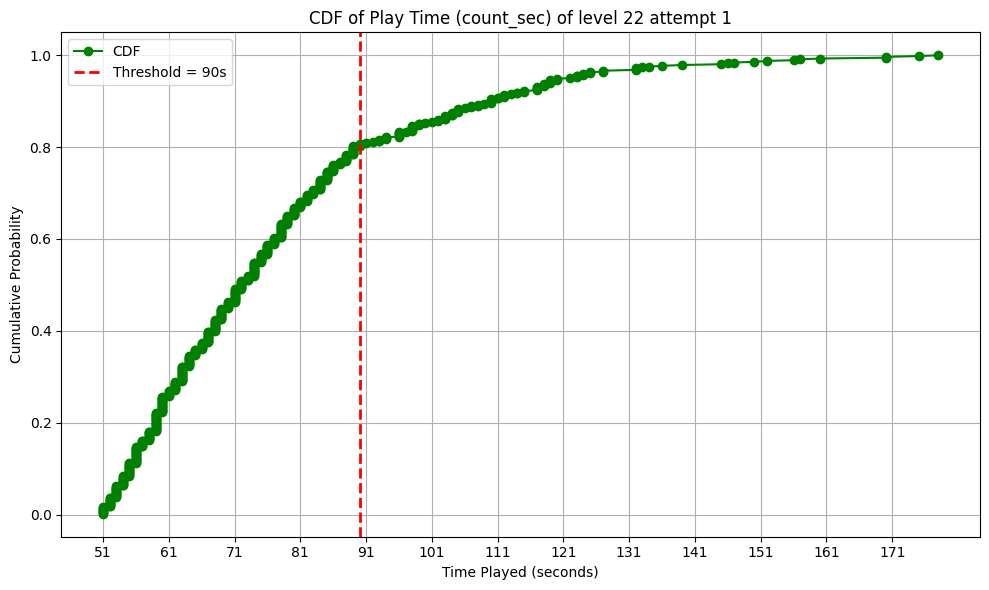

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Sắp xếp count_sec tăng dần
sorted_time = np.sort(df_22_att1['count_sec'])

# Tính xác suất tích lũy (từ 0 đến 1)
cdf = np.arange(1, len(sorted_time) + 1) / len(sorted_time)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(sorted_time, cdf, marker='o', linestyle='-', color='green', label='CDF')

# Đường ngưỡng tại x = 90
plt.axvline(x=90, color='red', linestyle='--', linewidth=2, label='Threshold = 90s')

# Cấu hình biểu đồ
plt.title('CDF of Play Time (count_sec) of level 22 attempt 1')
plt.xlabel('Time Played (seconds)')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.xticks(np.arange(sorted_time.min(), sorted_time.max() + 1, 10))
plt.legend()
plt.tight_layout()
plt.show()


In [67]:
df_22_att2 = df_22[df_22['win_at_attempt'] == 2]

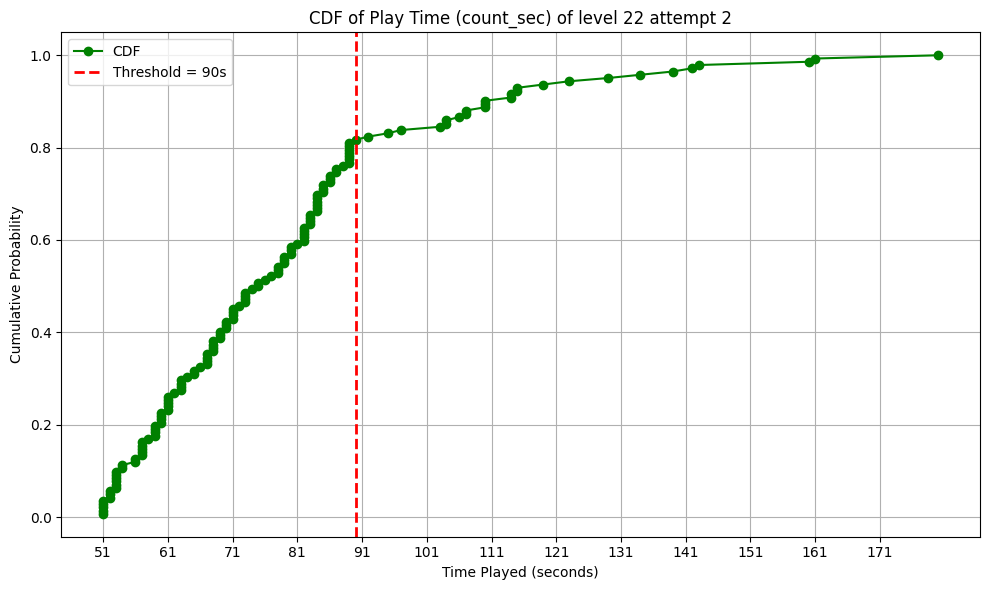

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Sắp xếp count_sec tăng dần
sorted_time = np.sort(df_22_att2['count_sec'])

# Tính xác suất tích lũy (từ 0 đến 1)
cdf = np.arange(1, len(sorted_time) + 1) / len(sorted_time)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(sorted_time, cdf, marker='o', linestyle='-', color='green', label='CDF')

# Đường ngưỡng tại x = 90
plt.axvline(x=90, color='red', linestyle='--', linewidth=2, label='Threshold = 90s')

# Cấu hình biểu đồ
plt.title('CDF of Play Time (count_sec) of level 22 attempt 2')
plt.xlabel('Time Played (seconds)')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.xticks(np.arange(sorted_time.min(), sorted_time.max() + 1, 10))
plt.legend()
plt.tight_layout()
plt.show()


In [71]:
df_22_revive = df_22[df_22['revive_win'] > 0]
df_22_revive['time_play_after_revive'] = df_22_revive['count_sec'] - 90

/tmp/ipython-input-71-2537293872.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_22_revive['time_play_after_revive'] = df_22_revive['count_sec'] - 90


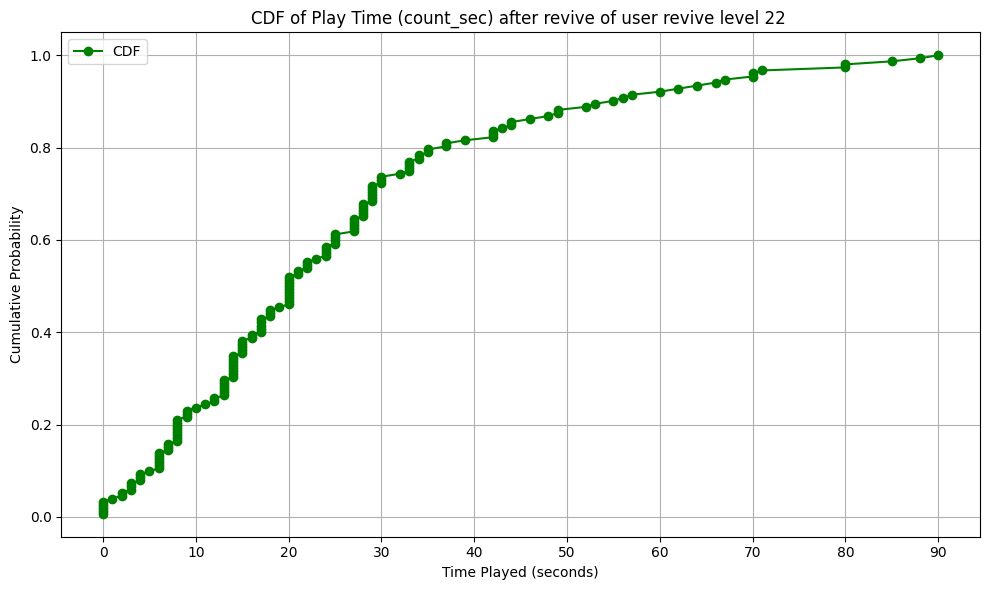

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Sắp xếp count_sec tăng dần
sorted_time = np.sort(df_22_revive['time_play_after_revive'])

# Tính xác suất tích lũy (từ 0 đến 1)
cdf = np.arange(1, len(sorted_time) + 1) / len(sorted_time)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(sorted_time, cdf, marker='o', linestyle='-', color='green', label='CDF')

# # Đường ngưỡng tại x = 90
# plt.axvline(x=90, color='red', linestyle='--', linewidth=2, label='Threshold = 90s')

# Cấu hình biểu đồ
plt.title('CDF of Play Time (count_sec) after revive of user revive level 22 ')
plt.xlabel('Time Played (seconds)')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.xticks(np.arange(sorted_time.min(), sorted_time.max() + 1, 10))
plt.legend()
plt.tight_layout()
plt.show()


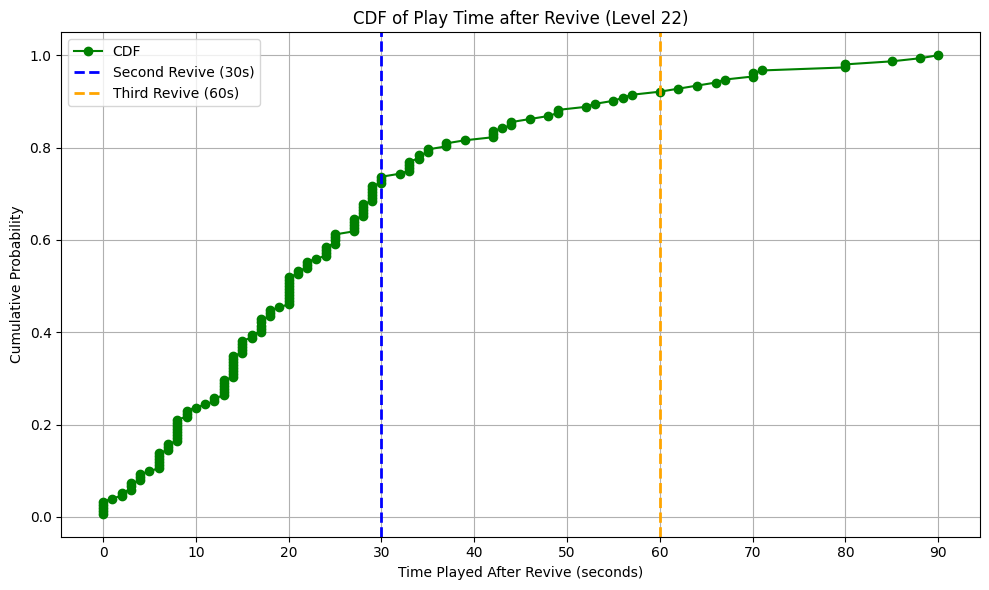

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Sắp xếp count_sec tăng dần
sorted_time = np.sort(df_22_revive['time_play_after_revive'])

# Tính xác suất tích lũy (từ 0 đến 1)
cdf = np.arange(1, len(sorted_time) + 1) / len(sorted_time)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(sorted_time, cdf, marker='o', linestyle='-', color='green', label='CDF')

# Thêm các đường dọc (ngưỡng)
plt.axvline(x=30, color='blue', linestyle='--', linewidth=2, label='Second Revive (30s)')
plt.axvline(x=60, color='orange', linestyle='--', linewidth=2, label='Third Revive (60s)')
# Nếu cần thêm mốc nữa:
# plt.axvline(x=90, color='red', linestyle='--', linewidth=2, label='Some Threshold (90s)')

# Cấu hình biểu đồ
plt.title('CDF of Play Time after Revive (Level 22)')
plt.xlabel('Time Played After Revive (seconds)')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.xticks(np.arange(sorted_time.min(), sorted_time.max() + 1, 10))
plt.legend()
plt.tight_layout()
plt.show()


In [78]:
import pandas as pd
import numpy as np

def count_user_by_bins(df, time_col, user_col='user_pseudo_id', min_bin=0, bin_width=10):
    """
    Tính số lượng user theo bin của thời gian và tính phần trăm so với tổng user.

    Parameters:
    - df: DataFrame đầu vào
    - time_col: tên cột thời gian dùng để phân bin (ví dụ: 'count_sec')
    - user_col: tên cột user ID (default: 'user_pseudo_id')
    - min_bin: giá trị bắt đầu của bin (default: 0)
    - bin_width: độ rộng mỗi bin (default: 10)

    Returns:
    - DataFrame có cột: bin_time, count_user_pseudo_id, percentage
    """
    df = df.copy()

    max_bin = df[time_col].max()
    bins = np.arange(min_bin, max_bin + bin_width, bin_width)
    labels = [f"{i}-{i + bin_width}" for i in bins[:-1]]

    df['bin_time'] = pd.cut(df[time_col], bins=bins, labels=labels, right=False)

    df_result = (
        df.groupby('bin_time')[user_col]
        .nunique()
        .reset_index()
        .rename(columns={user_col: 'count_user_pseudo_id'})
    )

    total_users = df[user_col].nunique()
    df_result['percentage'] = (df_result['count_user_pseudo_id'] / total_users) * 100

    return df_result


In [79]:
df_result = count_user_by_bins(df_22_revive, time_col='time_play_after_revive', min_bin=0, bin_width=10)
df_result

/tmp/ipython-input-78-1734723467.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('bin_time')[user_col]


bin_time  count_user_pseudo_id  percentage
0     0-10                    35   23.026316
1    10-20                    34   22.368421
2    20-30                    40   26.315789
3    30-40                    15    9.868421
4    40-50                    10    6.578947
5    50-60                     5    3.289474
6    60-70                     5    3.289474
7    70-80                     3    1.973684
8    80-90                     4    2.631579

## Level 25

In [86]:
df_25 = df[df['level'] == 25]
df_25

user_pseudo_id  level  count_sec  win_at_attempt  \
4     60230c95da7f54f9b40234583057ad10     25        196               2   
5     60480ff1612c8483894a87f63bfb2f39     25        253               1   
9     246aa0c1a55d22f814b22029edc0178c     25        101            <NA>   
14    001c77ac48802f5cf164a6d999939f21     25        103               1   
21    062f765a1393578317fa1a51e7ac22f9     25        168               1   
...                                ...    ...        ...             ...   
7755  95596763ad999d8f2874ca943b3f42d3     25        151               1   
7780  c321615640c618f3e1bba9e438468704     25        185               5   
7803  e0287d6fe8844daa61011da66dc5ae6b     25        116               1   
7821  fa4df6044f3126029c86c2887ef4e093     25        191               3   
7848  9f4e4de0932875d880b33de8cb152c69     25        190               2   

      booster_use  revive_win  
4               2           2  
5               4           4  
9            <NA>        <NA>  
14              1           0  
21              1           1  
...           ...         ...  
7755            7           1  
7780            0           2  
7803            2           0  
7821            3           2  
7848            2           2  

[918 rows x 6 columns]

In [87]:
df_25 = df_25.dropna()

In [92]:
df_result = count_user_by_bins(df_25, time_col='count_sec', min_bin=50, bin_width=30)
df_result

/tmp/ipython-input-78-1734723467.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('bin_time')[user_col]


bin_time  count_user_pseudo_id  percentage
0    50-80                   106   11.635565
1   80-110                   305   33.479693
2  110-140                   314   34.467618
3  140-170                   138   15.148189
4  170-200                    35    3.841932
5  200-230                    11    1.207464
6  230-260                     5    0.548847
7  260-290                     1    0.109769

## run all

In [ ]:
def count_user_by_bins_at_level(df, level, time_col, min_bin=0, bin_width=10):
    """
    Lọc theo level và gọi hàm count_user_by_bins để đếm user theo bin thời gian.

    Parameters:
    - df: DataFrame gốc
    - level: level muốn phân tích
    - time_col: cột thời gian để phân bin
    - min_bin: mốc bắt đầu của bin
    - bin_width: độ rộng mỗi bin

    Returns:
    - DataFrame kết quả từ count_user_by_bins()
    """
    df_level = df[df['level'] == level].dropna()
    return count_user_by_bins(df_level, time_col=time_col, min_bin=min_bin, bin_width=bin_width)
